# Modeling

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from IPython import display
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae, SCORERS
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, Trials
from sklearn.inspection import permutation_importance

In [14]:
#load dataframe OHE
#parse datetime column
df_ohe = pd.read_csv('ohe_data_with_lag7_PRCP.csv', parse_dates=['date'])
df_ohe.drop(columns='Unnamed: 0', inplace=True)
df_ohe.set_index('date', inplace=True)

In [38]:
df_ohe.columns

Index(['Avg_Temp(F)', 'Conf_Cases', 'day_of_year', 'Year', 'Day',
       'new_case_percent_pop*', 'PRCP_lag7wks', 'state_id_CT', 'state_id_MA',
       'state_id_ME', 'state_id_VT', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6'],
      dtype='object')

## Train-test split

Before training any models on the data, let's do a train-test split to keep training and testing data consistent and separated.

In [15]:
len(df_ohe)

2028

In [16]:
bins = np.linspace(0, 2224, 200)

In [17]:
# Create features
X, y = df_ohe.drop(columns=['Conf_Cases', 'new_case_percent_pop*']), df_ohe['new_case_percent_pop*']

In [18]:
y_binned = np.digitize(y, bins)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned, random_state=42)

## Using the mean as a baseline prediction model

Previously, we determined the R2 score of using the mean to predict COVID19 cases for each individual state. Let's do the same thing now that we have all the states in one DataFrame, so that we will have a baseline "dummy" model to compare our future optimized models to. 

In [9]:
dummy_mean = DummyRegressor()
# "Train" dummy regressor
dummy_mean.fit(X_train, y_train)
# Get R2 score
score_dummy = dummy_mean.score(X_test, y_test)
print("The R2 score of using the mean to predict COVID19 cases in our states is:", score_dummy)

The R2 score of using the mean to predict COVID19 cases in our states is: -0.0004031103934947211


Let's store the evaluation metric values for the dummy regressor so we can compare them with our future models. 

In [10]:
dummy_pred = dummy_mean.predict(X_test)
dummy_r2 = r2_score(y_test, dummy_pred)
dummy_mse = mse(y_test, dummy_pred)
dummy_rmse = np.sqrt(mse(y_test, dummy_pred))

## Tuning the top performing models for ensemble model

In the pre-processing step, we determined (with the help of Pycaret) that our top performing models were **CatBoost Regressor**, **Random Forest Regressor**, and **Extra Trees Regressor**. Let's now fine tune the hyperparameters of each of these models, using Coarse to Fine hyperparameter tuning, as well as Bayesian Optimization (where applicable), in preparation for feeding them into the pipeline of the Voting Regressor. 

### 1. Random Forest Regressor
With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself. I'll explore a couple different ways to determine optimal hyperparameters and will choose those that produce the best R2 and MSE for the final ensemble model (a VotingRegressor).

First, let's run a basic hyperparameter grid search and check the resulting R2, MSE, and RMSE. Then we'll put these values in a DataFrame with the those obtained from the dummy regressor (above) and compare the results of each set of hyperparameters determined throughout the course of the Coarse to Fine hyperparameter tuning process.

In [11]:
# Define parameters to search for GridSearchCV
basic_param_grid = {'n_estimators': [100, 300, 500, 900, 1200],
              'max_depth': [3, 5, 20, 50, 100],
              }
# Instantiate RandomForestRegressor
basic_rf = RandomForestRegressor(random_state=42)
cv_rf = GridSearchCV(basic_rf, basic_param_grid, cv = 5)
cv_rf_fit = cv_rf.fit(X_train, y_train)

In [12]:
print('The optimal max_depth for the RandomForestRegressor is: {}'.format(cv_rf_fit.best_params_['max_depth']))
print('The optimal n_estimators for the RandomForestRegressor is: {}'.format(cv_rf_fit.best_params_['n_estimators']))

The optimal max_depth for the RandomForestRegressor is: 50
The optimal n_estimators for the RandomForestRegressor is: 500


In [22]:
# Instantiate RFR with optimal hyperparameters
basic_rf = RandomForestRegressor(max_depth = 50, n_estimators = 500, random_state=42)
basic_rf.fit(X_train, y_train)
basic_rf_pred = basic_rf.predict(X_test)

In [23]:
# Calculate evaluation metrics on basic_rf
basic_rf_r2 = r2_score(y_test, basic_rf_pred)
basic_rf_mse = mse(y_test, basic_rf_pred)
basic_rf_rmse = np.sqrt(basic_rf_mse)

In [24]:
# Create RF results dataframe
rf_results = pd.DataFrame({'Model':['dummy_reg', 'basic_rf'], 'R2': [dummy_r2, basic_rf_r2], 'MSE':[dummy_mse, basic_rf_mse], 'RMSE':[dummy_rmse, basic_rf_rmse]})

In [25]:
rf_results 

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_rf,0.901841,28.792508,5.365865


***

#### Using RandomSearchCV to find optimal hyperparameter values
Now let's perform RandomizedSearchCV across a broader range of hyperparameters (and values) to get an idea of where to focus a grid search of a more comprehensive range of hyperparamters than those evaluated in the basic grid search above.

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 120, num = 11)]
max_depth.append(None)
#max_depth.append(9)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, n_jobs=-1, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 30, 40, 50, 60, 70,
                                                      80, 90, 100, 110, 120,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [26]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 120,
 'bootstrap': True}

In [27]:
# Instantiate RFR with optimal hyperparameters
rf2 = RandomForestRegressor(n_estimators= 300,
                             min_samples_split= 2,
                             min_samples_leaf= 1,
                             max_features= 'auto',
                             max_depth= 120,
                             bootstrap= True, 
                             random_state=42)
rf2.fit(X_train, y_train)
rf_pred2 = rf2.predict(X_test)

In [28]:
# Determine R2, MSE, RMSE 
rf_random_r2 = r2_score(y_test, rf_pred2)
rf_random_mse = mse(y_test, rf_pred2)
rf_random_rmse = np.sqrt(mse(y_test, rf_pred2))

In [29]:
# Add results to rf_results df
rf_results.loc[len(rf_results)]= ['rf_randomCV', 
                                 r2_score(y_test, rf_pred2),
                                 mse(y_test, rf_pred2),
                                 np.sqrt(mse(y_test, rf_pred2))]

In [30]:
rf_results

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_rf,0.901841,28.792508,5.365865
2,rf_randomCV,0.902908,28.479606,5.336629


***

### Using GridSearchCV to find the optimal hyperparameter values
We can now use the insights we gained from the above random search to perform a grid search across a broader range of hyperparameters (with more focused values).

In [31]:
# Create the parameter grid based on the results of random search 
GS_param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3],
    'n_estimators': [700, 800, 900, 1000, 1100]
}

In [32]:
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = GS_param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [33]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 11.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [70, 80, 90, 100, 110],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [700, 800, 900, 1000, 1100]},
             verbose=2)

In [34]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 800}

In [36]:
# Instantiate RFR with optimal hyperparameters
rf3 = RandomForestRegressor(n_estimators= 800,
                             min_samples_split= 3,
                             min_samples_leaf= 1,
                             max_features= 'auto',
                             max_depth= 80,
                             bootstrap= True)
rf3.fit(X_train, y_train)
rf_pred3 = rf3.predict(X_test)

In [37]:
# Determine R2 score
print('The R2 score for the RandomForestRegressor with GSCV tuning is {}'.format(r2_score(y_test, rf_pred3)))

The R2 score for the RandomForestRegressor with GSCV tuning is 0.9019616533243758


In [38]:
print('The MSE of the RandomForestRegressor with GSCV tuning is {}'.format(mse(y_test, rf_pred3)))

The MSE of the RandomForestRegressor with GSCV tuning is 28.75712801197089


In [39]:
# Add the results to rf_results
rf_results.loc[len(rf_results)]= ['rf_gridCV', 
                                 r2_score(y_test, rf_pred3),
                                 mse(y_test, rf_pred3),
                                 np.sqrt(mse(y_test, rf_pred3))]

In [40]:
rf_results

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_rf,0.901841,28.792508,5.365865
2,rf_randomCV,0.902908,28.479606,5.336629
3,rf_gridCV,0.901962,28.757128,5.362567


### Bayesian Optimization with hyperopt
Lastly, we'll try a different method of determining the best hyperparameter values: Bayesian Optimization. We'll use the hyperopt package across a narrower range of hyperparameters for the sake of time.

In [ ]:
#pip install hyperopt

In [41]:
trials = Trials()

In [42]:
space = {
    "n_estimators": hp.choice("n_estimators", [400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]),
    "max_depth": hp.quniform("max_depth", 30, 120, 10),
}

n_estimators-> start from 50 until 1500, 10
max_depth-> start from 5 until 150 or 200 append None
If better hp, experiment with hp for rf and et

In [43]:
# define objective function

def hyperparameter_tuning(params):
    rf_reg = RandomForestRegressor(**params,n_jobs=-1)
    r2 = cross_val_score(rf_reg, X_train, y_train ,scoring="r2").mean()
    return -r2

Replace R2 with **RMSE**, MSE, MAPE, MAE

In [44]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

100%|██████████| 100/100 [10:36<00:00,  6.36s/trial, best loss: -0.8363894656650939]
Best: {'max_depth': 70.0, 'n_estimators': 1}


In [45]:
# Instantiate RFR with optimal hyperparameters
rf4 = RandomForestRegressor(n_estimators= 500,
                             max_depth= 70)
                             
rf4.fit(X_train, y_train)
rf_pred4 = rf4.predict(X_test)

In [46]:
# Add results to rf_results
rf_results.loc[len(rf_results)]= ['rf_bayes_hyperopt', 
                                 r2_score(y_test, rf_pred4),
                                 mse(y_test, rf_pred4),
                                 np.sqrt(mse(y_test, rf_pred4))]

In [47]:
rf_results

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_rf,0.901841,28.792508,5.365865
2,rf_randomCV,0.902908,28.479606,5.336629
3,rf_gridCV,0.901962,28.757128,5.362567
4,rf_bayes_hyperopt,0.902457,28.611798,5.349000


$\star$ All of our Random Forest Regressors performed remarkably similarly. However, it looks like the optimal hyperparameters chosen by our original basic grid search and our random search performed the best, both in terms of the R2 and mean squared error. Because we tested a wider range of hyperparameters in the random search, we'll use those hyperparameters (as defined in `rf_randomCV`) in our final Voting Regressor ensemble.

***

## 2. Extra Trees Regressor
Now let's determine some optimal hyperparameters for the second estimator in our Voting Regressor: an Extra Trees Regressor. We'll repeat the same process we used for our Random Forest Regressor above, using Coarse to Fine hyperparameter tuning, as well as experimenting with Bayesian Optimization. We'll put the results of each of these searches in a DataFrame for easy comparison, and select the best set of hyperparameters. 

### Using basic hyperparameter tuning only

In [48]:
# Define parameters to search for GridSearchCV
param_grid = {'n_estimators': [100, 300, 500, 900, 1200],
              'max_depth': [3, 5, 20, 50, 100],
              }
# Instantiate ExtraTreesRegressor
et = ExtraTreesRegressor(random_state=42)
cv_et = GridSearchCV(et, param_grid, cv = 5)
cv_et_fit = cv_et.fit(X_train, y_train)

#Print the best parameter
print(cv_et_fit.best_params_)

{'max_depth': 50, 'n_estimators': 1200}


In [49]:
print('The optimal max_depth for the ExtraTreesRegressor is: {}'.format(cv_et_fit.best_params_['max_depth']))
print('The optimal n_estimators for the ExtraTreesRegressor is: {}'.format(cv_et_fit.best_params_['n_estimators']))

The optimal max_depth for the ExtraTreesRegressor is: 50
The optimal n_estimators for the ExtraTreesRegressor is: 1200


In [50]:
# Instantiate ETR with optimal hyperparameters
et_basic = RandomForestRegressor(max_depth = 50, n_estimators = 1200)
et_basic.fit(X_train, y_train)
et_basic_pred = et_basic.predict(X_test)

In [51]:
# Determine R2 score
print('The R2 score for the basic Extra Trees Regressor is {}'.format(r2_score(y_test, et_basic_pred)))

The R2 score for the basic Extra Trees Regressor is 0.9032730247633195


In [52]:
print('The MSE of the basic ExtraTreesRegressor is {}'.format(mse(y_test, et_basic_pred)))

The MSE of the basic ExtraTreesRegressor is 28.372469583716093


In [53]:
# Calculate results
basic_et_r2 = r2_score(y_test, et_basic_pred)
basic_et_mse = mse(y_test, et_basic_pred)
basic_et_rmse = np.sqrt(mse(y_test, et_basic_pred))

In [54]:
# Create ET DataFrame with dummy regressor results
et_results = pd.DataFrame({'Model':['dummy_reg', 'basic_et'], 'R2': [dummy_r2, basic_et_r2], 'MSE':[dummy_mse, basic_et_mse], 'RMSE':[dummy_rmse, basic_et_rmse]})

In [55]:
et_results

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_et,0.903273,28.372470,5.326581


***

### Using RandomSearchCV to find optimal hyperparameter values

In [56]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 140, num = 12)]
max_depth.append(None)
#max_depth.append(9)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid_et = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 10], 'bootstrap': [True, False]}


In [57]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
et = ExtraTreesRegressor(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et2 = RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
et2.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 30, 40, 50, 60, 70,
                                                      80, 90, 100, 110, 120,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [58]:
et2.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 120,
 'bootstrap': True}

In [59]:
# Instantiate RFR with optimal hyperparameters
et_random = ExtraTreesRegressor(n_estimators= 300,
                             min_samples_split= 2,
                             min_samples_leaf= 1,
                             max_features= 'auto',
                             max_depth= 120,
                             bootstrap= True)
et_random.fit(X_train, y_train)
et_random_pred = et_random.predict(X_test)

In [60]:
# Determine R2 score
print('The R2 score for the ExtraTreesRegressor with RSCV tuning is {}'.format(r2_score(y_test, et_random_pred)))

The R2 score for the ExtraTreesRegressor with RSCV tuning is 0.8662220451599607


In [61]:
print('The MSE of the ExtraTreesRegressor with RSCV tuning is {}'.format(mse(y_test, et_random_pred)))

The MSE of the ExtraTreesRegressor with RSCV tuning is 39.240459503497405


In [62]:
# Add results
et_results.loc[len(et_results)]= ['et_randomCV', 
                                 r2_score(y_test, et_random_pred),
                                 mse(y_test, et_random_pred),
                                 np.sqrt(mse(y_test, et_random_pred))]

In [63]:
et_results

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_et,0.903273,28.372470,5.326581
2,et_randomCV,0.866222,39.240460,6.264221


#### Using GridSearchCV to find the optimal hyperparamter values

In [64]:
# Create the parameter grid based on the results of random search 
GS_param_grid_et = {
    'bootstrap': [True],
    'max_depth': np.linspace(40, 150, 12),
    'max_features': ['auto'],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500, 800, 1000, 1200, 1600]
}

In [65]:
# Create a base model
et = ExtraTreesRegressor()
# Instantiate the grid search model
et3 = GridSearchCV(estimator = et, param_grid = GS_param_grid_et, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [66]:
# Fit the grid search to the data
et3.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 37.3min finished


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
       150.]),
                         'max_features': ['auto'], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500, 800, 1000, 1200, 1600]},
             verbose=2)

In [67]:
et3.best_params_

{'bootstrap': True,
 'max_depth': 150.0,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [69]:
# Instantiate RFR with optimal hyperparameters
et_grid = ExtraTreesRegressor(n_estimators= 500,
                             min_samples_split= 2,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth= 150,
                             bootstrap= True)
et_grid.fit(X_train, y_train)
et_grid_pred = et_grid.predict(X_test)

In [70]:
# Determine R2 score
print('The R2 score for the Extra Trees Regressor with GSCV is {}'.format(r2_score(y_test, et_grid_pred)))

The R2 score for the Extra Trees Regressor with GSCV is 0.8754864804537887


In [71]:
print('The MSE of the ExtraTreesRegressor with GSCV is {}'.format(mse(y_test, et_grid_pred)))

The MSE of the ExtraTreesRegressor with GSCV is 36.522966188511994


In [72]:
# Add results
et_results.loc[len(et_results)]= ['et_gridCV', 
                                 r2_score(y_test, et_grid_pred),
                                 mse(y_test, et_grid_pred),
                                 np.sqrt(mse(y_test, et_grid_pred))]

In [73]:
et_results 

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_et,0.903273,28.372470,5.326581
2,et_randomCV,0.866222,39.240460,6.264221
3,et_gridCV,0.875486,36.522966,6.043423


### Bayestian Optimization with hyperopt

In [74]:
trials_et = Trials()

n_estimators-> 50 until 1500, 10
max_depth-> 5, 150 or 200, 10
if hp improves greatly, run similar hp grids on rf and et gridsearch and random search

In [75]:
space_et = {
    "n_estimators": hp.choice("n_estimators", [400, 500, 600, 700, 800, 900, 1000, 1100, 1200]),
    "max_depth": hp.quniform("max_depth", 30, 120, 10),
}

n_estimators-> start from 50 until 1500, 10
max_depth-> start from 5 until 150 or 200 append None
If better hp, experiment with hp for rf and et

In [76]:
best_et = fmin(
    fn=hyperparameter_tuning,
    space = space_et, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials_et
)

print("Best: {}".format(best))

 80%|████████  | 80/100 [07:52<01:35,  4.79s/trial, best loss: -0.8364418323767213]

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



100%|██████████| 100/100 [29:12<00:00, 17.52s/trial, best loss: -0.8364418323767213]  
Best: {'max_depth': 70.0, 'n_estimators': 1}


In [87]:
# Instantiate RFR with optimal hyperparameters
et4 = ExtraTreesRegressor(n_estimators= 500,
                             max_depth= 70)
                             
et4.fit(X_train, y_train)
et_pred4 = et4.predict(X_test)

In [88]:
# Add results
et_results.loc[len(rf_results)]= ['et_bayes_hyperopt', 
                                 r2_score(y_test, et_pred4),
                                 mse(y_test, et_pred4),
                                 np.sqrt(mse(y_test, et_pred4))]

In [89]:
et_results 

,Model,R2,MSE,RMSE
0,dummy_reg,-0.000403,293.443548,17.130194
1,basic_et,0.903273,28.372470,5.326581
2,et_randomCV,0.866222,39.240460,6.264221
3,et_gridCV,0.875486,36.522966,6.043423
5,et_bayes_hyperopt,0.856115,42.205220,6.496554


For the Extra Trees Regressor, it seems that the hyperparameters suggested by the basic search (stored in `basic_et`) produced the best R2, MSE, and RMSE, so we'll use those hyperparameters for our final Voting Regressor.

## 3. CatBoost Regressor

Now for the third, and final, estimator in our ensemble method, a CatBoost Regressor. First we'll run the regressor without using the Pool function, and then we'll run it with the Pool function (each time testing a range of hyperparameters) to determine whether the model performs better with or without the Pool function. Then, we'll perform Coarse to Fine hyperparameter tuning, using random search and then grid search, just as with the above models. 

### Without Pool

In [93]:
X

,Avg_Temp(F),day_of_year,Year,Day,PRCP_lag7wks,state_id_CT,state_id_MA,state_id_ME,state_id_VT,Month_1,...,Month_10,Month_11,Month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,26.42,61,2020,1,15.547836,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2020-03-02,36.50,62,2020,2,38.293482,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-03-03,55.94,63,2020,3,31.223697,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2020-03-04,46.94,64,2020,4,38.563755,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-03-05,42.98,65,2020,5,34.239380,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,75.02,201,2021,20,25.929410,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2021-07-21,75.02,202,2021,21,17.360225,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2021-07-22,71.42,203,2021,22,17.332493,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [95]:
'''
cat_features_names = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 
                      'Month_9', 'Month_10', 'Month_11', 'Month_12', 'day_of_week_0', 'day_of_week_1', 
                      'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 
                      'state_id_MA', 'state_id_CT', 'state_id_VT', 
                      'state_id_ME'] # here we specify names of categorical features
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)
'''

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 6, 5, 8, 7]


In [115]:
'''
cat_features_names = ['day_of_week_0', 'day_of_week_1', 
                      'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 
                      'state_id_MA', 'state_id_CT', 'state_id_VT', 
                      'state_id_ME'] # here we specify names of categorical features
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)
'''

[21, 22, 23, 24, 25, 26, 27, 6, 5, 8, 7]


In [132]:
cat_features_names = ['state_id_MA', 'state_id_CT', 'state_id_VT', 
                      'state_id_ME'] # here we specify names of categorical features
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)

[6, 5, 8, 7]


In [133]:
params = {'loss_function':'RMSE',
          'eval_metric':'R2',
          'cat_features': cat_features,
          'verbose': 200,
          'early_stopping_rounds': 200,
          'random_seed': 42
         }
cbc_1 = CatBoostRegressor(**params)
cbc_1.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050488
0:	learn: 0.0524680	test: 0.0525084	best: 0.0525084 (0)	total: 1.14ms	remaining: 1.14s
200:	learn: 0.9252530	test: 0.8736713	best: 0.8736776 (195)	total: 197ms	remaining: 785ms
400:	learn: 0.9578939	test: 0.8874051	best: 0.8875045 (387)	total: 356ms	remaining: 532ms
600:	learn: 0.9719890	test: 0.8902304	best: 0.8903106 (584)	total: 516ms	remaining: 343ms
800:	learn: 0.9802041	test: 0.8942177	best: 0.8942372 (799)	total: 664ms	remaining: 165ms
999:	learn: 0.9852044	test: 0.8955558	best: 0.8958928 (924)	total: 812ms	remaining: 0us

bestTest = 0.8958927988
bestIteration = 924

Shrink model to first 925 iterations.


In [163]:
cbc_1.get_params()

{'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': 200,
 'eval_metric': 'R2',
 'early_stopping_rounds': 200,
 'cat_features': [6, 5, 8, 7]}

In [117]:
#display.Image("cat_boost_wo_pool.png")

In [134]:
pred_cbc1= cbc_1.predict(X_test)

In [135]:
r2_cbc1 = r2_score(y_test, pred_cbc1)
rmse_cbc1 = np.sqrt(mse(y_test, pred_cbc1))
mse_cbc1 = mse(y_test, pred_cbc1)

In [136]:
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse_cbc1))
print('MSE: {:.2f}'.format(mse_cbc1))
print('R2: {:.2f}'.format(r2_cbc1))

Testing performance
RMSE: 5.53
MSE: 30.54
R2: 0.90


### With Pool

In [137]:
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)

In [138]:
model_cbc2 = CatBoostRegressor(loss_function='RMSE', random_seed=42)

In [139]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [140]:
model_cbc2.grid_search(grid, train_dataset)

0:	learn: 22.6379004	test: 23.3262224	best: 23.3262224 (0)	total: 1.25ms	remaining: 124ms
1:	learn: 22.2787622	test: 22.9208954	best: 22.9208954 (1)	total: 2.73ms	remaining: 134ms
2:	learn: 21.9245927	test: 22.6138089	best: 22.6138089 (2)	total: 3.9ms	remaining: 126ms
3:	learn: 21.5824390	test: 22.3221616	best: 22.3221616 (3)	total: 5.27ms	remaining: 127ms
4:	learn: 21.2127063	test: 21.9536466	best: 21.9536466 (4)	total: 6.33ms	remaining: 120ms
5:	learn: 20.8944386	test: 21.6843002	best: 21.6843002 (5)	total: 7.55ms	remaining: 118ms
6:	learn: 20.5777958	test: 21.3309271	best: 21.3309271 (6)	total: 8.65ms	remaining: 115ms
7:	learn: 20.2326605	test: 20.9931302	best: 20.9931302 (7)	total: 9.69ms	remaining: 111ms
8:	learn: 19.8992847	test: 20.6773108	best: 20.6773108 (8)	total: 10.8ms	remaining: 109ms
9:	learn: 19.5885363	test: 20.3690259	best: 20.3690259 (9)	total: 11.7ms	remaining: 106ms
10:	learn: 19.3016660	test: 20.0666459	best: 20.0666459 (10)	total: 12.9ms	remaining: 104ms
11:	learn

18:	learn: 12.6470040	test: 13.2636559	best: 13.2636559 (18)	total: 10.7ms	remaining: 45.8ms
19:	learn: 12.4727365	test: 13.1066850	best: 13.1066850 (19)	total: 11.5ms	remaining: 46ms
20:	learn: 12.3509160	test: 12.9942757	best: 12.9942757 (20)	total: 12.4ms	remaining: 46.5ms
21:	learn: 12.1906210	test: 12.8510725	best: 12.8510725 (21)	total: 13.2ms	remaining: 46.8ms
22:	learn: 12.0631655	test: 12.6738114	best: 12.6738114 (22)	total: 14.2ms	remaining: 47.6ms
23:	learn: 11.9307430	test: 12.5584070	best: 12.5584070 (23)	total: 14.7ms	remaining: 46.5ms
24:	learn: 11.7934823	test: 12.4800898	best: 12.4800898 (24)	total: 15.1ms	remaining: 45.2ms
25:	learn: 11.6951643	test: 12.4098983	best: 12.4098983 (25)	total: 15.8ms	remaining: 45.1ms
26:	learn: 11.5973140	test: 12.2635107	best: 12.2635107 (26)	total: 17.1ms	remaining: 46.1ms
27:	learn: 11.5267378	test: 12.1392833	best: 12.1392833 (27)	total: 17.9ms	remaining: 46ms
28:	learn: 11.4501784	test: 12.0287066	best: 12.0287066 (28)	total: 18.9ms

82:	learn: 8.9756324	test: 9.5962988	best: 9.5962988 (82)	total: 59.1ms	remaining: 12.1ms
83:	learn: 8.9474972	test: 9.5764278	best: 9.5764278 (83)	total: 60.2ms	remaining: 11.5ms
84:	learn: 8.9204630	test: 9.5871249	best: 9.5764278 (83)	total: 61.2ms	remaining: 10.8ms
85:	learn: 8.8927545	test: 9.5778931	best: 9.5764278 (83)	total: 62.2ms	remaining: 10.1ms
86:	learn: 8.8761110	test: 9.5699553	best: 9.5699553 (86)	total: 62.7ms	remaining: 9.37ms
87:	learn: 8.8517859	test: 9.5503108	best: 9.5503108 (87)	total: 63.2ms	remaining: 8.62ms
88:	learn: 8.8303738	test: 9.5602870	best: 9.5503108 (87)	total: 64.4ms	remaining: 7.96ms
89:	learn: 8.8039069	test: 9.5503133	best: 9.5503108 (87)	total: 65.7ms	remaining: 7.3ms
90:	learn: 8.7766701	test: 9.5334002	best: 9.5334002 (90)	total: 66.8ms	remaining: 6.6ms
91:	learn: 8.7523713	test: 9.4936205	best: 9.4936205 (91)	total: 67.7ms	remaining: 5.89ms
92:	learn: 8.7341537	test: 9.4740564	best: 9.4740564 (92)	total: 68.6ms	remaining: 5.16ms
93:	learn: 8

87:	learn: 11.8025841	test: 12.4421885	best: 12.4421885 (87)	total: 47.2ms	remaining: 33.3ms
88:	learn: 11.7732482	test: 12.4122279	best: 12.4122279 (88)	total: 48ms	remaining: 32.9ms
89:	learn: 11.7447866	test: 12.3785094	best: 12.3785094 (89)	total: 48.5ms	remaining: 32.3ms
90:	learn: 11.7077574	test: 12.3481554	best: 12.3481554 (90)	total: 49.3ms	remaining: 32ms
91:	learn: 11.6743475	test: 12.2971769	best: 12.2971769 (91)	total: 50ms	remaining: 31.5ms
92:	learn: 11.6443741	test: 12.2799583	best: 12.2799583 (92)	total: 50.8ms	remaining: 31.1ms
93:	learn: 11.6124396	test: 12.2502585	best: 12.2502585 (93)	total: 51.9ms	remaining: 30.9ms
94:	learn: 11.5813549	test: 12.1989303	best: 12.1989303 (94)	total: 52.8ms	remaining: 30.5ms
95:	learn: 11.5563262	test: 12.1639902	best: 12.1639902 (95)	total: 53.6ms	remaining: 30.2ms
96:	learn: 11.5270584	test: 12.1447997	best: 12.1447997 (96)	total: 54.9ms	remaining: 30ms
97:	learn: 11.4907188	test: 12.1253239	best: 12.1253239 (97)	total: 56.1ms	rem

118:	learn: 10.9523920	test: 11.6358434	best: 11.6358434 (118)	total: 58.6ms	remaining: 15.3ms
119:	learn: 10.9267909	test: 11.6086134	best: 11.6086134 (119)	total: 59.4ms	remaining: 14.9ms
120:	learn: 10.9020528	test: 11.5903866	best: 11.5903866 (120)	total: 60.2ms	remaining: 14.4ms
121:	learn: 10.8831103	test: 11.5790532	best: 11.5790532 (121)	total: 61ms	remaining: 14ms
122:	learn: 10.8585174	test: 11.5591266	best: 11.5591266 (122)	total: 62.1ms	remaining: 13.6ms
123:	learn: 10.8276289	test: 11.5436425	best: 11.5436425 (123)	total: 63.3ms	remaining: 13.3ms
124:	learn: 10.8042039	test: 11.5042194	best: 11.5042194 (124)	total: 64.6ms	remaining: 12.9ms
125:	learn: 10.7848395	test: 11.4867152	best: 11.4867152 (125)	total: 65.6ms	remaining: 12.5ms
126:	learn: 10.7639345	test: 11.4734785	best: 11.4734785 (126)	total: 66.5ms	remaining: 12ms
127:	learn: 10.7460744	test: 11.4573500	best: 11.4573500 (127)	total: 67.5ms	remaining: 11.6ms
128:	learn: 10.7247566	test: 11.4418770	best: 11.4418770

108:	learn: 11.2191407	test: 11.9205517	best: 11.9205517 (108)	total: 59ms	remaining: 22.2ms
109:	learn: 11.1927834	test: 11.9104796	best: 11.9104796 (109)	total: 60.8ms	remaining: 22.1ms
110:	learn: 11.1609895	test: 11.8941444	best: 11.8941444 (110)	total: 61.5ms	remaining: 21.6ms
111:	learn: 11.1393224	test: 11.8639019	best: 11.8639019 (111)	total: 62.7ms	remaining: 21.3ms
112:	learn: 11.1194624	test: 11.8375452	best: 11.8375452 (112)	total: 63.9ms	remaining: 20.9ms
113:	learn: 11.0942109	test: 11.8208688	best: 11.8208688 (113)	total: 64.3ms	remaining: 20.3ms
114:	learn: 11.0621845	test: 11.8043463	best: 11.8043463 (114)	total: 64.8ms	remaining: 19.7ms
115:	learn: 11.0366798	test: 11.7853302	best: 11.7853302 (115)	total: 65.3ms	remaining: 19.1ms
116:	learn: 11.0129198	test: 11.7491664	best: 11.7491664 (116)	total: 65.7ms	remaining: 18.5ms
117:	learn: 10.9903920	test: 11.7366919	best: 11.7366919 (117)	total: 66.4ms	remaining: 18ms
118:	learn: 10.9640503	test: 11.6926165	best: 11.69261

116:	learn: 11.1027294	test: 11.7937408	best: 11.7937408 (116)	total: 57.9ms	remaining: 16.3ms
117:	learn: 11.0823495	test: 11.7821210	best: 11.7821210 (117)	total: 58.7ms	remaining: 15.9ms
118:	learn: 11.0593429	test: 11.7445656	best: 11.7445656 (118)	total: 59.3ms	remaining: 15.5ms
119:	learn: 11.0380322	test: 11.7221212	best: 11.7221212 (119)	total: 60.1ms	remaining: 15ms
120:	learn: 11.0138998	test: 11.7040061	best: 11.7040061 (120)	total: 61.2ms	remaining: 14.7ms
121:	learn: 10.9940953	test: 11.6917770	best: 11.6917770 (121)	total: 62.2ms	remaining: 14.3ms
122:	learn: 10.9687095	test: 11.6712720	best: 11.6712720 (122)	total: 63.2ms	remaining: 13.9ms
123:	learn: 10.9412140	test: 11.6576388	best: 11.6576388 (123)	total: 65.4ms	remaining: 13.7ms
124:	learn: 10.9189362	test: 11.6211364	best: 11.6211364 (124)	total: 66.5ms	remaining: 13.3ms
125:	learn: 10.8982506	test: 11.6026063	best: 11.6026063 (125)	total: 67.6ms	remaining: 12.9ms
126:	learn: 10.8785756	test: 11.5890733	best: 11.589

167:	learn: 10.0112204	test: 10.8001623	best: 10.8001623 (167)	total: 71.9ms	remaining: 13.7ms
168:	learn: 9.9979019	test: 10.7923972	best: 10.7923972 (168)	total: 72.6ms	remaining: 13.3ms
169:	learn: 9.9806374	test: 10.7801935	best: 10.7801935 (169)	total: 73.3ms	remaining: 12.9ms
170:	learn: 9.9650757	test: 10.7622288	best: 10.7622288 (170)	total: 74.3ms	remaining: 12.6ms
171:	learn: 9.9490802	test: 10.7510448	best: 10.7510448 (171)	total: 75ms	remaining: 12.2ms
172:	learn: 9.9352167	test: 10.7383253	best: 10.7383253 (172)	total: 75.4ms	remaining: 11.8ms
173:	learn: 9.9223431	test: 10.7270737	best: 10.7270737 (173)	total: 76.1ms	remaining: 11.4ms
174:	learn: 9.9031829	test: 10.7174297	best: 10.7174297 (174)	total: 76.9ms	remaining: 11ms
175:	learn: 9.8864891	test: 10.6919431	best: 10.6919431 (175)	total: 77.4ms	remaining: 10.6ms
176:	learn: 9.8757740	test: 10.6701706	best: 10.6701706 (176)	total: 77.8ms	remaining: 10.1ms
177:	learn: 9.8592902	test: 10.6474297	best: 10.6474297 (177)	t

149:	learn: 10.3382690	test: 11.0829958	best: 11.0829958 (149)	total: 62ms	remaining: 20.7ms
150:	learn: 10.3258105	test: 11.0662139	best: 11.0662139 (150)	total: 62.8ms	remaining: 20.4ms
151:	learn: 10.3059424	test: 11.0520854	best: 11.0520854 (151)	total: 63.3ms	remaining: 20ms
152:	learn: 10.2845186	test: 11.0234953	best: 11.0234953 (152)	total: 64.2ms	remaining: 19.7ms
153:	learn: 10.2663549	test: 11.0134055	best: 11.0134055 (153)	total: 65.2ms	remaining: 19.5ms
154:	learn: 10.2493043	test: 11.0001757	best: 11.0001757 (154)	total: 66ms	remaining: 19.2ms
155:	learn: 10.2353187	test: 10.9856416	best: 10.9856416 (155)	total: 67.1ms	remaining: 18.9ms
156:	learn: 10.2175097	test: 10.9624928	best: 10.9624928 (156)	total: 68ms	remaining: 18.6ms
157:	learn: 10.1997470	test: 10.9428964	best: 10.9428964 (157)	total: 68.9ms	remaining: 18.3ms
158:	learn: 10.1840552	test: 10.9308422	best: 10.9308422 (158)	total: 69.6ms	remaining: 18ms
159:	learn: 10.1640841	test: 10.9186367	best: 10.9186367 (15

101:	learn: 11.4106701	test: 12.0916880	best: 12.0916880 (101)	total: 46.6ms	remaining: 44.8ms
102:	learn: 11.3778663	test: 12.0727332	best: 12.0727332 (102)	total: 47.2ms	remaining: 44.5ms
103:	learn: 11.3474412	test: 12.0666174	best: 12.0666174 (103)	total: 48ms	remaining: 44.3ms
104:	learn: 11.3206968	test: 12.0314935	best: 12.0314935 (104)	total: 48.9ms	remaining: 44.2ms
105:	learn: 11.2931268	test: 12.0108254	best: 12.0108254 (105)	total: 49.9ms	remaining: 44.3ms
106:	learn: 11.2673871	test: 11.9875075	best: 11.9875075 (106)	total: 50.8ms	remaining: 44.2ms
107:	learn: 11.2462874	test: 11.9576603	best: 11.9576603 (107)	total: 51.5ms	remaining: 43.9ms
108:	learn: 11.2191407	test: 11.9205517	best: 11.9205517 (108)	total: 52.3ms	remaining: 43.7ms
109:	learn: 11.1927834	test: 11.9104796	best: 11.9104796 (109)	total: 53.2ms	remaining: 43.5ms
110:	learn: 11.1609895	test: 11.8941444	best: 11.8941444 (110)	total: 54.3ms	remaining: 43.5ms
111:	learn: 11.1393224	test: 11.8639019	best: 11.863

75:	learn: 12.4018630	test: 13.0906210	best: 13.0906210 (75)	total: 30ms	remaining: 49ms
76:	learn: 12.3662641	test: 13.0677149	best: 13.0677149 (76)	total: 30.8ms	remaining: 49.1ms
77:	learn: 12.3225063	test: 13.0319911	best: 13.0319911 (77)	total: 31.3ms	remaining: 49ms
78:	learn: 12.2744876	test: 12.9663761	best: 12.9663761 (78)	total: 32ms	remaining: 49ms
79:	learn: 12.2344960	test: 12.9432033	best: 12.9432033 (79)	total: 32.7ms	remaining: 49.1ms
80:	learn: 12.1967884	test: 12.9123035	best: 12.9123035 (80)	total: 33.6ms	remaining: 49.3ms
81:	learn: 12.1529008	test: 12.8534011	best: 12.8534011 (81)	total: 34.3ms	remaining: 49.4ms
82:	learn: 12.1214711	test: 12.8115974	best: 12.8115974 (82)	total: 35.1ms	remaining: 49.5ms
83:	learn: 12.0846525	test: 12.7583617	best: 12.7583617 (83)	total: 36.1ms	remaining: 49.8ms
84:	learn: 12.0443358	test: 12.7047158	best: 12.7047158 (84)	total: 37ms	remaining: 50ms
85:	learn: 12.0032601	test: 12.6693289	best: 12.6693289 (85)	total: 37.9ms	remaining

36:	learn: 13.2256230	test: 13.9387849	best: 13.9387849 (36)	total: 23.5ms	remaining: 40ms
37:	learn: 13.0790263	test: 13.7808703	best: 13.7808703 (37)	total: 24.6ms	remaining: 40.1ms
38:	learn: 12.9256952	test: 13.6698617	best: 13.6698617 (38)	total: 25.8ms	remaining: 40.4ms
39:	learn: 12.8050270	test: 13.5624820	best: 13.5624820 (39)	total: 27.2ms	remaining: 40.8ms
40:	learn: 12.6861829	test: 13.4379760	best: 13.4379760 (40)	total: 28.5ms	remaining: 41.1ms
41:	learn: 12.5731524	test: 13.3214366	best: 13.3214366 (41)	total: 29.9ms	remaining: 41.3ms
42:	learn: 12.4539551	test: 13.1965646	best: 13.1965646 (42)	total: 30.9ms	remaining: 41ms
43:	learn: 12.3398256	test: 13.0984491	best: 13.0984491 (43)	total: 32.2ms	remaining: 41ms
44:	learn: 12.2519608	test: 13.0077863	best: 13.0077863 (44)	total: 33.3ms	remaining: 40.8ms
45:	learn: 12.1533485	test: 12.9248044	best: 12.9248044 (45)	total: 34.5ms	remaining: 40.5ms
46:	learn: 12.0456082	test: 12.8165710	best: 12.8165710 (46)	total: 36ms	rem

77:	learn: 9.6550733	test: 10.6279607	best: 10.6279607 (77)	total: 50.9ms	remaining: 14.3ms
78:	learn: 9.6127049	test: 10.5767945	best: 10.5767945 (78)	total: 51.9ms	remaining: 13.8ms
79:	learn: 9.5621522	test: 10.5240157	best: 10.5240157 (79)	total: 53.4ms	remaining: 13.3ms
80:	learn: 9.5293811	test: 10.4954013	best: 10.4954013 (80)	total: 54ms	remaining: 12.7ms
81:	learn: 9.4858115	test: 10.4458308	best: 10.4458308 (81)	total: 54.7ms	remaining: 12ms
82:	learn: 9.4625516	test: 10.4175145	best: 10.4175145 (82)	total: 55.7ms	remaining: 11.4ms
83:	learn: 9.4085545	test: 10.3621262	best: 10.3621262 (83)	total: 56.4ms	remaining: 10.7ms
84:	learn: 9.3686107	test: 10.3265429	best: 10.3265429 (84)	total: 56.9ms	remaining: 10ms
85:	learn: 9.3346749	test: 10.3107437	best: 10.3107437 (85)	total: 57.5ms	remaining: 9.36ms
86:	learn: 9.2974602	test: 10.2828274	best: 10.2828274 (86)	total: 58.1ms	remaining: 8.68ms
87:	learn: 9.2630498	test: 10.2533537	best: 10.2533537 (87)	total: 58.6ms	remaining: 8

41:	learn: 7.9736661	test: 9.1055885	best: 9.1055885 (41)	total: 26.1ms	remaining: 36.1ms
42:	learn: 7.9175472	test: 9.1077925	best: 9.1055885 (41)	total: 27.1ms	remaining: 35.9ms
43:	learn: 7.8471043	test: 9.0266603	best: 9.0266603 (43)	total: 27.8ms	remaining: 35.4ms
44:	learn: 7.8115257	test: 9.0022472	best: 9.0022472 (44)	total: 29ms	remaining: 35.5ms
45:	learn: 7.7138589	test: 8.9194801	best: 8.9194801 (45)	total: 30.3ms	remaining: 35.6ms
46:	learn: 7.6525351	test: 8.8517141	best: 8.8517141 (46)	total: 31.8ms	remaining: 35.8ms
47:	learn: 7.5733420	test: 8.8046862	best: 8.8046862 (47)	total: 33.1ms	remaining: 35.9ms
48:	learn: 7.5503626	test: 8.7826473	best: 8.7826473 (48)	total: 34.5ms	remaining: 35.9ms
49:	learn: 7.5204131	test: 8.7655966	best: 8.7655966 (49)	total: 35.9ms	remaining: 35.9ms
50:	learn: 7.4914023	test: 8.7393517	best: 8.7393517 (50)	total: 37ms	remaining: 35.6ms
51:	learn: 7.4366952	test: 8.6934833	best: 8.6934833 (51)	total: 38.3ms	remaining: 35.3ms
52:	learn: 7.3

3:	learn: 21.3789354	test: 22.0631316	best: 22.0631316 (3)	total: 2.69ms	remaining: 98.3ms
4:	learn: 20.9425954	test: 21.6498049	best: 21.6498049 (4)	total: 3.62ms	remaining: 105ms
5:	learn: 20.5491857	test: 21.2815219	best: 21.2815219 (5)	total: 4.8ms	remaining: 115ms
6:	learn: 20.1703579	test: 20.9021229	best: 20.9021229 (6)	total: 6.22ms	remaining: 127ms
7:	learn: 19.8029833	test: 20.5376297	best: 20.5376297 (7)	total: 7.52ms	remaining: 134ms
8:	learn: 19.4279955	test: 20.1680290	best: 20.1680290 (8)	total: 9.63ms	remaining: 151ms
9:	learn: 19.1028124	test: 19.8524141	best: 19.8524141 (9)	total: 11.1ms	remaining: 155ms
10:	learn: 18.7492458	test: 19.4558622	best: 19.4558622 (10)	total: 12.5ms	remaining: 157ms
11:	learn: 18.4353126	test: 19.1510292	best: 19.1510292 (11)	total: 14ms	remaining: 161ms
12:	learn: 18.1288242	test: 18.8133133	best: 18.8133133 (12)	total: 15.1ms	remaining: 159ms
13:	learn: 17.8545055	test: 18.5638424	best: 18.5638424 (13)	total: 16.3ms	remaining: 159ms
14:	

122:	learn: 5.3753986	test: 7.4998536	best: 7.4979848 (121)	total: 74.3ms	remaining: 16.3ms
123:	learn: 5.3597028	test: 7.4904508	best: 7.4904508 (123)	total: 75.4ms	remaining: 15.8ms
124:	learn: 5.3406478	test: 7.4675127	best: 7.4675127 (124)	total: 76.2ms	remaining: 15.2ms
125:	learn: 5.3292027	test: 7.4613776	best: 7.4613776 (125)	total: 77.4ms	remaining: 14.7ms
126:	learn: 5.3118283	test: 7.4450989	best: 7.4450989 (126)	total: 78.9ms	remaining: 14.3ms
127:	learn: 5.2848648	test: 7.4520018	best: 7.4450989 (126)	total: 80.2ms	remaining: 13.8ms
128:	learn: 5.2730857	test: 7.4534427	best: 7.4450989 (126)	total: 81.4ms	remaining: 13.3ms
129:	learn: 5.2611870	test: 7.4480078	best: 7.4450989 (126)	total: 82.7ms	remaining: 12.7ms
130:	learn: 5.2454688	test: 7.4020973	best: 7.4020973 (130)	total: 84ms	remaining: 12.2ms
131:	learn: 5.2269964	test: 7.3955297	best: 7.3955297 (131)	total: 85.1ms	remaining: 11.6ms
132:	learn: 5.2178947	test: 7.3987423	best: 7.3955297 (131)	total: 86.5ms	remainin

92:	learn: 6.0572376	test: 7.7721587	best: 7.7721587 (92)	total: 55.1ms	remaining: 33.8ms
93:	learn: 6.0400661	test: 7.7787929	best: 7.7721587 (92)	total: 56.2ms	remaining: 33.5ms
94:	learn: 6.0097402	test: 7.7592980	best: 7.7592980 (94)	total: 57.3ms	remaining: 33.2ms
95:	learn: 5.9844627	test: 7.7382882	best: 7.7382882 (95)	total: 58.6ms	remaining: 33ms
96:	learn: 5.9538664	test: 7.7224267	best: 7.7224267 (96)	total: 59.9ms	remaining: 32.7ms
97:	learn: 5.9394594	test: 7.7289652	best: 7.7224267 (96)	total: 61.1ms	remaining: 32.4ms
98:	learn: 5.9105115	test: 7.7094937	best: 7.7094937 (98)	total: 62.6ms	remaining: 32.2ms
99:	learn: 5.8879264	test: 7.6661959	best: 7.6661959 (99)	total: 63.8ms	remaining: 31.9ms
100:	learn: 5.8619930	test: 7.6728155	best: 7.6661959 (99)	total: 64.8ms	remaining: 31.4ms
101:	learn: 5.8362451	test: 7.6616641	best: 7.6616641 (101)	total: 66.2ms	remaining: 31.2ms
102:	learn: 5.8252841	test: 7.6575972	best: 7.6575972 (102)	total: 67.3ms	remaining: 30.7ms
103:	le

52:	learn: 7.3778073	test: 8.6398645	best: 8.6398645 (52)	total: 34ms	remaining: 62.2ms
53:	learn: 7.3332872	test: 8.6095141	best: 8.6095141 (53)	total: 35.8ms	remaining: 63.7ms
54:	learn: 7.2672064	test: 8.5586062	best: 8.5586062 (54)	total: 37.3ms	remaining: 64.5ms
55:	learn: 7.2144738	test: 8.5035538	best: 8.5035538 (55)	total: 38.6ms	remaining: 64.9ms
56:	learn: 7.1713401	test: 8.4860421	best: 8.4860421 (56)	total: 39.9ms	remaining: 65.1ms
57:	learn: 7.1185350	test: 8.4232501	best: 8.4232501 (57)	total: 41.2ms	remaining: 65.3ms
58:	learn: 7.0705230	test: 8.3883901	best: 8.3883901 (58)	total: 42.5ms	remaining: 65.6ms
59:	learn: 7.0091296	test: 8.3465899	best: 8.3465899 (59)	total: 43.7ms	remaining: 65.5ms
60:	learn: 6.9883302	test: 8.3372804	best: 8.3372804 (60)	total: 44.8ms	remaining: 65.3ms
61:	learn: 6.9534302	test: 8.3063188	best: 8.3063188 (61)	total: 45.9ms	remaining: 65.1ms
62:	learn: 6.8978093	test: 8.2662313	best: 8.2662313 (62)	total: 47ms	remaining: 65ms
63:	learn: 6.854

143:	learn: 8.0213498	test: 9.1929176	best: 9.1929176 (143)	total: 103ms	remaining: 4.31ms
144:	learn: 8.0038547	test: 9.1811509	best: 9.1811509 (144)	total: 105ms	remaining: 3.61ms
145:	learn: 7.9846814	test: 9.1697193	best: 9.1697193 (145)	total: 106ms	remaining: 2.92ms
146:	learn: 7.9676560	test: 9.1582530	best: 9.1582530 (146)	total: 108ms	remaining: 2.2ms
147:	learn: 7.9522087	test: 9.1386629	best: 9.1386629 (147)	total: 109ms	remaining: 1.47ms
148:	learn: 7.9422457	test: 9.1316349	best: 9.1316349 (148)	total: 110ms	remaining: 739us
149:	learn: 7.9243069	test: 9.1357857	best: 9.1316349 (148)	total: 112ms	remaining: 0us

bestTest = 9.131634851
bestIteration = 148

38:	loss: 9.1316349	best: 7.2954829 (33)	total: 3.62s	remaining: 5.3s
0:	learn: 21.7212854	test: 22.3517765	best: 22.3517765 (0)	total: 1.21ms	remaining: 181ms
1:	learn: 20.5616204	test: 21.3207146	best: 21.3207146 (1)	total: 2.53ms	remaining: 187ms
2:	learn: 19.4199789	test: 20.1850152	best: 20.1850152 (2)	total: 4.12ms	

44:	learn: 12.2519608	test: 13.0077863	best: 13.0077863 (44)	total: 36.5ms	remaining: 126ms
45:	learn: 12.1533485	test: 12.9248044	best: 12.9248044 (45)	total: 37.5ms	remaining: 126ms
46:	learn: 12.0456082	test: 12.8165710	best: 12.8165710 (46)	total: 38.9ms	remaining: 127ms
47:	learn: 11.9466680	test: 12.7146201	best: 12.7146201 (47)	total: 40.4ms	remaining: 128ms
48:	learn: 11.8481036	test: 12.6204863	best: 12.6204863 (48)	total: 41.9ms	remaining: 129ms
49:	learn: 11.7320124	test: 12.4966839	best: 12.4966839 (49)	total: 43.1ms	remaining: 129ms
50:	learn: 11.6414380	test: 12.4104471	best: 12.4104471 (50)	total: 44.1ms	remaining: 129ms
51:	learn: 11.5341908	test: 12.3341269	best: 12.3341269 (51)	total: 45.7ms	remaining: 130ms
52:	learn: 11.4127508	test: 12.2240062	best: 12.2240062 (52)	total: 46.9ms	remaining: 130ms
53:	learn: 11.3056327	test: 12.1161859	best: 12.1161859 (53)	total: 48.3ms	remaining: 130ms
54:	learn: 11.2164489	test: 12.0338980	best: 12.0338980 (54)	total: 49.7ms	remai

68:	learn: 6.6261582	test: 8.1746380	best: 8.1746380 (68)	total: 51.2ms	remaining: 97.2ms
69:	learn: 6.5782459	test: 8.1184663	best: 8.1184663 (69)	total: 52.2ms	remaining: 96.9ms
70:	learn: 6.5412813	test: 8.0844106	best: 8.0844106 (70)	total: 53.1ms	remaining: 96.4ms
71:	learn: 6.5067402	test: 8.0372476	best: 8.0372476 (71)	total: 54.8ms	remaining: 97.4ms
72:	learn: 6.4925070	test: 8.0228288	best: 8.0228288 (72)	total: 56.4ms	remaining: 98.1ms
73:	learn: 6.4651703	test: 8.0298851	best: 8.0228288 (72)	total: 57.7ms	remaining: 98.3ms
74:	learn: 6.4396136	test: 8.0049595	best: 8.0049595 (74)	total: 58.5ms	remaining: 97.5ms
75:	learn: 6.4232074	test: 7.9973876	best: 7.9973876 (75)	total: 59.6ms	remaining: 97.2ms
76:	learn: 6.4019240	test: 7.9855544	best: 7.9855544 (76)	total: 60.3ms	remaining: 96.3ms
77:	learn: 6.3796127	test: 7.9793025	best: 7.9793025 (77)	total: 61ms	remaining: 95.4ms
78:	learn: 6.3604257	test: 7.9646462	best: 7.9646462 (78)	total: 61.6ms	remaining: 94.3ms
79:	learn: 6

97:	learn: 8.9257586	test: 9.9554115	best: 9.9554115 (97)	total: 71.9ms	remaining: 74.8ms
98:	learn: 8.8971017	test: 9.9307394	best: 9.9307394 (98)	total: 73.3ms	remaining: 74.7ms
99:	learn: 8.8705477	test: 9.9027018	best: 9.9027018 (99)	total: 75.3ms	remaining: 75.3ms
100:	learn: 8.8374590	test: 9.8681238	best: 9.8681238 (100)	total: 76.8ms	remaining: 75.3ms
101:	learn: 8.7942685	test: 9.8411877	best: 9.8411877 (101)	total: 77.5ms	remaining: 74.5ms
102:	learn: 8.7646769	test: 9.8069744	best: 9.8069744 (102)	total: 78.1ms	remaining: 73.6ms
103:	learn: 8.7293528	test: 9.7667123	best: 9.7667123 (103)	total: 79.6ms	remaining: 73.5ms
104:	learn: 8.6988375	test: 9.7366776	best: 9.7366776 (104)	total: 81ms	remaining: 73.3ms
105:	learn: 8.6711309	test: 9.7236138	best: 9.7236138 (105)	total: 82.7ms	remaining: 73.3ms
106:	learn: 8.6400694	test: 9.7047671	best: 9.7047671 (106)	total: 84.3ms	remaining: 73.3ms
107:	learn: 8.6068675	test: 9.6910927	best: 9.6910927 (107)	total: 85.5ms	remaining: 72.

104:	learn: 5.7951434	test: 7.6374949	best: 7.6374949 (104)	total: 86.8ms	remaining: 78.5ms
105:	learn: 5.7617338	test: 7.6009375	best: 7.6009375 (105)	total: 88.4ms	remaining: 78.4ms
106:	learn: 5.7366250	test: 7.5912110	best: 7.5912110 (106)	total: 90.2ms	remaining: 78.4ms
107:	learn: 5.7185608	test: 7.5832631	best: 7.5832631 (107)	total: 91.4ms	remaining: 77.8ms
108:	learn: 5.7032098	test: 7.5738061	best: 7.5738061 (108)	total: 92.3ms	remaining: 77.1ms
109:	learn: 5.6833147	test: 7.5716009	best: 7.5716009 (109)	total: 93ms	remaining: 76.1ms
110:	learn: 5.6563168	test: 7.5692873	best: 7.5692873 (110)	total: 93.7ms	remaining: 75.1ms
111:	learn: 5.6426162	test: 7.5690371	best: 7.5690371 (111)	total: 94.2ms	remaining: 74ms
112:	learn: 5.6334641	test: 7.5586898	best: 7.5586898 (112)	total: 94.8ms	remaining: 73ms
113:	learn: 5.6048746	test: 7.5515926	best: 7.5515926 (113)	total: 95.4ms	remaining: 72ms
114:	learn: 5.5857882	test: 7.5393796	best: 7.5393796 (114)	total: 96ms	remaining: 71ms


143:	learn: 7.8189815	test: 9.0274996	best: 9.0274996 (143)	total: 87.6ms	remaining: 34.1ms
144:	learn: 7.8001097	test: 9.0144844	best: 9.0144844 (144)	total: 88.7ms	remaining: 33.6ms
145:	learn: 7.7800430	test: 9.0020558	best: 9.0020558 (145)	total: 89.5ms	remaining: 33.1ms
146:	learn: 7.7624731	test: 8.9904389	best: 8.9904389 (146)	total: 90.6ms	remaining: 32.7ms
147:	learn: 7.7355308	test: 8.9604877	best: 8.9604877 (147)	total: 91.9ms	remaining: 32.3ms
148:	learn: 7.7173039	test: 8.9509292	best: 8.9509292 (148)	total: 93.1ms	remaining: 31.9ms
149:	learn: 7.6992075	test: 8.9584392	best: 8.9509292 (148)	total: 94.3ms	remaining: 31.4ms
150:	learn: 7.6799673	test: 8.9419872	best: 8.9419872 (150)	total: 95.6ms	remaining: 31ms
151:	learn: 7.6685279	test: 8.9368420	best: 8.9368420 (151)	total: 96.9ms	remaining: 30.6ms
152:	learn: 7.6544904	test: 8.9274783	best: 8.9274783 (152)	total: 98ms	remaining: 30.1ms
153:	learn: 7.6441311	test: 8.9082655	best: 8.9082655 (153)	total: 99.5ms	remaining:

18:	learn: 16.6988291	test: 17.4884102	best: 17.4884102 (18)	total: 12ms	remaining: 114ms
19:	learn: 16.4623895	test: 17.2191135	best: 17.2191135 (19)	total: 12.9ms	remaining: 116ms
20:	learn: 16.2548695	test: 17.0121595	best: 17.0121595 (20)	total: 14.1ms	remaining: 120ms
21:	learn: 16.0031147	test: 16.7580655	best: 16.7580655 (21)	total: 15.1ms	remaining: 122ms
22:	learn: 15.7897306	test: 16.5491746	best: 16.5491746 (22)	total: 16.4ms	remaining: 126ms
23:	learn: 15.5933241	test: 16.3412706	best: 16.3412706 (23)	total: 17.4ms	remaining: 127ms
24:	learn: 15.3910993	test: 16.1439127	best: 16.1439127 (24)	total: 18.8ms	remaining: 131ms
25:	learn: 15.2124263	test: 15.9760789	best: 15.9760789 (25)	total: 19.8ms	remaining: 133ms
26:	learn: 15.0263540	test: 15.7931092	best: 15.7931092 (26)	total: 20.8ms	remaining: 133ms
27:	learn: 14.8072363	test: 15.5945488	best: 15.5945488 (27)	total: 22ms	remaining: 135ms
28:	learn: 14.6517401	test: 15.4362451	best: 15.4362451 (28)	total: 23.4ms	remaining

167:	learn: 7.6829782	test: 8.9590163	best: 8.9590163 (167)	total: 196ms	remaining: 37.3ms
168:	learn: 7.6676687	test: 8.9478926	best: 8.9478926 (168)	total: 197ms	remaining: 36.1ms
169:	learn: 7.6543129	test: 8.9424628	best: 8.9424628 (169)	total: 198ms	remaining: 34.9ms
170:	learn: 7.6397537	test: 8.9283887	best: 8.9283887 (170)	total: 199ms	remaining: 33.7ms
171:	learn: 7.6234883	test: 8.9174001	best: 8.9174001 (171)	total: 200ms	remaining: 32.5ms
172:	learn: 7.6117852	test: 8.9116018	best: 8.9116018 (172)	total: 200ms	remaining: 31.3ms
173:	learn: 7.6008685	test: 8.9110659	best: 8.9110659 (173)	total: 201ms	remaining: 30.1ms
174:	learn: 7.5925065	test: 8.9026890	best: 8.9026890 (174)	total: 202ms	remaining: 28.9ms
175:	learn: 7.5822050	test: 8.8960046	best: 8.8960046 (175)	total: 203ms	remaining: 27.6ms
176:	learn: 7.5732791	test: 8.8857772	best: 8.8857772 (176)	total: 203ms	remaining: 26.4ms
177:	learn: 7.5648631	test: 8.8831520	best: 8.8831520 (177)	total: 204ms	remaining: 25.2ms

8:	learn: 19.1983659	test: 19.9872713	best: 19.9872713 (8)	total: 10.8ms	remaining: 109ms
9:	learn: 18.8025031	test: 19.5866875	best: 19.5866875 (9)	total: 12.1ms	remaining: 109ms
10:	learn: 18.4226961	test: 19.2732415	best: 19.2732415 (10)	total: 13.5ms	remaining: 109ms
11:	learn: 18.0679720	test: 18.9093659	best: 18.9093659 (11)	total: 14.9ms	remaining: 109ms
12:	learn: 17.7517958	test: 18.6031685	best: 18.6031685 (12)	total: 16.3ms	remaining: 109ms
13:	learn: 17.4134045	test: 18.2797647	best: 18.2797647 (13)	total: 17.3ms	remaining: 106ms
14:	learn: 17.1094812	test: 17.9812708	best: 17.9812708 (14)	total: 18.3ms	remaining: 104ms
15:	learn: 16.7711693	test: 17.6391234	best: 17.6391234 (15)	total: 19.2ms	remaining: 101ms
16:	learn: 16.4745264	test: 17.3299584	best: 17.3299584 (16)	total: 20.2ms	remaining: 98.6ms
17:	learn: 16.1568022	test: 17.0211530	best: 17.0211530 (17)	total: 21.2ms	remaining: 96.5ms
18:	learn: 15.8984137	test: 16.7891541	best: 16.7891541 (18)	total: 22.3ms	remaini

77:	learn: 4.7996733	test: 7.6791632	best: 7.6791632 (77)	total: 85.9ms	remaining: 24.2ms
78:	learn: 4.7678554	test: 7.6340699	best: 7.6340699 (78)	total: 87.2ms	remaining: 23.2ms
79:	learn: 4.7350222	test: 7.6415747	best: 7.6340699 (78)	total: 89ms	remaining: 22.2ms
80:	learn: 4.7201384	test: 7.6296241	best: 7.6296241 (80)	total: 90.3ms	remaining: 21.2ms
81:	learn: 4.6870398	test: 7.6757512	best: 7.6296241 (80)	total: 91.2ms	remaining: 20ms
82:	learn: 4.6479935	test: 7.6867391	best: 7.6296241 (80)	total: 92.1ms	remaining: 18.9ms
83:	learn: 4.6157867	test: 7.7114301	best: 7.6296241 (80)	total: 93.5ms	remaining: 17.8ms
84:	learn: 4.5771663	test: 7.6930694	best: 7.6296241 (80)	total: 94.3ms	remaining: 16.6ms
85:	learn: 4.5420773	test: 7.7333379	best: 7.6296241 (80)	total: 95.2ms	remaining: 15.5ms
86:	learn: 4.5095582	test: 7.7292393	best: 7.6296241 (80)	total: 96.1ms	remaining: 14.4ms
87:	learn: 4.4818055	test: 7.7204521	best: 7.6296241 (80)	total: 98.2ms	remaining: 13.4ms
88:	learn: 4.4

46:	learn: 6.0514133	test: 8.3255123	best: 8.3255123 (46)	total: 45.4ms	remaining: 51.2ms
47:	learn: 5.9935632	test: 8.2841978	best: 8.2841978 (47)	total: 46.8ms	remaining: 50.7ms
48:	learn: 5.9440748	test: 8.2565052	best: 8.2565052 (48)	total: 48.3ms	remaining: 50.3ms
49:	learn: 5.8870255	test: 8.2180070	best: 8.2180070 (49)	total: 49.8ms	remaining: 49.8ms
50:	learn: 5.8484548	test: 8.2309446	best: 8.2180070 (49)	total: 51.5ms	remaining: 49.5ms
51:	learn: 5.7939243	test: 8.1834304	best: 8.1834304 (51)	total: 53ms	remaining: 49ms
52:	learn: 5.7389471	test: 8.1547904	best: 8.1547904 (52)	total: 55ms	remaining: 48.8ms
53:	learn: 5.7101730	test: 8.1693656	best: 8.1547904 (52)	total: 56.8ms	remaining: 48.4ms
54:	learn: 5.6501647	test: 8.1550962	best: 8.1547904 (52)	total: 58.3ms	remaining: 47.7ms
55:	learn: 5.6146116	test: 8.1454000	best: 8.1454000 (55)	total: 60ms	remaining: 47.2ms
56:	learn: 5.5807651	test: 8.1260532	best: 8.1260532 (56)	total: 61.7ms	remaining: 46.6ms
57:	learn: 5.53607

27:	learn: 7.5410414	test: 9.0919949	best: 9.0919949 (27)	total: 26.9ms	remaining: 69.3ms
28:	learn: 7.4099401	test: 8.9872285	best: 8.9872285 (28)	total: 28.1ms	remaining: 68.8ms
29:	learn: 7.3216862	test: 8.9396273	best: 8.9396273 (29)	total: 29.7ms	remaining: 69.4ms
30:	learn: 7.2502791	test: 8.8954467	best: 8.8954467 (30)	total: 31.1ms	remaining: 69.3ms
31:	learn: 7.1646731	test: 8.8178170	best: 8.8178170 (31)	total: 32.9ms	remaining: 70ms
32:	learn: 7.0704966	test: 8.7697207	best: 8.7697207 (32)	total: 34.5ms	remaining: 70.1ms
33:	learn: 6.9730609	test: 8.7221960	best: 8.7221960 (33)	total: 36.3ms	remaining: 70.4ms
34:	learn: 6.8453613	test: 8.6310744	best: 8.6310744 (34)	total: 38.1ms	remaining: 70.7ms
35:	learn: 6.7851996	test: 8.6216453	best: 8.6216453 (35)	total: 39.6ms	remaining: 70.5ms
36:	learn: 6.7280700	test: 8.5896986	best: 8.5896986 (36)	total: 41.3ms	remaining: 70.4ms
37:	learn: 6.6652946	test: 8.5153995	best: 8.5153995 (37)	total: 43.3ms	remaining: 70.6ms
38:	learn: 6

6:	learn: 15.0433772	test: 15.9735127	best: 15.9735127 (6)	total: 6.04ms	remaining: 80.3ms
7:	learn: 14.3447045	test: 15.3530976	best: 15.3530976 (7)	total: 7.36ms	remaining: 84.6ms
8:	learn: 13.7170751	test: 14.6397072	best: 14.6397072 (8)	total: 8.72ms	remaining: 88.2ms
9:	learn: 13.0691219	test: 14.0738405	best: 14.0738405 (9)	total: 10.3ms	remaining: 92.7ms
10:	learn: 12.5071987	test: 13.5687552	best: 13.5687552 (10)	total: 12ms	remaining: 96.7ms
11:	learn: 12.0144593	test: 13.0431403	best: 13.0431403 (11)	total: 13.6ms	remaining: 99.9ms
12:	learn: 11.5092123	test: 12.5798785	best: 12.5798785 (12)	total: 15.2ms	remaining: 101ms
13:	learn: 11.1637029	test: 12.2500091	best: 12.2500091 (13)	total: 16.9ms	remaining: 104ms
14:	learn: 10.7858415	test: 11.9139623	best: 11.9139623 (14)	total: 18.4ms	remaining: 105ms
15:	learn: 10.3687457	test: 11.5037616	best: 11.5037616 (15)	total: 20.2ms	remaining: 106ms
16:	learn: 10.0374535	test: 11.1640132	best: 11.1640132 (16)	total: 21.9ms	remaining

92:	learn: 7.5428677	test: 9.0109713	best: 9.0109713 (92)	total: 84.9ms	remaining: 52ms
93:	learn: 7.4934215	test: 8.9699842	best: 8.9699842 (93)	total: 86.7ms	remaining: 51.6ms
94:	learn: 7.4588148	test: 8.9388639	best: 8.9388639 (94)	total: 87.7ms	remaining: 50.8ms
95:	learn: 7.4299797	test: 8.9138394	best: 8.9138394 (95)	total: 88.8ms	remaining: 49.9ms
96:	learn: 7.3803500	test: 8.8763628	best: 8.8763628 (96)	total: 89.7ms	remaining: 49ms
97:	learn: 7.3464062	test: 8.8498113	best: 8.8498113 (97)	total: 90.6ms	remaining: 48.1ms
98:	learn: 7.3211849	test: 8.8342506	best: 8.8342506 (98)	total: 91.5ms	remaining: 47.1ms
99:	learn: 7.2825939	test: 8.8102501	best: 8.8102501 (99)	total: 93ms	remaining: 46.5ms
100:	learn: 7.2427477	test: 8.7801752	best: 8.7801752 (100)	total: 94.6ms	remaining: 45.9ms
101:	learn: 7.2204596	test: 8.7491222	best: 8.7491222 (101)	total: 96.4ms	remaining: 45.4ms
102:	learn: 7.1880222	test: 8.7261530	best: 8.7261530 (102)	total: 98.3ms	remaining: 44.9ms
103:	learn

107:	learn: 3.9880428	test: 7.5953467	best: 7.5849458 (106)	total: 111ms	remaining: 43.4ms
108:	learn: 3.9639107	test: 7.5903928	best: 7.5849458 (106)	total: 113ms	remaining: 42.4ms
109:	learn: 3.9303795	test: 7.5852441	best: 7.5849458 (106)	total: 114ms	remaining: 41.6ms
110:	learn: 3.9102381	test: 7.5889127	best: 7.5849458 (106)	total: 115ms	remaining: 40.5ms
111:	learn: 3.8883151	test: 7.5857775	best: 7.5849458 (106)	total: 116ms	remaining: 39.5ms
112:	learn: 3.8687483	test: 7.5869031	best: 7.5849458 (106)	total: 117ms	remaining: 38.4ms
113:	learn: 3.8540574	test: 7.5857901	best: 7.5849458 (106)	total: 119ms	remaining: 37.5ms
114:	learn: 3.8348089	test: 7.5883004	best: 7.5849458 (106)	total: 121ms	remaining: 36.7ms
115:	learn: 3.8195898	test: 7.5856042	best: 7.5849458 (106)	total: 122ms	remaining: 35.8ms
116:	learn: 3.7949263	test: 7.5850161	best: 7.5849458 (106)	total: 124ms	remaining: 34.9ms
117:	learn: 3.7786089	test: 7.5871976	best: 7.5849458 (106)	total: 126ms	remaining: 34ms
1

145:	learn: 6.2550423	test: 8.2354172	best: 8.2354172 (145)	total: 131ms	remaining: 3.59ms
146:	learn: 6.2402750	test: 8.2359533	best: 8.2354172 (145)	total: 132ms	remaining: 2.7ms
147:	learn: 6.2246141	test: 8.2325807	best: 8.2325807 (147)	total: 134ms	remaining: 1.81ms
148:	learn: 6.2080328	test: 8.2444343	best: 8.2325807 (147)	total: 136ms	remaining: 912us
149:	learn: 6.1984820	test: 8.2336295	best: 8.2325807 (147)	total: 138ms	remaining: 0us

bestTest = 8.232580734
bestIteration = 147

58:	loss: 8.2325807	best: 7.0979112 (41)	total: 6.63s	remaining: 4.16s
0:	learn: 21.4927525	test: 22.1473939	best: 22.1473939 (0)	total: 1.69ms	remaining: 252ms
1:	learn: 20.0525168	test: 20.8351346	best: 20.8351346 (1)	total: 3.8ms	remaining: 281ms
2:	learn: 18.6993002	test: 19.5049639	best: 19.5049639 (2)	total: 5.61ms	remaining: 275ms
3:	learn: 17.3859625	test: 18.2952917	best: 18.2952917 (3)	total: 7.12ms	remaining: 260ms
4:	learn: 16.4224236	test: 17.3414337	best: 17.3414337 (4)	total: 8.89ms	re

30:	learn: 13.2413653	test: 14.1750679	best: 14.1750679 (30)	total: 28.1ms	remaining: 108ms
31:	learn: 13.0606428	test: 14.0023969	best: 14.0023969 (31)	total: 29.7ms	remaining: 109ms
32:	learn: 12.8532547	test: 13.8189203	best: 13.8189203 (32)	total: 31.8ms	remaining: 113ms
33:	learn: 12.7080238	test: 13.6764279	best: 13.6764279 (33)	total: 33.5ms	remaining: 114ms
34:	learn: 12.5047480	test: 13.5021720	best: 13.5021720 (34)	total: 35.2ms	remaining: 116ms
35:	learn: 12.3431121	test: 13.3326799	best: 13.3326799 (35)	total: 36.9ms	remaining: 117ms
36:	learn: 12.1999020	test: 13.1825574	best: 13.1825574 (36)	total: 38.5ms	remaining: 117ms
37:	learn: 12.0689961	test: 13.0517649	best: 13.0517649 (37)	total: 40.5ms	remaining: 119ms
38:	learn: 11.9018705	test: 12.8846436	best: 12.8846436 (38)	total: 42ms	remaining: 120ms
39:	learn: 11.7589160	test: 12.7415327	best: 12.7415327 (39)	total: 43.5ms	remaining: 120ms
40:	learn: 11.5951104	test: 12.5758158	best: 12.5758158 (40)	total: 45.2ms	remaini

70:	learn: 5.2049405	test: 7.9186123	best: 7.9156779 (68)	total: 63.2ms	remaining: 70.4ms
71:	learn: 5.1817107	test: 7.8967086	best: 7.8967086 (71)	total: 65.2ms	remaining: 70.7ms
72:	learn: 5.1474964	test: 7.8549973	best: 7.8549973 (72)	total: 67.1ms	remaining: 70.7ms
73:	learn: 5.1092914	test: 7.8470597	best: 7.8470597 (73)	total: 68.6ms	remaining: 70.4ms
74:	learn: 5.0809925	test: 7.8349849	best: 7.8349849 (74)	total: 70.2ms	remaining: 70.2ms
75:	learn: 5.0607057	test: 7.8294944	best: 7.8294944 (75)	total: 71.8ms	remaining: 69.9ms
76:	learn: 5.0381481	test: 7.8094662	best: 7.8094662 (76)	total: 73.8ms	remaining: 70ms
77:	learn: 5.0154808	test: 7.8014566	best: 7.8014566 (77)	total: 75.1ms	remaining: 69.3ms
78:	learn: 4.9893866	test: 7.8195655	best: 7.8014566 (77)	total: 76.9ms	remaining: 69.1ms
79:	learn: 4.9595134	test: 7.7950495	best: 7.7950495 (79)	total: 78.6ms	remaining: 68.8ms
80:	learn: 4.9364926	test: 7.7865293	best: 7.7865293 (80)	total: 80.2ms	remaining: 68.3ms
81:	learn: 4

108:	learn: 7.6714464	test: 9.0953705	best: 9.0953705 (108)	total: 97ms	remaining: 36.5ms
109:	learn: 7.6306361	test: 9.0590677	best: 9.0590677 (109)	total: 98.6ms	remaining: 35.9ms
110:	learn: 7.5918223	test: 9.0238009	best: 9.0238009 (110)	total: 100ms	remaining: 35.2ms
111:	learn: 7.5587218	test: 8.9962343	best: 8.9962343 (111)	total: 102ms	remaining: 34.6ms
112:	learn: 7.5252113	test: 8.9733231	best: 8.9733231 (112)	total: 104ms	remaining: 33.9ms
113:	learn: 7.4953244	test: 8.9434752	best: 8.9434752 (113)	total: 105ms	remaining: 33.2ms
114:	learn: 7.4686002	test: 8.9158261	best: 8.9158261 (114)	total: 107ms	remaining: 32.5ms
115:	learn: 7.4474872	test: 8.8919999	best: 8.8919999 (115)	total: 108ms	remaining: 31.8ms
116:	learn: 7.4288985	test: 8.8775522	best: 8.8775522 (116)	total: 110ms	remaining: 31.1ms
117:	learn: 7.3920362	test: 8.8515515	best: 8.8515515 (117)	total: 112ms	remaining: 30.3ms
118:	learn: 7.3570234	test: 8.8258917	best: 8.8258917 (118)	total: 114ms	remaining: 29.6ms

138:	learn: 4.4052710	test: 7.5148648	best: 7.4961827 (135)	total: 136ms	remaining: 10.8ms
139:	learn: 4.3855765	test: 7.5074716	best: 7.4961827 (135)	total: 138ms	remaining: 9.86ms
140:	learn: 4.3681220	test: 7.5034695	best: 7.4961827 (135)	total: 140ms	remaining: 8.96ms
141:	learn: 4.3633566	test: 7.5082726	best: 7.4961827 (135)	total: 142ms	remaining: 8.03ms
142:	learn: 4.3605926	test: 7.5061268	best: 7.4961827 (135)	total: 145ms	remaining: 7.08ms
143:	learn: 4.3586617	test: 7.5044817	best: 7.4961827 (135)	total: 147ms	remaining: 6.1ms
144:	learn: 4.3403011	test: 7.4935020	best: 7.4935020 (144)	total: 149ms	remaining: 5.13ms
145:	learn: 4.3252772	test: 7.4903769	best: 7.4903769 (145)	total: 151ms	remaining: 4.13ms
146:	learn: 4.3112579	test: 7.5019984	best: 7.4903769 (145)	total: 153ms	remaining: 3.12ms
147:	learn: 4.3058377	test: 7.5017378	best: 7.4903769 (145)	total: 155ms	remaining: 2.1ms
148:	learn: 4.2941481	test: 7.4961467	best: 7.4903769 (145)	total: 158ms	remaining: 1.06ms
1

137:	learn: 6.2781662	test: 8.1591038	best: 8.1591038 (137)	total: 162ms	remaining: 72.7ms
138:	learn: 6.2590429	test: 8.1581043	best: 8.1581043 (138)	total: 164ms	remaining: 71.8ms
139:	learn: 6.2452280	test: 8.1468709	best: 8.1468709 (139)	total: 165ms	remaining: 70.7ms
140:	learn: 6.2280034	test: 8.1283049	best: 8.1283049 (140)	total: 167ms	remaining: 69.8ms
141:	learn: 6.2049246	test: 8.1091508	best: 8.1091508 (141)	total: 168ms	remaining: 68.7ms
142:	learn: 6.1935082	test: 8.1072535	best: 8.1072535 (142)	total: 170ms	remaining: 67.7ms
143:	learn: 6.1817925	test: 8.0917950	best: 8.0917950 (143)	total: 171ms	remaining: 66.7ms
144:	learn: 6.1701925	test: 8.0798114	best: 8.0798114 (144)	total: 173ms	remaining: 65.6ms
145:	learn: 6.1521973	test: 8.0815975	best: 8.0798114 (144)	total: 175ms	remaining: 64.6ms
146:	learn: 6.1347431	test: 8.0572428	best: 8.0572428 (146)	total: 176ms	remaining: 63.6ms
147:	learn: 6.1090240	test: 8.0479541	best: 8.0479541 (147)	total: 178ms	remaining: 62.5ms

126:	learn: 3.6167116	test: 7.5867709	best: 7.5575998 (122)	total: 117ms	remaining: 67ms
127:	learn: 3.6042169	test: 7.5878589	best: 7.5575998 (122)	total: 118ms	remaining: 66.5ms
128:	learn: 3.5896743	test: 7.5891732	best: 7.5575998 (122)	total: 120ms	remaining: 66ms
129:	learn: 3.5738650	test: 7.5845384	best: 7.5575998 (122)	total: 122ms	remaining: 65.5ms
130:	learn: 3.5634490	test: 7.5862007	best: 7.5575998 (122)	total: 124ms	remaining: 65.1ms
131:	learn: 3.5499891	test: 7.5823950	best: 7.5575998 (122)	total: 125ms	remaining: 64.5ms
132:	learn: 3.5422328	test: 7.5794543	best: 7.5575998 (122)	total: 127ms	remaining: 64ms
133:	learn: 3.5280541	test: 7.5755887	best: 7.5575998 (122)	total: 129ms	remaining: 63.6ms
134:	learn: 3.5169822	test: 7.5624840	best: 7.5575998 (122)	total: 131ms	remaining: 62.9ms
135:	learn: 3.5034454	test: 7.5660901	best: 7.5575998 (122)	total: 132ms	remaining: 62.2ms
136:	learn: 3.4945652	test: 7.5643583	best: 7.5575998 (122)	total: 134ms	remaining: 61.5ms
137:	

116:	learn: 6.8926414	test: 8.6774425	best: 8.6774425 (116)	total: 105ms	remaining: 74.3ms
117:	learn: 6.8579090	test: 8.6528751	best: 8.6528751 (117)	total: 106ms	remaining: 73.8ms
118:	learn: 6.8312489	test: 8.6364900	best: 8.6364900 (118)	total: 108ms	remaining: 73.4ms
119:	learn: 6.8139092	test: 8.6199620	best: 8.6199620 (119)	total: 110ms	remaining: 73.1ms
120:	learn: 6.7791059	test: 8.5953651	best: 8.5953651 (120)	total: 111ms	remaining: 72.7ms
121:	learn: 6.7582854	test: 8.5867327	best: 8.5867327 (121)	total: 113ms	remaining: 72.3ms
122:	learn: 6.7288736	test: 8.5747302	best: 8.5747302 (122)	total: 115ms	remaining: 71.7ms
123:	learn: 6.6992089	test: 8.5525729	best: 8.5525729 (123)	total: 116ms	remaining: 71.1ms
124:	learn: 6.6799480	test: 8.5418959	best: 8.5418959 (124)	total: 117ms	remaining: 70.5ms
125:	learn: 6.6526640	test: 8.5259984	best: 8.5259984 (125)	total: 119ms	remaining: 69.9ms
126:	learn: 6.6316805	test: 8.5149319	best: 8.5149319 (126)	total: 120ms	remaining: 69.3ms

100:	learn: 4.2128869	test: 7.7102473	best: 7.7102473 (100)	total: 94.8ms	remaining: 92.9ms
101:	learn: 4.1892943	test: 7.7171002	best: 7.7102473 (100)	total: 96.3ms	remaining: 92.5ms
102:	learn: 4.1784460	test: 7.7145489	best: 7.7102473 (100)	total: 98.1ms	remaining: 92.3ms
103:	learn: 4.1481722	test: 7.7084916	best: 7.7084916 (103)	total: 99.8ms	remaining: 92.1ms
104:	learn: 4.1365677	test: 7.7042511	best: 7.7042511 (104)	total: 101ms	remaining: 91.8ms
105:	learn: 4.1108654	test: 7.6972345	best: 7.6972345 (105)	total: 103ms	remaining: 91.4ms
106:	learn: 4.0915325	test: 7.6888266	best: 7.6888266 (106)	total: 105ms	remaining: 91.1ms
107:	learn: 4.0679453	test: 7.6888449	best: 7.6888266 (106)	total: 107ms	remaining: 90.9ms
108:	learn: 4.0475532	test: 7.7071100	best: 7.6888266 (106)	total: 108ms	remaining: 90.3ms
109:	learn: 4.0171592	test: 7.7008626	best: 7.6888266 (106)	total: 110ms	remaining: 89.8ms
110:	learn: 3.9996148	test: 7.7184901	best: 7.6888266 (106)	total: 112ms	remaining: 89

50:	learn: 10.4135492	test: 11.4245946	best: 11.4245946 (50)	total: 47.1ms	remaining: 138ms
51:	learn: 10.2910711	test: 11.3177871	best: 11.3177871 (51)	total: 48.6ms	remaining: 138ms
52:	learn: 10.1681829	test: 11.2162375	best: 11.2162375 (52)	total: 50.2ms	remaining: 139ms
53:	learn: 10.0740245	test: 11.1265467	best: 11.1265467 (53)	total: 51.9ms	remaining: 140ms
54:	learn: 9.9570416	test: 11.0286489	best: 11.0286489 (54)	total: 53.7ms	remaining: 142ms
55:	learn: 9.8957752	test: 10.9679869	best: 10.9679869 (55)	total: 54.8ms	remaining: 141ms
56:	learn: 9.7761002	test: 10.8658172	best: 10.8658172 (56)	total: 56.6ms	remaining: 142ms
57:	learn: 9.6993034	test: 10.7984681	best: 10.7984681 (57)	total: 58.3ms	remaining: 143ms
58:	learn: 9.5984610	test: 10.7215289	best: 10.7215289 (58)	total: 60ms	remaining: 143ms
59:	learn: 9.5092391	test: 10.6505444	best: 10.6505444 (59)	total: 61.5ms	remaining: 144ms
60:	learn: 9.4394609	test: 10.5588055	best: 10.5588055 (60)	total: 63ms	remaining: 144ms

36:	learn: 6.7280700	test: 8.5896986	best: 8.5896986 (36)	total: 32.5ms	remaining: 143ms
37:	learn: 6.6652946	test: 8.5153995	best: 8.5153995 (37)	total: 33.9ms	remaining: 144ms
38:	learn: 6.6121251	test: 8.4641935	best: 8.4641935 (38)	total: 35.4ms	remaining: 146ms
39:	learn: 6.5384692	test: 8.4108368	best: 8.4108368 (39)	total: 37.1ms	remaining: 148ms
40:	learn: 6.4722613	test: 8.3947523	best: 8.3947523 (40)	total: 38.6ms	remaining: 150ms
41:	learn: 6.4192830	test: 8.3230090	best: 8.3230090 (41)	total: 40.3ms	remaining: 152ms
42:	learn: 6.3694015	test: 8.3627506	best: 8.3230090 (41)	total: 41.9ms	remaining: 153ms
43:	learn: 6.3188575	test: 8.3155562	best: 8.3155562 (43)	total: 43.3ms	remaining: 154ms
44:	learn: 6.2789926	test: 8.3132825	best: 8.3132825 (44)	total: 45.1ms	remaining: 155ms
45:	learn: 6.2206893	test: 8.2793889	best: 8.2793889 (45)	total: 46.8ms	remaining: 157ms
46:	learn: 6.1457920	test: 8.2460540	best: 8.2460540 (46)	total: 48.3ms	remaining: 157ms
47:	learn: 6.0950294	

23:	learn: 15.0734520	test: 15.9834207	best: 15.9834207 (23)	total: 21.7ms	remaining: 159ms
24:	learn: 14.8296938	test: 15.7544246	best: 15.7544246 (24)	total: 22.9ms	remaining: 160ms
25:	learn: 14.5980918	test: 15.5300327	best: 15.5300327 (25)	total: 24.6ms	remaining: 164ms
26:	learn: 14.3769961	test: 15.3004249	best: 15.3004249 (26)	total: 26.4ms	remaining: 169ms
27:	learn: 14.1624485	test: 15.0830612	best: 15.0830612 (27)	total: 28.2ms	remaining: 173ms
28:	learn: 13.9939212	test: 14.9315797	best: 14.9315797 (28)	total: 29.9ms	remaining: 176ms
29:	learn: 13.8001897	test: 14.7195206	best: 14.7195206 (29)	total: 31.6ms	remaining: 179ms
30:	learn: 13.6291612	test: 14.5641393	best: 14.5641393 (30)	total: 33.1ms	remaining: 181ms
31:	learn: 13.4546993	test: 14.3961890	best: 14.3961890 (31)	total: 34.6ms	remaining: 182ms
32:	learn: 13.2806103	test: 14.2230021	best: 14.2230021 (32)	total: 36.2ms	remaining: 183ms
33:	learn: 13.1409039	test: 14.0849442	best: 14.0849442 (33)	total: 37.7ms	remai

14:	learn: 10.7858415	test: 11.9139623	best: 11.9139623 (14)	total: 14.1ms	remaining: 174ms
15:	learn: 10.3687457	test: 11.5037616	best: 11.5037616 (15)	total: 15.2ms	remaining: 175ms
16:	learn: 10.0374535	test: 11.1640132	best: 11.1640132 (16)	total: 16.8ms	remaining: 181ms
17:	learn: 9.7446121	test: 10.8647370	best: 10.8647370 (17)	total: 18.9ms	remaining: 191ms
18:	learn: 9.4708839	test: 10.6231904	best: 10.6231904 (18)	total: 20.6ms	remaining: 196ms
19:	learn: 9.1949023	test: 10.3963116	best: 10.3963116 (19)	total: 22.1ms	remaining: 199ms
20:	learn: 8.9946816	test: 10.2907133	best: 10.2907133 (20)	total: 24ms	remaining: 205ms
21:	learn: 8.7684102	test: 10.0893309	best: 10.0893309 (21)	total: 25.9ms	remaining: 210ms
22:	learn: 8.5596071	test: 9.8989660	best: 9.8989660 (22)	total: 27.6ms	remaining: 212ms
23:	learn: 8.3957417	test: 9.7537915	best: 9.7537915 (23)	total: 29.3ms	remaining: 215ms
24:	learn: 8.2141927	test: 9.5953174	best: 9.5953174 (24)	total: 31ms	remaining: 217ms
25:	le

0:	learn: 22.5442497	test: 23.2334531	best: 23.2334531 (0)	total: 2.67ms	remaining: 264ms
1:	learn: 22.0702981	test: 22.7663361	best: 22.7663361 (1)	total: 5.25ms	remaining: 257ms
2:	learn: 21.5758949	test: 22.2509133	best: 22.2509133 (2)	total: 7.53ms	remaining: 243ms
3:	learn: 21.0968257	test: 21.7988438	best: 21.7988438 (3)	total: 9.79ms	remaining: 235ms
4:	learn: 20.6472968	test: 21.3553032	best: 21.3553032 (4)	total: 12.8ms	remaining: 244ms
5:	learn: 20.1891505	test: 20.9000656	best: 20.9000656 (5)	total: 15.1ms	remaining: 237ms
6:	learn: 19.8213399	test: 20.5470135	best: 20.5470135 (6)	total: 16.3ms	remaining: 217ms
7:	learn: 19.4900904	test: 20.1768036	best: 20.1768036 (7)	total: 17.9ms	remaining: 206ms
8:	learn: 19.0603012	test: 19.7654067	best: 19.7654067 (8)	total: 20.9ms	remaining: 211ms
9:	learn: 18.6571899	test: 19.3945232	best: 19.3945232 (9)	total: 23.8ms	remaining: 214ms
10:	learn: 18.2651260	test: 19.0379405	best: 19.0379405 (10)	total: 26.4ms	remaining: 214ms
11:	lear

15:	learn: 9.2539404	test: 10.6683118	best: 10.6683118 (15)	total: 23.1ms	remaining: 121ms
16:	learn: 8.8406744	test: 10.3901982	best: 10.3901982 (16)	total: 25.6ms	remaining: 125ms
17:	learn: 8.4922857	test: 10.1024235	best: 10.1024235 (17)	total: 28.2ms	remaining: 128ms
18:	learn: 8.3376979	test: 9.9655358	best: 9.9655358 (18)	total: 29.7ms	remaining: 127ms
19:	learn: 8.0212146	test: 9.6805321	best: 9.6805321 (19)	total: 32ms	remaining: 128ms
20:	learn: 7.7445925	test: 9.5497940	best: 9.5497940 (20)	total: 34.6ms	remaining: 130ms
21:	learn: 7.5112873	test: 9.4081519	best: 9.4081519 (21)	total: 37ms	remaining: 131ms
22:	learn: 7.2551006	test: 9.2587316	best: 9.2587316 (22)	total: 39.5ms	remaining: 132ms
23:	learn: 7.0512626	test: 9.1129292	best: 9.1129292 (23)	total: 42.2ms	remaining: 134ms
24:	learn: 6.8618922	test: 9.0087189	best: 9.0087189 (24)	total: 44.8ms	remaining: 134ms
25:	learn: 6.7095638	test: 8.9098055	best: 8.9098055 (25)	total: 47.4ms	remaining: 135ms
26:	learn: 6.565324

25:	learn: 13.7973709	test: 14.6763927	best: 14.6763927 (25)	total: 42.1ms	remaining: 120ms
26:	learn: 13.5336217	test: 14.4514006	best: 14.4514006 (26)	total: 44.5ms	remaining: 120ms
27:	learn: 13.2892943	test: 14.2279097	best: 14.2279097 (27)	total: 47ms	remaining: 121ms
28:	learn: 13.0839309	test: 14.0417253	best: 14.0417253 (28)	total: 48.4ms	remaining: 119ms
29:	learn: 12.8916166	test: 13.8743228	best: 13.8743228 (29)	total: 50.9ms	remaining: 119ms
30:	learn: 12.6963512	test: 13.6866497	best: 13.6866497 (30)	total: 53.6ms	remaining: 119ms
31:	learn: 12.4877969	test: 13.4959802	best: 13.4959802 (31)	total: 56.3ms	remaining: 120ms
32:	learn: 12.3217085	test: 13.3287722	best: 13.3287722 (32)	total: 59ms	remaining: 120ms
33:	learn: 12.1405766	test: 13.1593518	best: 13.1593518 (33)	total: 62.1ms	remaining: 121ms
34:	learn: 11.9335717	test: 12.9842373	best: 12.9842373 (34)	total: 64.7ms	remaining: 120ms
35:	learn: 11.7266162	test: 12.7999104	best: 12.7999104 (35)	total: 66.3ms	remaining

41:	learn: 5.2387939	test: 7.9049493	best: 7.9049410 (40)	total: 66.1ms	remaining: 91.3ms
42:	learn: 5.1730142	test: 7.8863376	best: 7.8863376 (42)	total: 68.5ms	remaining: 90.8ms
43:	learn: 5.1170947	test: 7.8507249	best: 7.8507249 (43)	total: 71.7ms	remaining: 91.3ms
44:	learn: 5.0572127	test: 7.8078437	best: 7.8078437 (44)	total: 74.3ms	remaining: 90.8ms
45:	learn: 5.0021090	test: 7.8335742	best: 7.8078437 (44)	total: 76.6ms	remaining: 89.9ms
46:	learn: 4.9368781	test: 7.8584571	best: 7.8078437 (44)	total: 79ms	remaining: 89.1ms
47:	learn: 4.8997100	test: 7.8584334	best: 7.8078437 (44)	total: 81.8ms	remaining: 88.6ms
48:	learn: 4.8501085	test: 7.8228379	best: 7.8078437 (44)	total: 84.2ms	remaining: 87.7ms
49:	learn: 4.8106002	test: 7.8245401	best: 7.8078437 (44)	total: 87.2ms	remaining: 87.2ms
50:	learn: 4.7723938	test: 7.8006102	best: 7.8006102 (50)	total: 89.5ms	remaining: 86ms
51:	learn: 4.6958368	test: 7.7938025	best: 7.7938025 (51)	total: 91.5ms	remaining: 84.5ms
52:	learn: 4.6

50:	learn: 9.7125674	test: 11.1022267	best: 11.1022267 (50)	total: 79.4ms	remaining: 76.3ms
51:	learn: 9.6058189	test: 10.9961276	best: 10.9961276 (51)	total: 82.1ms	remaining: 75.7ms
52:	learn: 9.4903878	test: 10.9034658	best: 10.9034658 (52)	total: 85ms	remaining: 75.3ms
53:	learn: 9.3841736	test: 10.8114075	best: 10.8114075 (53)	total: 87.5ms	remaining: 74.5ms
54:	learn: 9.2907297	test: 10.7341011	best: 10.7341011 (54)	total: 89.9ms	remaining: 73.5ms
55:	learn: 9.1938807	test: 10.6711266	best: 10.6711266 (55)	total: 92.4ms	remaining: 72.6ms
56:	learn: 9.0945482	test: 10.5835664	best: 10.5835664 (56)	total: 94.8ms	remaining: 71.5ms
57:	learn: 8.9927344	test: 10.5052252	best: 10.5052252 (57)	total: 97.4ms	remaining: 70.6ms
58:	learn: 8.9053571	test: 10.4345529	best: 10.4345529 (58)	total: 100ms	remaining: 69.6ms
59:	learn: 8.8061464	test: 10.3540344	best: 10.3540344 (59)	total: 102ms	remaining: 68.2ms
60:	learn: 8.6958796	test: 10.2537077	best: 10.2537077 (60)	total: 104ms	remaining: 

63:	learn: 4.5035756	test: 7.7891665	best: 7.7891665 (63)	total: 101ms	remaining: 56.7ms
64:	learn: 4.4689529	test: 7.7545980	best: 7.7545980 (64)	total: 103ms	remaining: 55.7ms
65:	learn: 4.4301943	test: 7.7540489	best: 7.7540489 (65)	total: 106ms	remaining: 54.6ms
66:	learn: 4.3936331	test: 7.7341163	best: 7.7341163 (66)	total: 109ms	remaining: 53.7ms
67:	learn: 4.3519170	test: 7.7271071	best: 7.7271071 (67)	total: 112ms	remaining: 52.6ms
68:	learn: 4.3186906	test: 7.7434649	best: 7.7271071 (67)	total: 115ms	remaining: 51.5ms
69:	learn: 4.2807671	test: 7.7248575	best: 7.7248575 (69)	total: 117ms	remaining: 50.2ms
70:	learn: 4.2416856	test: 7.7077161	best: 7.7077161 (70)	total: 120ms	remaining: 49ms
71:	learn: 4.2133439	test: 7.6930103	best: 7.6930103 (71)	total: 123ms	remaining: 47.6ms
72:	learn: 4.1756274	test: 7.6767360	best: 7.6767360 (72)	total: 124ms	remaining: 46ms
73:	learn: 4.1340544	test: 7.6590401	best: 7.6590401 (73)	total: 126ms	remaining: 44.2ms
74:	learn: 4.0895952	test

75:	learn: 8.1929150	test: 9.6282524	best: 9.6282524 (75)	total: 119ms	remaining: 37.4ms
76:	learn: 8.1240693	test: 9.5723473	best: 9.5723473 (76)	total: 121ms	remaining: 36.2ms
77:	learn: 8.0689748	test: 9.5263161	best: 9.5263161 (77)	total: 123ms	remaining: 34.8ms
78:	learn: 8.0181809	test: 9.4921808	best: 9.4921808 (78)	total: 126ms	remaining: 33.5ms
79:	learn: 7.9645174	test: 9.4492111	best: 9.4492111 (79)	total: 129ms	remaining: 32.2ms
80:	learn: 7.9159857	test: 9.4029599	best: 9.4029599 (80)	total: 131ms	remaining: 30.8ms
81:	learn: 7.8812954	test: 9.3684728	best: 9.3684728 (81)	total: 133ms	remaining: 29.1ms
82:	learn: 7.8198594	test: 9.3196765	best: 9.3196765 (82)	total: 135ms	remaining: 27.7ms
83:	learn: 7.7808400	test: 9.2927169	best: 9.2927169 (83)	total: 138ms	remaining: 26.4ms
84:	learn: 7.7350723	test: 9.2590095	best: 9.2590095 (84)	total: 141ms	remaining: 24.8ms
85:	learn: 7.6799703	test: 9.2095027	best: 9.2095027 (85)	total: 143ms	remaining: 23.2ms
86:	learn: 7.6383129	

87:	learn: 4.4564026	test: 7.6326385	best: 7.6326385 (87)	total: 139ms	remaining: 18.9ms
88:	learn: 4.4365983	test: 7.6227970	best: 7.6227970 (88)	total: 142ms	remaining: 17.5ms
89:	learn: 4.4067925	test: 7.6064102	best: 7.6064102 (89)	total: 144ms	remaining: 16ms
90:	learn: 4.3876556	test: 7.6079931	best: 7.6064102 (89)	total: 146ms	remaining: 14.5ms
91:	learn: 4.3774602	test: 7.6000743	best: 7.6000743 (91)	total: 149ms	remaining: 12.9ms
92:	learn: 4.3616567	test: 7.5915633	best: 7.5915633 (92)	total: 152ms	remaining: 11.4ms
93:	learn: 4.3436188	test: 7.5938445	best: 7.5915633 (92)	total: 154ms	remaining: 9.86ms
94:	learn: 4.3197292	test: 7.5949766	best: 7.5915633 (92)	total: 157ms	remaining: 8.27ms
95:	learn: 4.2966411	test: 7.5899158	best: 7.5899158 (95)	total: 160ms	remaining: 6.66ms
96:	learn: 4.2777254	test: 7.5930823	best: 7.5899158 (95)	total: 162ms	remaining: 5.02ms
97:	learn: 4.2570591	test: 7.5793192	best: 7.5793192 (97)	total: 164ms	remaining: 3.34ms
98:	learn: 4.2404956	te

99:	learn: 6.2740919	test: 8.3248169	best: 8.3248169 (99)	total: 159ms	remaining: 79.4ms
100:	learn: 6.2410981	test: 8.3010618	best: 8.3010618 (100)	total: 161ms	remaining: 78.1ms
101:	learn: 6.2038487	test: 8.2838462	best: 8.2838462 (101)	total: 163ms	remaining: 76.9ms
102:	learn: 6.1598011	test: 8.2808663	best: 8.2808663 (102)	total: 166ms	remaining: 75.8ms
103:	learn: 6.1256083	test: 8.2441478	best: 8.2441478 (103)	total: 168ms	remaining: 74.5ms
104:	learn: 6.1037579	test: 8.2226752	best: 8.2226752 (104)	total: 171ms	remaining: 73.3ms
105:	learn: 6.0662861	test: 8.1861349	best: 8.1861349 (105)	total: 174ms	remaining: 72.2ms
106:	learn: 6.0230214	test: 8.1721819	best: 8.1721819 (106)	total: 177ms	remaining: 71ms
107:	learn: 5.9936559	test: 8.1553936	best: 8.1553936 (107)	total: 180ms	remaining: 69.9ms
108:	learn: 5.9502721	test: 8.1302348	best: 8.1302348 (108)	total: 183ms	remaining: 68.7ms
109:	learn: 5.9149854	test: 8.1191234	best: 8.1191234 (109)	total: 184ms	remaining: 67.1ms
110

64:	learn: 3.8806431	test: 7.7791870	best: 7.7678581 (57)	total: 98.8ms	remaining: 129ms
65:	learn: 3.8479130	test: 7.7766603	best: 7.7678581 (57)	total: 101ms	remaining: 128ms
66:	learn: 3.7950561	test: 7.7806494	best: 7.7678581 (57)	total: 104ms	remaining: 128ms
67:	learn: 3.7597877	test: 7.7507733	best: 7.7507733 (67)	total: 106ms	remaining: 128ms
68:	learn: 3.7081292	test: 7.7590832	best: 7.7507733 (67)	total: 109ms	remaining: 127ms
69:	learn: 3.6747302	test: 7.7447747	best: 7.7447747 (69)	total: 111ms	remaining: 127ms
70:	learn: 3.6451103	test: 7.7287821	best: 7.7287821 (70)	total: 114ms	remaining: 126ms
71:	learn: 3.6160880	test: 7.7279399	best: 7.7279399 (71)	total: 116ms	remaining: 126ms
72:	learn: 3.5867802	test: 7.7191961	best: 7.7191961 (72)	total: 119ms	remaining: 125ms
73:	learn: 3.5692328	test: 7.6926521	best: 7.6926521 (73)	total: 121ms	remaining: 124ms
74:	learn: 3.5176410	test: 7.6977771	best: 7.6926521 (73)	total: 123ms	remaining: 123ms
75:	learn: 3.4521729	test: 7.70

24:	learn: 14.0650602	test: 14.9160383	best: 14.9160383 (24)	total: 41.6ms	remaining: 208ms
25:	learn: 13.7973709	test: 14.6763927	best: 14.6763927 (25)	total: 43.9ms	remaining: 210ms
26:	learn: 13.5336217	test: 14.4514006	best: 14.4514006 (26)	total: 46.4ms	remaining: 211ms
27:	learn: 13.2892943	test: 14.2279097	best: 14.2279097 (27)	total: 48.8ms	remaining: 213ms
28:	learn: 13.0839309	test: 14.0417253	best: 14.0417253 (28)	total: 50.5ms	remaining: 211ms
29:	learn: 12.8916166	test: 13.8743228	best: 13.8743228 (29)	total: 53ms	remaining: 212ms
30:	learn: 12.6963512	test: 13.6866497	best: 13.6866497 (30)	total: 55.2ms	remaining: 212ms
31:	learn: 12.4877969	test: 13.4959802	best: 13.4959802 (31)	total: 57.7ms	remaining: 213ms
32:	learn: 12.3217085	test: 13.3287722	best: 13.3287722 (32)	total: 60.3ms	remaining: 214ms
33:	learn: 12.1405766	test: 13.1593518	best: 13.1593518 (33)	total: 63.2ms	remaining: 216ms
34:	learn: 11.9335717	test: 12.9842373	best: 12.9842373 (34)	total: 65.4ms	remaini

142:	learn: 5.3467126	test: 7.9024048	best: 7.9013450 (141)	total: 229ms	remaining: 11.2ms
143:	learn: 5.3238700	test: 7.8838807	best: 7.8838807 (143)	total: 232ms	remaining: 9.65ms
144:	learn: 5.3001362	test: 7.8788369	best: 7.8788369 (144)	total: 234ms	remaining: 8.06ms
145:	learn: 5.2794755	test: 7.8650159	best: 7.8650159 (145)	total: 237ms	remaining: 6.48ms
146:	learn: 5.2584635	test: 7.8553741	best: 7.8553741 (146)	total: 239ms	remaining: 4.88ms
147:	learn: 5.2348987	test: 7.8413136	best: 7.8413136 (147)	total: 242ms	remaining: 3.27ms
148:	learn: 5.2274327	test: 7.8337068	best: 7.8337068 (148)	total: 244ms	remaining: 1.63ms
149:	learn: 5.2070839	test: 7.8323701	best: 7.8323701 (149)	total: 246ms	remaining: 0us

bestTest = 7.832370085
bestIteration = 149

82:	loss: 7.8323701	best: 7.0979112 (41)	total: 11.5s	remaining: 1.79s
0:	learn: 21.4148515	test: 22.1041958	best: 22.1041958 (0)	total: 3.14ms	remaining: 468ms
1:	learn: 19.9254924	test: 20.7979784	best: 20.7979784 (1)	total: 5.0

102:	learn: 3.0241504	test: 7.4425396	best: 7.4425396 (102)	total: 171ms	remaining: 77.8ms
103:	learn: 2.9977122	test: 7.4535421	best: 7.4425396 (102)	total: 173ms	remaining: 76.5ms
104:	learn: 2.9725598	test: 7.4557017	best: 7.4425396 (102)	total: 175ms	remaining: 75.1ms
105:	learn: 2.9519690	test: 7.4505417	best: 7.4425396 (102)	total: 178ms	remaining: 73.9ms
106:	learn: 2.9323351	test: 7.4520240	best: 7.4425396 (102)	total: 181ms	remaining: 72.7ms
107:	learn: 2.9127367	test: 7.4529935	best: 7.4425396 (102)	total: 183ms	remaining: 71.2ms
108:	learn: 2.8866770	test: 7.4477837	best: 7.4425396 (102)	total: 186ms	remaining: 69.8ms
109:	learn: 2.8585539	test: 7.4551786	best: 7.4425396 (102)	total: 189ms	remaining: 68.6ms
110:	learn: 2.8387779	test: 7.4537531	best: 7.4425396 (102)	total: 191ms	remaining: 67.1ms
111:	learn: 2.8256863	test: 7.4613272	best: 7.4425396 (102)	total: 193ms	remaining: 65.5ms
112:	learn: 2.7949183	test: 7.4721210	best: 7.4425396 (102)	total: 195ms	remaining: 63.8ms

67:	learn: 8.0878683	test: 9.7285571	best: 9.7285571 (67)	total: 103ms	remaining: 124ms
68:	learn: 8.0358183	test: 9.6725800	best: 9.6725800 (68)	total: 105ms	remaining: 123ms
69:	learn: 8.0126284	test: 9.6447924	best: 9.6447924 (69)	total: 106ms	remaining: 121ms
70:	learn: 7.9408192	test: 9.5837361	best: 9.5837361 (70)	total: 109ms	remaining: 121ms
71:	learn: 7.8562350	test: 9.5235400	best: 9.5235400 (71)	total: 111ms	remaining: 121ms
72:	learn: 7.8194335	test: 9.4885713	best: 9.4885713 (72)	total: 113ms	remaining: 119ms
73:	learn: 7.7414598	test: 9.4221429	best: 9.4221429 (73)	total: 116ms	remaining: 119ms
74:	learn: 7.6907455	test: 9.4031844	best: 9.4031844 (74)	total: 118ms	remaining: 118ms
75:	learn: 7.6344699	test: 9.3514001	best: 9.3514001 (75)	total: 120ms	remaining: 117ms
76:	learn: 7.5841080	test: 9.3217612	best: 9.3217612 (76)	total: 124ms	remaining: 117ms
77:	learn: 7.5199556	test: 9.2715761	best: 9.2715761 (77)	total: 126ms	remaining: 116ms
78:	learn: 7.4684529	test: 9.235

30:	learn: 6.5118778	test: 8.7681555	best: 8.7681555 (30)	total: 49.7ms	remaining: 191ms
31:	learn: 6.4269944	test: 8.7119612	best: 8.7119612 (31)	total: 52.3ms	remaining: 193ms
32:	learn: 6.3519225	test: 8.6462697	best: 8.6462697 (32)	total: 55.1ms	remaining: 195ms
33:	learn: 6.2448263	test: 8.5852350	best: 8.5852350 (33)	total: 58.1ms	remaining: 198ms
34:	learn: 6.1259377	test: 8.5386802	best: 8.5386802 (34)	total: 60.7ms	remaining: 199ms
35:	learn: 6.0495360	test: 8.5044389	best: 8.5044389 (35)	total: 63.4ms	remaining: 201ms
36:	learn: 5.9991440	test: 8.4505138	best: 8.4505138 (36)	total: 65.8ms	remaining: 201ms
37:	learn: 5.9304204	test: 8.3956897	best: 8.3956897 (37)	total: 69ms	remaining: 203ms
38:	learn: 5.8495425	test: 8.3063559	best: 8.3063559 (38)	total: 71.4ms	remaining: 203ms
39:	learn: 5.7642501	test: 8.2673692	best: 8.2673692 (39)	total: 73.7ms	remaining: 203ms
40:	learn: 5.7116821	test: 8.2294725	best: 8.2294725 (40)	total: 75.5ms	remaining: 201ms
41:	learn: 5.6267438	te

140:	learn: 2.6689812	test: 7.3363237	best: 7.3347427 (139)	total: 240ms	remaining: 15.3ms
141:	learn: 2.6524889	test: 7.3266115	best: 7.3266115 (141)	total: 243ms	remaining: 13.7ms
142:	learn: 2.6425425	test: 7.3272401	best: 7.3266115 (141)	total: 245ms	remaining: 12ms
143:	learn: 2.6309194	test: 7.3317091	best: 7.3266115 (141)	total: 248ms	remaining: 10.3ms
144:	learn: 2.6123083	test: 7.3255331	best: 7.3255331 (144)	total: 251ms	remaining: 8.64ms
145:	learn: 2.6009922	test: 7.3288569	best: 7.3255331 (144)	total: 253ms	remaining: 6.94ms
146:	learn: 2.5865036	test: 7.3306239	best: 7.3255331 (144)	total: 256ms	remaining: 5.22ms
147:	learn: 2.5677630	test: 7.3253864	best: 7.3253864 (147)	total: 259ms	remaining: 3.5ms
148:	learn: 2.5572113	test: 7.3250117	best: 7.3250117 (148)	total: 261ms	remaining: 1.75ms
149:	learn: 2.5357702	test: 7.3207814	best: 7.3207814 (149)	total: 263ms	remaining: 0us

bestTest = 7.320781394
bestIteration = 149

85:	loss: 7.3207814	best: 7.0979112 (41)	total: 12.

104:	learn: 6.9522786	test: 8.7147005	best: 8.7147005 (104)	total: 164ms	remaining: 70.3ms
105:	learn: 6.9180336	test: 8.6903562	best: 8.6903562 (105)	total: 167ms	remaining: 69.2ms
106:	learn: 6.8821976	test: 8.6740142	best: 8.6740142 (106)	total: 169ms	remaining: 68ms
107:	learn: 6.8453348	test: 8.6506144	best: 8.6506144 (107)	total: 172ms	remaining: 66.9ms
108:	learn: 6.8060229	test: 8.6278171	best: 8.6278171 (108)	total: 175ms	remaining: 65.8ms
109:	learn: 6.7762443	test: 8.6075067	best: 8.6075067 (109)	total: 177ms	remaining: 64.5ms
110:	learn: 6.7394809	test: 8.5798779	best: 8.5798779 (110)	total: 180ms	remaining: 63.3ms
111:	learn: 6.7142850	test: 8.5577386	best: 8.5577386 (111)	total: 183ms	remaining: 62.1ms
112:	learn: 6.6883632	test: 8.5490037	best: 8.5490037 (112)	total: 186ms	remaining: 60.8ms
113:	learn: 6.6541694	test: 8.5233093	best: 8.5233093 (113)	total: 188ms	remaining: 59.5ms
114:	learn: 6.6104659	test: 8.4948513	best: 8.4948513 (114)	total: 190ms	remaining: 58ms
115

63:	learn: 5.1724880	test: 7.7777798	best: 7.7721834 (61)	total: 100ms	remaining: 135ms
64:	learn: 5.1451262	test: 7.7712661	best: 7.7712661 (64)	total: 103ms	remaining: 135ms
65:	learn: 5.1203723	test: 7.7767306	best: 7.7712661 (64)	total: 106ms	remaining: 134ms
66:	learn: 5.0894775	test: 7.7844785	best: 7.7712661 (64)	total: 108ms	remaining: 134ms
67:	learn: 5.0551712	test: 7.7693555	best: 7.7693555 (67)	total: 111ms	remaining: 133ms
68:	learn: 4.9989589	test: 7.7341356	best: 7.7341356 (68)	total: 113ms	remaining: 133ms
69:	learn: 4.9626584	test: 7.7456819	best: 7.7341356 (68)	total: 116ms	remaining: 132ms
70:	learn: 4.9338527	test: 7.7239341	best: 7.7239341 (70)	total: 118ms	remaining: 132ms
71:	learn: 4.8977312	test: 7.7412231	best: 7.7239341 (70)	total: 121ms	remaining: 131ms
72:	learn: 4.8738415	test: 7.7275253	best: 7.7239341 (70)	total: 123ms	remaining: 130ms
73:	learn: 4.8349415	test: 7.6985182	best: 7.6985182 (73)	total: 125ms	remaining: 128ms
74:	learn: 4.8037766	test: 7.700

26:	learn: 13.4872992	test: 14.4320547	best: 14.4320547 (26)	total: 42.7ms	remaining: 274ms
27:	learn: 13.2509423	test: 14.2277217	best: 14.2277217 (27)	total: 45.3ms	remaining: 278ms
28:	learn: 13.0138333	test: 13.9970996	best: 13.9970996 (28)	total: 47.9ms	remaining: 282ms
29:	learn: 12.7988628	test: 13.8118018	best: 13.8118018 (29)	total: 50.2ms	remaining: 284ms
30:	learn: 12.5917779	test: 13.5979905	best: 13.5979905 (30)	total: 52.9ms	remaining: 288ms
31:	learn: 12.3763049	test: 13.3872376	best: 13.3872376 (31)	total: 55.6ms	remaining: 292ms
32:	learn: 12.1910586	test: 13.2299741	best: 13.2299741 (32)	total: 58.1ms	remaining: 294ms
33:	learn: 12.0048427	test: 13.0534590	best: 13.0534590 (33)	total: 61.1ms	remaining: 298ms
34:	learn: 11.8101572	test: 12.8757417	best: 12.8757417 (34)	total: 63.6ms	remaining: 300ms
35:	learn: 11.6134130	test: 12.6985827	best: 12.6985827 (35)	total: 65.7ms	remaining: 299ms
36:	learn: 11.4277360	test: 12.5551443	best: 12.5551443 (36)	total: 67.6ms	remai

120:	learn: 5.5661145	test: 7.9498118	best: 7.9498118 (120)	total: 232ms	remaining: 151ms
121:	learn: 5.5434632	test: 7.9472969	best: 7.9472969 (121)	total: 235ms	remaining: 150ms
122:	learn: 5.5202769	test: 7.9422064	best: 7.9422064 (122)	total: 239ms	remaining: 149ms
123:	learn: 5.4889649	test: 7.9234197	best: 7.9234197 (123)	total: 242ms	remaining: 149ms
124:	learn: 5.4653164	test: 7.9401528	best: 7.9234197 (123)	total: 246ms	remaining: 147ms
125:	learn: 5.4511647	test: 7.9233358	best: 7.9233358 (125)	total: 248ms	remaining: 146ms
126:	learn: 5.4189476	test: 7.9105358	best: 7.9105358 (126)	total: 252ms	remaining: 145ms
127:	learn: 5.3915596	test: 7.8996061	best: 7.8996061 (127)	total: 256ms	remaining: 144ms
128:	learn: 5.3584201	test: 7.8775581	best: 7.8775581 (128)	total: 259ms	remaining: 143ms
129:	learn: 5.3306939	test: 7.8594985	best: 7.8594985 (129)	total: 262ms	remaining: 141ms
130:	learn: 5.3098260	test: 7.8529668	best: 7.8529668 (130)	total: 266ms	remaining: 140ms
131:	learn

62:	learn: 3.9606525	test: 7.7722222	best: 7.7678581 (57)	total: 151ms	remaining: 327ms
63:	learn: 3.9183425	test: 7.7808068	best: 7.7678581 (57)	total: 153ms	remaining: 326ms
64:	learn: 3.8806431	test: 7.7791870	best: 7.7678581 (57)	total: 156ms	remaining: 323ms
65:	learn: 3.8479130	test: 7.7766603	best: 7.7678581 (57)	total: 158ms	remaining: 321ms
66:	learn: 3.7950561	test: 7.7806494	best: 7.7678581 (57)	total: 161ms	remaining: 320ms
67:	learn: 3.7597877	test: 7.7507733	best: 7.7507733 (67)	total: 164ms	remaining: 318ms
68:	learn: 3.7081292	test: 7.7590832	best: 7.7507733 (67)	total: 167ms	remaining: 316ms
69:	learn: 3.6747302	test: 7.7447747	best: 7.7447747 (69)	total: 169ms	remaining: 314ms
70:	learn: 3.6451103	test: 7.7287821	best: 7.7287821 (70)	total: 172ms	remaining: 313ms
71:	learn: 3.6160880	test: 7.7279399	best: 7.7279399 (71)	total: 175ms	remaining: 311ms
72:	learn: 3.5867802	test: 7.7191961	best: 7.7191961 (72)	total: 177ms	remaining: 308ms
73:	learn: 3.5692328	test: 7.692

154:	learn: 1.8973916	test: 7.4464230	best: 7.4335181 (147)	total: 338ms	remaining: 98.1ms
155:	learn: 1.8891083	test: 7.4446004	best: 7.4335181 (147)	total: 340ms	remaining: 96ms
156:	learn: 1.8800671	test: 7.4394539	best: 7.4335181 (147)	total: 343ms	remaining: 94ms
157:	learn: 1.8722388	test: 7.4373869	best: 7.4335181 (147)	total: 346ms	remaining: 92ms
158:	learn: 1.8623643	test: 7.4335394	best: 7.4335181 (147)	total: 349ms	remaining: 89.9ms
159:	learn: 1.8569427	test: 7.4358883	best: 7.4335181 (147)	total: 352ms	remaining: 87.9ms
160:	learn: 1.8467101	test: 7.4363238	best: 7.4335181 (147)	total: 354ms	remaining: 85.8ms
161:	learn: 1.8365360	test: 7.4329918	best: 7.4329918 (161)	total: 356ms	remaining: 83.6ms
162:	learn: 1.8238457	test: 7.4289773	best: 7.4289773 (162)	total: 359ms	remaining: 81.5ms
163:	learn: 1.8127757	test: 7.4264742	best: 7.4264742 (163)	total: 361ms	remaining: 79.3ms
164:	learn: 1.8044490	test: 7.4273005	best: 7.4264742 (163)	total: 363ms	remaining: 76.9ms
165:	

69:	learn: 8.0737973	test: 9.6657225	best: 9.6657225 (69)	total: 105ms	remaining: 194ms
70:	learn: 8.0013416	test: 9.6190043	best: 9.6190043 (70)	total: 107ms	remaining: 194ms
71:	learn: 7.9178686	test: 9.5509999	best: 9.5509999 (71)	total: 110ms	remaining: 195ms
72:	learn: 7.8376604	test: 9.4922880	best: 9.4922880 (72)	total: 112ms	remaining: 194ms
73:	learn: 7.7684810	test: 9.4332620	best: 9.4332620 (73)	total: 114ms	remaining: 194ms
74:	learn: 7.6928433	test: 9.3720143	best: 9.3720143 (74)	total: 117ms	remaining: 195ms
75:	learn: 7.6041624	test: 9.3081026	best: 9.3081026 (75)	total: 120ms	remaining: 195ms
76:	learn: 7.5360958	test: 9.2559286	best: 9.2559286 (76)	total: 122ms	remaining: 195ms
77:	learn: 7.4641628	test: 9.2034361	best: 9.2034361 (77)	total: 125ms	remaining: 196ms
78:	learn: 7.4038467	test: 9.1499976	best: 9.1499976 (78)	total: 128ms	remaining: 196ms
79:	learn: 7.3443251	test: 9.0986709	best: 9.0986709 (79)	total: 130ms	remaining: 194ms
80:	learn: 7.2955452	test: 9.065

185:	learn: 4.6248170	test: 7.6010737	best: 7.6010737 (185)	total: 294ms	remaining: 22.1ms
186:	learn: 4.6135277	test: 7.5955774	best: 7.5955774 (186)	total: 296ms	remaining: 20.6ms
187:	learn: 4.5991397	test: 7.5922710	best: 7.5922710 (187)	total: 299ms	remaining: 19.1ms
188:	learn: 4.5798870	test: 7.5798518	best: 7.5798518 (188)	total: 301ms	remaining: 17.5ms
189:	learn: 4.5656143	test: 7.5728797	best: 7.5728797 (189)	total: 304ms	remaining: 16ms
190:	learn: 4.5450642	test: 7.5668955	best: 7.5668955 (190)	total: 306ms	remaining: 14.4ms
191:	learn: 4.5357133	test: 7.5666619	best: 7.5666619 (191)	total: 309ms	remaining: 12.9ms
192:	learn: 4.5229105	test: 7.5613435	best: 7.5613435 (192)	total: 311ms	remaining: 11.3ms
193:	learn: 4.5032079	test: 7.5487063	best: 7.5487063 (193)	total: 314ms	remaining: 9.71ms
194:	learn: 4.4926888	test: 7.5415804	best: 7.5415804 (194)	total: 316ms	remaining: 8.11ms
195:	learn: 4.4780044	test: 7.5376906	best: 7.5376906 (195)	total: 318ms	remaining: 6.49ms
1

95:	learn: 3.1562653	test: 7.4856578	best: 7.4805365 (87)	total: 154ms	remaining: 167ms
96:	learn: 3.1365063	test: 7.4771346	best: 7.4771346 (96)	total: 156ms	remaining: 166ms
97:	learn: 3.1118256	test: 7.4772454	best: 7.4771346 (96)	total: 159ms	remaining: 165ms
98:	learn: 3.0940338	test: 7.4700855	best: 7.4700855 (98)	total: 161ms	remaining: 164ms
99:	learn: 3.0752491	test: 7.4693138	best: 7.4693138 (99)	total: 164ms	remaining: 164ms
100:	learn: 3.0586080	test: 7.4652997	best: 7.4652997 (100)	total: 166ms	remaining: 163ms
101:	learn: 3.0341837	test: 7.4551850	best: 7.4551850 (101)	total: 169ms	remaining: 162ms
102:	learn: 3.0241504	test: 7.4425396	best: 7.4425396 (102)	total: 171ms	remaining: 161ms
103:	learn: 2.9977122	test: 7.4535421	best: 7.4425396 (102)	total: 174ms	remaining: 160ms
104:	learn: 2.9725598	test: 7.4557017	best: 7.4425396 (102)	total: 176ms	remaining: 159ms
105:	learn: 2.9519690	test: 7.4505417	best: 7.4425396 (102)	total: 178ms	remaining: 158ms
106:	learn: 2.932335

4:	learn: 20.7768809	test: 21.4724290	best: 21.4724290 (4)	total: 7.6ms	remaining: 296ms
5:	learn: 20.2887562	test: 21.0125374	best: 21.0125374 (5)	total: 9.98ms	remaining: 323ms
6:	learn: 19.8460445	test: 20.6203520	best: 20.6203520 (6)	total: 12.6ms	remaining: 348ms
7:	learn: 19.4666646	test: 20.2474827	best: 20.2474827 (7)	total: 13.9ms	remaining: 334ms
8:	learn: 19.0517495	test: 19.8588996	best: 19.8588996 (8)	total: 16.4ms	remaining: 348ms
9:	learn: 18.6973121	test: 19.5283683	best: 19.5283683 (9)	total: 19ms	remaining: 362ms
10:	learn: 18.2841652	test: 19.1270004	best: 19.1270004 (10)	total: 21.8ms	remaining: 374ms
11:	learn: 17.9330383	test: 18.7576243	best: 18.7576243 (11)	total: 24.5ms	remaining: 384ms
12:	learn: 17.5759291	test: 18.4159640	best: 18.4159640 (12)	total: 26.8ms	remaining: 386ms
13:	learn: 17.2902923	test: 18.1433205	best: 18.1433205 (13)	total: 30.1ms	remaining: 400ms
14:	learn: 16.9247519	test: 17.8167581	best: 17.8167581 (14)	total: 32.7ms	remaining: 403ms
15:

121:	learn: 5.8817204	test: 8.2380053	best: 8.2380053 (121)	total: 198ms	remaining: 126ms
122:	learn: 5.8605762	test: 8.2142648	best: 8.2142648 (122)	total: 200ms	remaining: 125ms
123:	learn: 5.8390982	test: 8.2097365	best: 8.2097365 (123)	total: 203ms	remaining: 124ms
124:	learn: 5.8101912	test: 8.1963454	best: 8.1963454 (124)	total: 205ms	remaining: 123ms
125:	learn: 5.7918802	test: 8.1773771	best: 8.1773771 (125)	total: 207ms	remaining: 122ms
126:	learn: 5.7706264	test: 8.1730605	best: 8.1730605 (126)	total: 210ms	remaining: 121ms
127:	learn: 5.7433853	test: 8.1589359	best: 8.1589359 (127)	total: 213ms	remaining: 120ms
128:	learn: 5.7298915	test: 8.1443959	best: 8.1443959 (128)	total: 215ms	remaining: 118ms
129:	learn: 5.7039636	test: 8.1385438	best: 8.1385438 (129)	total: 217ms	remaining: 117ms
130:	learn: 5.6777336	test: 8.1307748	best: 8.1307748 (130)	total: 220ms	remaining: 116ms
131:	learn: 5.6515617	test: 8.1177714	best: 8.1177714 (131)	total: 222ms	remaining: 114ms
132:	learn

25:	learn: 7.1601270	test: 9.1281666	best: 9.1281666 (25)	total: 58.6ms	remaining: 392ms
26:	learn: 7.0215649	test: 9.0241585	best: 9.0241585 (26)	total: 61.3ms	remaining: 393ms
27:	learn: 6.8845133	test: 8.9570914	best: 8.9570914 (27)	total: 63.8ms	remaining: 392ms
28:	learn: 6.7612159	test: 8.8975269	best: 8.8975269 (28)	total: 66.4ms	remaining: 391ms
29:	learn: 6.6681088	test: 8.8669780	best: 8.8669780 (29)	total: 69.3ms	remaining: 393ms
30:	learn: 6.5118778	test: 8.7681555	best: 8.7681555 (30)	total: 71.7ms	remaining: 391ms
31:	learn: 6.4269944	test: 8.7119612	best: 8.7119612 (31)	total: 74.8ms	remaining: 393ms
32:	learn: 6.3519225	test: 8.6462697	best: 8.6462697 (32)	total: 77.7ms	remaining: 393ms
33:	learn: 6.2448263	test: 8.5852350	best: 8.5852350 (33)	total: 80.4ms	remaining: 392ms
34:	learn: 6.1259377	test: 8.5386802	best: 8.5386802 (34)	total: 82.1ms	remaining: 387ms
35:	learn: 6.0495360	test: 8.5044389	best: 8.5044389 (35)	total: 83.9ms	remaining: 382ms
36:	learn: 5.9991440	

135:	learn: 2.7488445	test: 7.3527663	best: 7.3527663 (135)	total: 247ms	remaining: 116ms
136:	learn: 2.7339745	test: 7.3521351	best: 7.3521351 (136)	total: 249ms	remaining: 115ms
137:	learn: 2.7220467	test: 7.3423614	best: 7.3423614 (137)	total: 252ms	remaining: 113ms
138:	learn: 2.7011054	test: 7.3365238	best: 7.3365238 (138)	total: 254ms	remaining: 112ms
139:	learn: 2.6881722	test: 7.3347427	best: 7.3347427 (139)	total: 257ms	remaining: 110ms
140:	learn: 2.6689812	test: 7.3363237	best: 7.3347427 (139)	total: 259ms	remaining: 109ms
141:	learn: 2.6524889	test: 7.3266115	best: 7.3266115 (141)	total: 262ms	remaining: 107ms
142:	learn: 2.6425425	test: 7.3272401	best: 7.3266115 (141)	total: 264ms	remaining: 105ms
143:	learn: 2.6309194	test: 7.3317091	best: 7.3266115 (141)	total: 267ms	remaining: 104ms
144:	learn: 2.6123083	test: 7.3255331	best: 7.3255331 (144)	total: 269ms	remaining: 102ms
145:	learn: 2.6009922	test: 7.3288569	best: 7.3255331 (144)	total: 271ms	remaining: 100ms
146:	learn

47:	learn: 10.6930940	test: 11.8553578	best: 11.8553578 (47)	total: 74ms	remaining: 234ms
48:	learn: 10.5549258	test: 11.7228657	best: 11.7228657 (48)	total: 76.8ms	remaining: 237ms
49:	learn: 10.4253033	test: 11.6141304	best: 11.6141304 (49)	total: 79.4ms	remaining: 238ms
50:	learn: 10.3286278	test: 11.5371727	best: 11.5371727 (50)	total: 81.8ms	remaining: 239ms
51:	learn: 10.2148480	test: 11.4236530	best: 11.4236530 (51)	total: 84.2ms	remaining: 240ms
52:	learn: 10.0745898	test: 11.3040789	best: 11.3040789 (52)	total: 86.8ms	remaining: 241ms
53:	learn: 9.9637928	test: 11.2062923	best: 11.2062923 (53)	total: 89.1ms	remaining: 241ms
54:	learn: 9.8439277	test: 11.1082480	best: 11.1082480 (54)	total: 91.7ms	remaining: 242ms
55:	learn: 9.7543455	test: 11.0323752	best: 11.0323752 (55)	total: 94.4ms	remaining: 243ms
56:	learn: 9.6572249	test: 10.9269629	best: 10.9269629 (56)	total: 96.7ms	remaining: 243ms
57:	learn: 9.5645455	test: 10.8418891	best: 10.8418891 (57)	total: 98.6ms	remaining: 2

161:	learn: 5.6551402	test: 8.0357115	best: 8.0357115 (161)	total: 262ms	remaining: 61.4ms
162:	learn: 5.6420468	test: 8.0326251	best: 8.0326251 (162)	total: 264ms	remaining: 60ms
163:	learn: 5.6248156	test: 8.0301831	best: 8.0301831 (163)	total: 267ms	remaining: 58.5ms
164:	learn: 5.6129699	test: 8.0213797	best: 8.0213797 (164)	total: 269ms	remaining: 57.1ms
165:	learn: 5.5939234	test: 8.0097804	best: 8.0097804 (165)	total: 272ms	remaining: 55.7ms
166:	learn: 5.5794150	test: 7.9986896	best: 7.9986896 (166)	total: 275ms	remaining: 54.3ms
167:	learn: 5.5562553	test: 7.9834492	best: 7.9834492 (167)	total: 277ms	remaining: 52.8ms
168:	learn: 5.5403923	test: 7.9752201	best: 7.9752201 (168)	total: 280ms	remaining: 51.3ms
169:	learn: 5.5261745	test: 7.9589484	best: 7.9589484 (169)	total: 283ms	remaining: 49.9ms
170:	learn: 5.5243074	test: 7.9530937	best: 7.9530937 (170)	total: 284ms	remaining: 48.2ms
171:	learn: 5.5135691	test: 7.9523986	best: 7.9523986 (171)	total: 287ms	remaining: 46.7ms
1

72:	learn: 4.8738415	test: 7.7275253	best: 7.7239341 (70)	total: 115ms	remaining: 199ms
73:	learn: 4.8349415	test: 7.6985182	best: 7.6985182 (73)	total: 117ms	remaining: 199ms
74:	learn: 4.8037766	test: 7.7006180	best: 7.6985182 (73)	total: 119ms	remaining: 199ms
75:	learn: 4.7521222	test: 7.6808848	best: 7.6808848 (75)	total: 122ms	remaining: 199ms
76:	learn: 4.7242266	test: 7.6769582	best: 7.6769582 (76)	total: 124ms	remaining: 199ms
77:	learn: 4.7065341	test: 7.6807653	best: 7.6769582 (76)	total: 127ms	remaining: 198ms
78:	learn: 4.6809644	test: 7.6975075	best: 7.6769582 (76)	total: 129ms	remaining: 198ms
79:	learn: 4.6553472	test: 7.6959621	best: 7.6769582 (76)	total: 132ms	remaining: 198ms
80:	learn: 4.6106175	test: 7.6817717	best: 7.6769582 (76)	total: 134ms	remaining: 198ms
81:	learn: 4.5774788	test: 7.6716846	best: 7.6716846 (81)	total: 137ms	remaining: 198ms
82:	learn: 4.5610058	test: 7.6616507	best: 7.6616507 (82)	total: 140ms	remaining: 197ms
83:	learn: 4.5426577	test: 7.646

186:	learn: 2.8887201	test: 7.4821975	best: 7.4181544 (142)	total: 303ms	remaining: 21.1ms
187:	learn: 2.8810276	test: 7.4837509	best: 7.4181544 (142)	total: 305ms	remaining: 19.5ms
188:	learn: 2.8733896	test: 7.4817286	best: 7.4181544 (142)	total: 307ms	remaining: 17.9ms
189:	learn: 2.8673868	test: 7.4812270	best: 7.4181544 (142)	total: 310ms	remaining: 16.3ms
190:	learn: 2.8573894	test: 7.4855109	best: 7.4181544 (142)	total: 312ms	remaining: 14.7ms
191:	learn: 2.8487043	test: 7.4861856	best: 7.4181544 (142)	total: 315ms	remaining: 13.1ms
192:	learn: 2.8321442	test: 7.4904592	best: 7.4181544 (142)	total: 318ms	remaining: 11.5ms
193:	learn: 2.8193970	test: 7.4889138	best: 7.4181544 (142)	total: 320ms	remaining: 9.9ms
194:	learn: 2.8102556	test: 7.4900122	best: 7.4181544 (142)	total: 323ms	remaining: 8.28ms
195:	learn: 2.8028998	test: 7.4879250	best: 7.4181544 (142)	total: 325ms	remaining: 6.63ms
196:	learn: 2.7890874	test: 7.4886210	best: 7.4181544 (142)	total: 327ms	remaining: 4.98ms


{'params': {'depth': 4,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [141]:
pred_cbc2 = model_cbc2.predict(X_test)
rmse_cbc2 = (np.sqrt(mse(y_test, pred_cbc2)))
r2_cbc2 = r2_score(y_test, pred_cbc2)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse_cbc2))
print('R2: {:.2f}'.format(r2_cbc2))

Testing performance
RMSE: 6.17
R2: 0.87


In [142]:
model_cbc2_params = {'depth': 8,
  'iterations': 150,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5}

In [143]:
print(model_cbc2_params)

{'depth': 8, 'iterations': 150, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}


It looks like the model performed slightly better when using the Pool function on the training and testing sets, so we'll use the Pool function when conducting Coarse to Fine hyperparameter tuning. We'll use five-fold cross-validation as we did with the previous two estimators.  

### RandomizedSearch with cross-validation

In [149]:
cbc_random = CatBoostRegressor(loss_function='RMSE', random_seed=42)

In [150]:
grid_random = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [151]:
cbc_random.randomized_search(grid_random, train_dataset, cv=5)

0:	learn: 22.6391812	test: 23.3275964	best: 23.3275964 (0)	total: 1.37ms	remaining: 204ms
1:	learn: 22.2814184	test: 22.9282782	best: 22.9282782 (1)	total: 3.07ms	remaining: 227ms
2:	learn: 21.9361715	test: 22.6151167	best: 22.6151167 (2)	total: 4.11ms	remaining: 201ms
3:	learn: 21.5937251	test: 22.3232617	best: 22.3232617 (3)	total: 5.59ms	remaining: 204ms
4:	learn: 21.2253558	test: 21.9562863	best: 21.9562863 (4)	total: 6.82ms	remaining: 198ms
5:	learn: 20.9067327	test: 21.6867029	best: 21.6867029 (5)	total: 8.01ms	remaining: 192ms
6:	learn: 20.5900225	test: 21.3340123	best: 21.3340123 (6)	total: 9.11ms	remaining: 186ms
7:	learn: 20.2459501	test: 20.9974516	best: 20.9974516 (7)	total: 10.1ms	remaining: 179ms
8:	learn: 19.9135201	test: 20.6826796	best: 20.6826796 (8)	total: 11ms	remaining: 172ms
9:	learn: 19.6036701	test: 20.3754839	best: 20.3754839 (9)	total: 12.2ms	remaining: 170ms
10:	learn: 19.3178330	test: 20.0744954	best: 20.0744954 (10)	total: 13.3ms	remaining: 168ms
11:	learn:

35:	learn: 13.3449803	test: 14.0699383	best: 14.0699383 (35)	total: 20.7ms	remaining: 36.8ms
36:	learn: 13.2256230	test: 13.9387849	best: 13.9387849 (36)	total: 21.7ms	remaining: 36.9ms
37:	learn: 13.0790263	test: 13.7808703	best: 13.7808703 (37)	total: 22.7ms	remaining: 37.1ms
38:	learn: 12.9256952	test: 13.6698617	best: 13.6698617 (38)	total: 24.1ms	remaining: 37.7ms
39:	learn: 12.8050270	test: 13.5624820	best: 13.5624820 (39)	total: 25.7ms	remaining: 38.6ms
40:	learn: 12.6861829	test: 13.4379760	best: 13.4379760 (40)	total: 27.1ms	remaining: 39ms
41:	learn: 12.5731524	test: 13.3214366	best: 13.3214366 (41)	total: 28.7ms	remaining: 39.6ms
42:	learn: 12.4539551	test: 13.1965646	best: 13.1965646 (42)	total: 30.2ms	remaining: 40ms
43:	learn: 12.3398256	test: 13.0984491	best: 13.0984491 (43)	total: 31.5ms	remaining: 40.1ms
44:	learn: 12.2519608	test: 13.0077863	best: 13.0077863 (44)	total: 32.9ms	remaining: 40.2ms
45:	learn: 12.1533485	test: 12.9248044	best: 12.9248044 (45)	total: 34.1ms

33:	learn: 8.5357122	test: 9.5169126	best: 9.5169126 (33)	total: 23.5ms	remaining: 80.3ms
34:	learn: 8.4628771	test: 9.4599632	best: 9.4599632 (34)	total: 24.7ms	remaining: 81.1ms
35:	learn: 8.4309240	test: 9.3902685	best: 9.3902685 (35)	total: 25.6ms	remaining: 81.2ms
36:	learn: 8.3648712	test: 9.2963542	best: 9.2963542 (36)	total: 27.3ms	remaining: 83.2ms
37:	learn: 8.2372813	test: 9.2021487	best: 9.2021487 (37)	total: 28ms	remaining: 82.4ms
38:	learn: 8.1450179	test: 9.1394702	best: 9.1394702 (38)	total: 28.6ms	remaining: 81.3ms
39:	learn: 8.0819279	test: 9.1511852	best: 9.1394702 (38)	total: 29.2ms	remaining: 80.2ms
40:	learn: 8.0391220	test: 9.1429585	best: 9.1394702 (38)	total: 29.7ms	remaining: 79ms
41:	learn: 7.9736661	test: 9.1055885	best: 9.1055885 (41)	total: 30.3ms	remaining: 77.9ms
42:	learn: 7.9175472	test: 9.1077925	best: 9.1055885 (41)	total: 31ms	remaining: 77ms
43:	learn: 7.8471043	test: 9.0266603	best: 9.0266603 (43)	total: 31.5ms	remaining: 76ms
44:	learn: 7.8115257

93:	learn: 5.2185365	test: 7.8084034	best: 7.8084034 (93)	total: 91.6ms	remaining: 103ms
94:	learn: 5.1952840	test: 7.8143533	best: 7.8084034 (93)	total: 93ms	remaining: 103ms
95:	learn: 5.1801220	test: 7.8043614	best: 7.8043614 (95)	total: 94.8ms	remaining: 103ms
96:	learn: 5.1595853	test: 7.7933479	best: 7.7933479 (96)	total: 96.5ms	remaining: 102ms
97:	learn: 5.1523612	test: 7.7852011	best: 7.7852011 (97)	total: 98.3ms	remaining: 102ms
98:	learn: 5.1385434	test: 7.7720906	best: 7.7720906 (98)	total: 99.8ms	remaining: 102ms
99:	learn: 5.1176784	test: 7.7700304	best: 7.7700304 (99)	total: 101ms	remaining: 101ms
100:	learn: 5.1118003	test: 7.7639296	best: 7.7639296 (100)	total: 103ms	remaining: 101ms
101:	learn: 5.1072224	test: 7.7649158	best: 7.7639296 (100)	total: 105ms	remaining: 101ms
102:	learn: 5.0874321	test: 7.7539640	best: 7.7539640 (102)	total: 106ms	remaining: 100ms
103:	learn: 5.0774167	test: 7.7528923	best: 7.7528923 (103)	total: 108ms	remaining: 99.8ms
104:	learn: 5.07148

49:	learn: 4.8106002	test: 7.8245401	best: 7.8078437 (44)	total: 75.3ms	remaining: 75.3ms
50:	learn: 4.7723938	test: 7.8006102	best: 7.8006102 (50)	total: 77.4ms	remaining: 74.4ms
51:	learn: 4.6958368	test: 7.7938025	best: 7.7938025 (51)	total: 80.1ms	remaining: 73.9ms
52:	learn: 4.6599935	test: 7.7788346	best: 7.7788346 (52)	total: 82.6ms	remaining: 73.2ms
53:	learn: 4.6114628	test: 7.7607787	best: 7.7607787 (53)	total: 85.1ms	remaining: 72.5ms
54:	learn: 4.5299447	test: 7.7378140	best: 7.7378140 (54)	total: 87.6ms	remaining: 71.7ms
55:	learn: 4.4940622	test: 7.7411928	best: 7.7378140 (54)	total: 90.2ms	remaining: 70.9ms
56:	learn: 4.4274817	test: 7.7569765	best: 7.7378140 (54)	total: 93ms	remaining: 70.1ms
57:	learn: 4.3885956	test: 7.7416518	best: 7.7378140 (54)	total: 95.2ms	remaining: 69ms
58:	learn: 4.3401862	test: 7.7616474	best: 7.7378140 (54)	total: 97.3ms	remaining: 67.6ms
59:	learn: 4.3012543	test: 7.7520957	best: 7.7378140 (54)	total: 100ms	remaining: 66.7ms
60:	learn: 4.27

58:	learn: 4.7194584	test: 7.8136206	best: 7.7957421 (54)	total: 96.1ms	remaining: 66.7ms
59:	learn: 4.6813393	test: 7.8049690	best: 7.7957421 (54)	total: 98.7ms	remaining: 65.8ms
60:	learn: 4.6443641	test: 7.8051316	best: 7.7957421 (54)	total: 102ms	remaining: 65.2ms
61:	learn: 4.5877070	test: 7.8245076	best: 7.7957421 (54)	total: 105ms	remaining: 64.2ms
62:	learn: 4.5500003	test: 7.8040562	best: 7.7957421 (54)	total: 108ms	remaining: 63.2ms
63:	learn: 4.5035756	test: 7.7891665	best: 7.7891665 (63)	total: 111ms	remaining: 62.3ms
64:	learn: 4.4689529	test: 7.7545980	best: 7.7545980 (64)	total: 113ms	remaining: 61ms
65:	learn: 4.4301943	test: 7.7540489	best: 7.7540489 (65)	total: 116ms	remaining: 59.9ms
66:	learn: 4.3936331	test: 7.7341163	best: 7.7341163 (66)	total: 120ms	remaining: 58.9ms
67:	learn: 4.3519170	test: 7.7271071	best: 7.7271071 (67)	total: 122ms	remaining: 57.5ms
68:	learn: 4.3186906	test: 7.7434649	best: 7.7271071 (67)	total: 124ms	remaining: 55.7ms
69:	learn: 4.2807671	

42:	learn: 10.5130196	test: 11.7466882	best: 11.7466882 (42)	total: 63.3ms	remaining: 231ms
43:	learn: 10.3647683	test: 11.5990975	best: 11.5990975 (43)	total: 65.9ms	remaining: 234ms
44:	learn: 10.2176738	test: 11.4519694	best: 11.4519694 (44)	total: 68.8ms	remaining: 237ms
45:	learn: 10.0833791	test: 11.3335469	best: 11.3335469 (45)	total: 71.4ms	remaining: 239ms
46:	learn: 9.9412310	test: 11.2154739	best: 11.2154739 (46)	total: 74ms	remaining: 241ms
47:	learn: 9.8076697	test: 11.0947687	best: 11.0947687 (47)	total: 77.1ms	remaining: 244ms
48:	learn: 9.6791697	test: 10.9940576	best: 10.9940576 (48)	total: 79.6ms	remaining: 245ms
49:	learn: 9.5856426	test: 10.8899714	best: 10.8899714 (49)	total: 83.2ms	remaining: 250ms
50:	learn: 9.4514172	test: 10.7755713	best: 10.7755713 (50)	total: 85.4ms	remaining: 249ms
51:	learn: 9.3316806	test: 10.6727428	best: 10.6727428 (51)	total: 87.6ms	remaining: 249ms
52:	learn: 9.2139056	test: 10.5757271	best: 10.5757271 (52)	total: 89.3ms	remaining: 248

142:	learn: 5.0401781	test: 7.7574653	best: 7.7574653 (142)	total: 251ms	remaining: 100ms
143:	learn: 5.0203496	test: 7.7537900	best: 7.7537900 (143)	total: 253ms	remaining: 98.6ms
144:	learn: 5.0041867	test: 7.7453391	best: 7.7453391 (144)	total: 255ms	remaining: 96.9ms
145:	learn: 4.9847060	test: 7.7433468	best: 7.7433468 (145)	total: 258ms	remaining: 95.3ms
146:	learn: 4.9650023	test: 7.7279205	best: 7.7279205 (146)	total: 260ms	remaining: 93.6ms
147:	learn: 4.9416415	test: 7.7198462	best: 7.7198462 (147)	total: 261ms	remaining: 91.8ms
148:	learn: 4.9202141	test: 7.7068776	best: 7.7068776 (148)	total: 264ms	remaining: 90.3ms
149:	learn: 4.9034367	test: 7.6979803	best: 7.6979803 (149)	total: 265ms	remaining: 88.5ms
150:	learn: 4.8780926	test: 7.6858594	best: 7.6858594 (150)	total: 268ms	remaining: 86.9ms
151:	learn: 4.8574536	test: 7.6697501	best: 7.6697501 (151)	total: 271ms	remaining: 85.6ms
152:	learn: 4.8375518	test: 7.6625793	best: 7.6625793 (152)	total: 274ms	remaining: 84.1ms


{'params': {'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 150,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [152]:
pred_cbc_random = cbc_random.predict(X_test)
rmse_cbc_random = (np.sqrt(mse(y_test, pred_cbc_random)))
r2_cbc_random = r2_score(y_test, pred_cbc_random)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse_cbc_random))
print('R2: {:.2f}'.format(r2_cbc_random))

Testing performance
RMSE: 6.14
R2: 0.87


In [153]:
randomized_cbc_params = {'depth': 8,
  'iterations': 100,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},

In [154]:
print(randomized_cbc_params)

({'depth': 8, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5},)


### GridSearch with cross-validation

In [155]:
cbc_grid = CatBoostRegressor(loss_function='RMSE', random_seed=42)

In [156]:
grid_cv = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

verbose

In [157]:
cbc_grid.grid_search(grid_cv, train_dataset, cv=5)

0:	learn: 22.6379004	test: 23.3262224	best: 23.3262224 (0)	total: 934us	remaining: 92.6ms
1:	learn: 22.2787622	test: 22.9208954	best: 22.9208954 (1)	total: 2.3ms	remaining: 113ms
2:	learn: 21.9245927	test: 22.6138089	best: 22.6138089 (2)	total: 3.51ms	remaining: 114ms
3:	learn: 21.5824390	test: 22.3221616	best: 22.3221616 (3)	total: 4.67ms	remaining: 112ms
4:	learn: 21.2127063	test: 21.9536466	best: 21.9536466 (4)	total: 5.98ms	remaining: 114ms
5:	learn: 20.8944386	test: 21.6843002	best: 21.6843002 (5)	total: 6.88ms	remaining: 108ms
6:	learn: 20.5777958	test: 21.3309271	best: 21.3309271 (6)	total: 8.14ms	remaining: 108ms
7:	learn: 20.2326605	test: 20.9931302	best: 20.9931302 (7)	total: 9.2ms	remaining: 106ms
8:	learn: 19.8992847	test: 20.6773108	best: 20.6773108 (8)	total: 10.2ms	remaining: 103ms
9:	learn: 19.5885363	test: 20.3690259	best: 20.3690259 (9)	total: 11.5ms	remaining: 104ms
10:	learn: 19.3016660	test: 20.0666459	best: 20.0666459 (10)	total: 12.8ms	remaining: 103ms
11:	learn:

11:	learn: 14.3489072	test: 15.0341030	best: 15.0341030 (11)	total: 6.51ms	remaining: 47.8ms
12:	learn: 14.0591111	test: 14.7386207	best: 14.7386207 (12)	total: 7.21ms	remaining: 48.2ms
13:	learn: 13.7346638	test: 14.4374774	best: 14.4374774 (13)	total: 7.96ms	remaining: 48.9ms
14:	learn: 13.4849727	test: 14.1032798	best: 14.1032798 (14)	total: 8.55ms	remaining: 48.5ms
15:	learn: 13.2560854	test: 13.8723980	best: 13.8723980 (15)	total: 9.39ms	remaining: 49.3ms
16:	learn: 13.0564398	test: 13.6707866	best: 13.6707866 (16)	total: 10.6ms	remaining: 51.7ms
17:	learn: 12.8118661	test: 13.5257221	best: 13.5257221 (17)	total: 11.5ms	remaining: 52.5ms
18:	learn: 12.6470040	test: 13.2636559	best: 13.2636559 (18)	total: 12.4ms	remaining: 52.9ms
19:	learn: 12.4727365	test: 13.1066850	best: 13.1066850 (19)	total: 13.3ms	remaining: 53.3ms
20:	learn: 12.3509160	test: 12.9942757	best: 12.9942757 (20)	total: 14.1ms	remaining: 53ms
21:	learn: 12.1906210	test: 12.8510725	best: 12.8510725 (21)	total: 15.3

77:	learn: 9.0686303	test: 9.7357838	best: 9.7357838 (77)	total: 49.1ms	remaining: 13.8ms
78:	learn: 9.0590091	test: 9.7138036	best: 9.7138036 (78)	total: 50.2ms	remaining: 13.3ms
79:	learn: 9.0463531	test: 9.6945951	best: 9.6945951 (79)	total: 51.3ms	remaining: 12.8ms
80:	learn: 9.0237078	test: 9.6660109	best: 9.6660109 (80)	total: 52.4ms	remaining: 12.3ms
81:	learn: 9.0015780	test: 9.6332905	best: 9.6332905 (81)	total: 53.7ms	remaining: 11.8ms
82:	learn: 8.9756324	test: 9.5962988	best: 9.5962988 (82)	total: 54.5ms	remaining: 11.2ms
83:	learn: 8.9474972	test: 9.5764278	best: 9.5764278 (83)	total: 55.3ms	remaining: 10.5ms
84:	learn: 8.9204630	test: 9.5871249	best: 9.5764278 (83)	total: 56ms	remaining: 9.88ms
85:	learn: 8.8927545	test: 9.5778931	best: 9.5764278 (83)	total: 56.9ms	remaining: 9.27ms
86:	learn: 8.8761110	test: 9.5699553	best: 9.5699553 (86)	total: 57.7ms	remaining: 8.62ms
87:	learn: 8.8517859	test: 9.5503108	best: 9.5503108 (87)	total: 58.5ms	remaining: 7.97ms
88:	learn: 8

114:	learn: 11.0228995	test: 11.7362643	best: 11.7362643 (114)	total: 48.8ms	remaining: 14.9ms
115:	learn: 10.9962334	test: 11.7165140	best: 11.7165140 (115)	total: 49.6ms	remaining: 14.5ms
116:	learn: 10.9730810	test: 11.6808305	best: 11.6808305 (116)	total: 50.1ms	remaining: 14.1ms
117:	learn: 10.9519404	test: 11.6684853	best: 11.6684853 (117)	total: 50.9ms	remaining: 13.8ms
118:	learn: 10.9409552	test: 11.6466797	best: 11.6466797 (118)	total: 51.6ms	remaining: 13.5ms
119:	learn: 10.9134576	test: 11.6175556	best: 11.6175556 (119)	total: 52.6ms	remaining: 13.1ms
120:	learn: 10.8889004	test: 11.5994430	best: 11.5994430 (120)	total: 53.5ms	remaining: 12.8ms
121:	learn: 10.8697598	test: 11.5874990	best: 11.5874990 (121)	total: 54.3ms	remaining: 12.5ms
122:	learn: 10.8446011	test: 11.5671125	best: 11.5671125 (122)	total: 55.3ms	remaining: 12.1ms
123:	learn: 10.8172153	test: 11.5537490	best: 11.5537490 (123)	total: 56.2ms	remaining: 11.8ms
124:	learn: 10.7925493	test: 11.5127066	best: 11.5

46:	learn: 10.1132656	test: 10.7430867	best: 10.7430867 (46)	total: 19.6ms	remaining: 42.9ms
47:	learn: 10.0695115	test: 10.6969154	best: 10.6969154 (47)	total: 20.2ms	remaining: 43ms
48:	learn: 10.0189855	test: 10.6513289	best: 10.6513289 (48)	total: 20.8ms	remaining: 42.9ms
49:	learn: 9.9772280	test: 10.6168473	best: 10.6168473 (49)	total: 21.5ms	remaining: 43.1ms
50:	learn: 9.9220417	test: 10.5672872	best: 10.5672872 (50)	total: 22.6ms	remaining: 43.9ms
51:	learn: 9.8605364	test: 10.4864520	best: 10.4864520 (51)	total: 23.6ms	remaining: 44.4ms
52:	learn: 9.8133538	test: 10.4515006	best: 10.4515006 (52)	total: 24.4ms	remaining: 44.7ms
53:	learn: 9.7879486	test: 10.4238340	best: 10.4238340 (53)	total: 25.3ms	remaining: 45ms
54:	learn: 9.7586799	test: 10.3812513	best: 10.3812513 (54)	total: 26.1ms	remaining: 45.1ms
55:	learn: 9.7200955	test: 10.3474357	best: 10.3474357 (55)	total: 26.9ms	remaining: 45.2ms
56:	learn: 9.6879024	test: 10.3223233	best: 10.3223233 (56)	total: 27.9ms	remaini

104:	learn: 8.4564181	test: 9.2443872	best: 9.2443872 (104)	total: 52.1ms	remaining: 22.3ms
105:	learn: 8.4400002	test: 9.2547718	best: 9.2443872 (104)	total: 52.9ms	remaining: 22ms
106:	learn: 8.4190664	test: 9.2022144	best: 9.2022144 (106)	total: 53.4ms	remaining: 21.5ms
107:	learn: 8.4092409	test: 9.1825383	best: 9.1825383 (107)	total: 54ms	remaining: 21ms
108:	learn: 8.3827874	test: 9.1440929	best: 9.1440929 (108)	total: 54.9ms	remaining: 20.6ms
109:	learn: 8.3623591	test: 9.1285612	best: 9.1285612 (109)	total: 55.7ms	remaining: 20.3ms
110:	learn: 8.3496687	test: 9.1237886	best: 9.1237886 (110)	total: 56.5ms	remaining: 19.8ms
111:	learn: 8.3094539	test: 9.1259621	best: 9.1237886 (110)	total: 57.6ms	remaining: 19.6ms
112:	learn: 8.2917070	test: 9.1121925	best: 9.1121925 (112)	total: 58.5ms	remaining: 19.2ms
113:	learn: 8.2779067	test: 9.1279094	best: 9.1121925 (112)	total: 59.3ms	remaining: 18.7ms
114:	learn: 8.2702471	test: 9.1124350	best: 9.1121925 (112)	total: 60.1ms	remaining: 1

147:	learn: 7.9919665	test: 9.1690245	best: 9.1690245 (147)	total: 69.2ms	remaining: 935us
148:	learn: 7.9834116	test: 9.1537871	best: 9.1537871 (148)	total: 69.9ms	remaining: 469us
149:	learn: 7.9614436	test: 9.1384115	best: 9.1384115 (149)	total: 70.6ms	remaining: 0us

bestTest = 9.138411487
bestIteration = 149

15:	loss: 9.1384115	best: 8.7423695 (11)	total: 1.21s	remaining: 6.04s
0:	learn: 22.6379004	test: 23.3262224	best: 23.3262224 (0)	total: 951us	remaining: 189ms
1:	learn: 22.2787622	test: 22.9208954	best: 22.9208954 (1)	total: 1.88ms	remaining: 186ms
2:	learn: 21.9245927	test: 22.6138089	best: 22.6138089 (2)	total: 2.99ms	remaining: 196ms
3:	learn: 21.5824390	test: 22.3221616	best: 22.3221616 (3)	total: 4.01ms	remaining: 196ms
4:	learn: 21.2127063	test: 21.9536466	best: 21.9536466 (4)	total: 5.03ms	remaining: 196ms
5:	learn: 20.8944386	test: 21.6843002	best: 21.6843002 (5)	total: 5.94ms	remaining: 192ms
6:	learn: 20.5777958	test: 21.3309271	best: 21.3309271 (6)	total: 6.98ms	r

175:	learn: 7.3627011	test: 8.7023895	best: 8.6977991 (174)	total: 71.5ms	remaining: 9.75ms
176:	learn: 7.3561850	test: 8.7084161	best: 8.6977991 (174)	total: 72.4ms	remaining: 9.4ms
177:	learn: 7.3469610	test: 8.6975211	best: 8.6975211 (177)	total: 73.1ms	remaining: 9.04ms
178:	learn: 7.3348567	test: 8.7013763	best: 8.6975211 (177)	total: 74.3ms	remaining: 8.71ms
179:	learn: 7.3187810	test: 8.6751848	best: 8.6751848 (179)	total: 75.3ms	remaining: 8.36ms
180:	learn: 7.3089329	test: 8.6675521	best: 8.6675521 (180)	total: 76.2ms	remaining: 8ms
181:	learn: 7.2988643	test: 8.6735318	best: 8.6675521 (180)	total: 77.1ms	remaining: 7.63ms
182:	learn: 7.2949069	test: 8.6605623	best: 8.6605623 (182)	total: 78ms	remaining: 7.24ms
183:	learn: 7.2838261	test: 8.6479794	best: 8.6479794 (183)	total: 78.9ms	remaining: 6.86ms
184:	learn: 7.2667463	test: 8.6366557	best: 8.6366557 (184)	total: 80.1ms	remaining: 6.49ms
185:	learn: 7.2630905	test: 8.6239986	best: 8.6239986 (185)	total: 80.8ms	remaining: 6

120:	learn: 8.0824806	test: 8.9310304	best: 8.9310304 (120)	total: 65.8ms	remaining: 43ms
121:	learn: 8.0673395	test: 8.9277563	best: 8.9277563 (121)	total: 66.5ms	remaining: 42.5ms
122:	learn: 8.0478141	test: 8.9147564	best: 8.9147564 (122)	total: 67.5ms	remaining: 42.2ms
123:	learn: 8.0285994	test: 8.9108353	best: 8.9108353 (123)	total: 68.5ms	remaining: 42ms
124:	learn: 8.0172667	test: 8.9032452	best: 8.9032452 (124)	total: 69.3ms	remaining: 41.6ms
125:	learn: 7.9978956	test: 8.8833575	best: 8.8833575 (125)	total: 69.8ms	remaining: 41ms
126:	learn: 7.9868726	test: 8.8749526	best: 8.8749526 (126)	total: 70.3ms	remaining: 40.4ms
127:	learn: 7.9746885	test: 8.8847479	best: 8.8749526 (126)	total: 70.8ms	remaining: 39.8ms
128:	learn: 7.9443211	test: 8.8526246	best: 8.8526246 (128)	total: 71.3ms	remaining: 39.2ms
129:	learn: 7.9304720	test: 8.8486744	best: 8.8486744 (129)	total: 71.7ms	remaining: 38.6ms
130:	learn: 7.9147371	test: 8.8292637	best: 8.8292637 (130)	total: 72.4ms	remaining: 3

64:	learn: 9.4255584	test: 10.1618463	best: 10.1618463 (64)	total: 28.9ms	remaining: 60ms
65:	learn: 9.4022823	test: 10.1497276	best: 10.1497276 (65)	total: 29.6ms	remaining: 60.1ms
66:	learn: 9.3617258	test: 10.1028170	best: 10.1028170 (66)	total: 30.1ms	remaining: 59.7ms
67:	learn: 9.3414548	test: 10.0853538	best: 10.0853538 (67)	total: 31ms	remaining: 60.2ms
68:	learn: 9.3066067	test: 10.0328296	best: 10.0328296 (68)	total: 32.2ms	remaining: 61.1ms
69:	learn: 9.2853509	test: 9.9840973	best: 9.9840973 (69)	total: 33.1ms	remaining: 61.5ms
70:	learn: 9.2489091	test: 9.9590769	best: 9.9590769 (70)	total: 34.1ms	remaining: 61.9ms
71:	learn: 9.2330307	test: 9.9270187	best: 9.9270187 (71)	total: 34.9ms	remaining: 62ms
72:	learn: 9.2003517	test: 9.9018650	best: 9.9018650 (72)	total: 35.7ms	remaining: 62.1ms
73:	learn: 9.1634226	test: 9.8481546	best: 9.8481546 (73)	total: 36.8ms	remaining: 62.6ms
74:	learn: 9.1478519	test: 9.7925708	best: 9.7925708 (74)	total: 37.8ms	remaining: 63ms
75:	lear

192:	learn: 9.8257984	test: 10.5466954	best: 10.5466954 (192)	total: 106ms	remaining: 3.84ms
193:	learn: 9.8189676	test: 10.5361987	best: 10.5361987 (193)	total: 107ms	remaining: 3.3ms
194:	learn: 9.8094365	test: 10.5293805	best: 10.5293805 (194)	total: 107ms	remaining: 2.75ms
195:	learn: 9.7995244	test: 10.5200192	best: 10.5200192 (195)	total: 108ms	remaining: 2.21ms
196:	learn: 9.7923770	test: 10.5162419	best: 10.5162419 (196)	total: 109ms	remaining: 1.66ms
197:	learn: 9.7784629	test: 10.5073797	best: 10.5073797 (197)	total: 110ms	remaining: 1.11ms
198:	learn: 9.7663522	test: 10.4902745	best: 10.4902745 (198)	total: 110ms	remaining: 554us
199:	learn: 9.7511082	test: 10.4789878	best: 10.4789878 (199)	total: 111ms	remaining: 0us

bestTest = 10.47898777
bestIteration = 199

22:	loss: 10.4789878	best: 8.4407535 (19)	total: 2.01s	remaining: 6.39s
0:	learn: 21.7032465	test: 22.3778155	best: 22.3778155 (0)	total: 1.05ms	remaining: 209ms
1:	learn: 20.6333297	test: 21.2249617	best: 21.2249617

0:	learn: 21.5534396	test: 22.1580504	best: 22.1580504 (0)	total: 1.04ms	remaining: 103ms
1:	learn: 20.3364678	test: 21.0971224	best: 21.0971224 (1)	total: 1.89ms	remaining: 92.4ms
2:	learn: 19.1040661	test: 19.8297984	best: 19.8297984 (2)	total: 2.65ms	remaining: 85.8ms
3:	learn: 18.1182682	test: 18.7799150	best: 18.7799150 (3)	total: 3.98ms	remaining: 95.4ms
4:	learn: 17.0649383	test: 17.7921005	best: 17.7921005 (4)	total: 4.6ms	remaining: 87.4ms
5:	learn: 16.2429342	test: 16.9557505	best: 16.9557505 (5)	total: 5.82ms	remaining: 91.2ms
6:	learn: 15.5600413	test: 16.2468326	best: 16.2468326 (6)	total: 7.24ms	remaining: 96.2ms
7:	learn: 14.8846619	test: 15.6025615	best: 15.6025615 (7)	total: 8.66ms	remaining: 99.6ms
8:	learn: 14.2467068	test: 14.9673376	best: 14.9673376 (8)	total: 9.95ms	remaining: 101ms
9:	learn: 13.7044190	test: 14.4387320	best: 14.4387320 (9)	total: 11.1ms	remaining: 99.5ms
10:	learn: 13.2428123	test: 13.8372801	best: 13.8372801 (10)	total: 12.4ms	remaining: 101ms
1

24:	learn: 9.5513789	test: 10.2984457	best: 10.2984457 (24)	total: 18.5ms	remaining: 55.5ms
25:	learn: 9.4168908	test: 10.2430347	best: 10.2430347 (25)	total: 19.5ms	remaining: 55.6ms
26:	learn: 9.2935979	test: 10.1598510	best: 10.1598510 (26)	total: 20.5ms	remaining: 55.4ms
27:	learn: 9.1655606	test: 10.0504278	best: 10.0504278 (27)	total: 21.6ms	remaining: 55.5ms
28:	learn: 8.9682561	test: 9.9233805	best: 9.9233805 (28)	total: 22.2ms	remaining: 54.3ms
29:	learn: 8.8735007	test: 9.8110727	best: 9.8110727 (29)	total: 23.6ms	remaining: 55ms
30:	learn: 8.7520866	test: 9.7724078	best: 9.7724078 (30)	total: 24.7ms	remaining: 55ms
31:	learn: 8.6687653	test: 9.6871310	best: 9.6871310 (31)	total: 25.8ms	remaining: 54.9ms
32:	learn: 8.5562537	test: 9.5750937	best: 9.5750937 (32)	total: 26.8ms	remaining: 54.5ms
33:	learn: 8.4623874	test: 9.4879918	best: 9.4879918 (33)	total: 27.9ms	remaining: 54.2ms
34:	learn: 8.3961943	test: 9.4360849	best: 9.4360849 (34)	total: 29.6ms	remaining: 55.1ms
35:	le

2:	learn: 21.8711291	test: 22.5942547	best: 22.5942547 (2)	total: 2.23ms	remaining: 72ms
3:	learn: 21.4891553	test: 22.1911270	best: 22.1911270 (3)	total: 3.18ms	remaining: 76.4ms
4:	learn: 21.0741577	test: 21.7988015	best: 21.7988015 (4)	total: 4.57ms	remaining: 86.8ms
5:	learn: 20.6945930	test: 21.4520472	best: 21.4520472 (5)	total: 6ms	remaining: 94ms
6:	learn: 20.3197445	test: 21.0770619	best: 21.0770619 (6)	total: 7.65ms	remaining: 102ms
7:	learn: 19.9613218	test: 20.7216790	best: 20.7216790 (7)	total: 9.17ms	remaining: 105ms
8:	learn: 19.5939527	test: 20.3602497	best: 20.3602497 (8)	total: 10.5ms	remaining: 106ms
9:	learn: 19.2470803	test: 20.0469213	best: 20.0469213 (9)	total: 11.8ms	remaining: 106ms
10:	learn: 18.9160590	test: 19.6894891	best: 19.6894891 (10)	total: 13ms	remaining: 106ms
11:	learn: 18.6087486	test: 19.3903903	best: 19.3903903 (11)	total: 14.5ms	remaining: 107ms
12:	learn: 18.3051046	test: 19.0644112	best: 19.0644112 (12)	total: 15.9ms	remaining: 106ms
13:	learn

28:	learn: 14.4325261	test: 15.1351133	best: 15.1351133 (28)	total: 22.3ms	remaining: 93ms
29:	learn: 14.2486693	test: 14.9593497	best: 14.9593497 (29)	total: 23.4ms	remaining: 93.7ms
30:	learn: 14.1035043	test: 14.8244775	best: 14.8244775 (30)	total: 24.8ms	remaining: 95ms
31:	learn: 13.9409752	test: 14.6584948	best: 14.6584948 (31)	total: 26ms	remaining: 96ms
32:	learn: 13.7776667	test: 14.4920943	best: 14.4920943 (32)	total: 27.1ms	remaining: 96.2ms
33:	learn: 13.6235503	test: 14.3453437	best: 14.3453437 (33)	total: 28.8ms	remaining: 98.1ms
34:	learn: 13.4799270	test: 14.1984525	best: 14.1984525 (34)	total: 30.2ms	remaining: 99.3ms
35:	learn: 13.3449803	test: 14.0699383	best: 14.0699383 (35)	total: 31.5ms	remaining: 99.9ms
36:	learn: 13.2256230	test: 13.9387849	best: 13.9387849 (36)	total: 32.8ms	remaining: 100ms
37:	learn: 13.0790263	test: 13.7808703	best: 13.7808703 (37)	total: 33.9ms	remaining: 100ms
38:	learn: 12.9256952	test: 13.6698617	best: 13.6698617 (38)	total: 35.4ms	remai

105:	learn: 5.6995817	test: 7.6549358	best: 7.6549358 (105)	total: 74.2ms	remaining: 30.8ms
106:	learn: 5.6838848	test: 7.6451715	best: 7.6451715 (106)	total: 76.1ms	remaining: 30.6ms
107:	learn: 5.6576101	test: 7.6356623	best: 7.6356623 (107)	total: 76.9ms	remaining: 29.9ms
108:	learn: 5.6489273	test: 7.6283188	best: 7.6283188 (108)	total: 77.5ms	remaining: 29.2ms
109:	learn: 5.6324010	test: 7.6243056	best: 7.6243056 (109)	total: 78.2ms	remaining: 28.4ms
110:	learn: 5.6132323	test: 7.6050521	best: 7.6050521 (110)	total: 78.8ms	remaining: 27.7ms
111:	learn: 5.5849114	test: 7.5789983	best: 7.5789983 (111)	total: 79.4ms	remaining: 26.9ms
112:	learn: 5.5624323	test: 7.5797872	best: 7.5789983 (111)	total: 80ms	remaining: 26.2ms
113:	learn: 5.5452964	test: 7.5893578	best: 7.5789983 (111)	total: 80.5ms	remaining: 25.4ms
114:	learn: 5.5225485	test: 7.5683170	best: 7.5683170 (114)	total: 81.1ms	remaining: 24.7ms
115:	learn: 5.5020878	test: 7.5592540	best: 7.5592540 (115)	total: 81.8ms	remainin

33:	learn: 8.4623874	test: 9.4879918	best: 9.4879918 (33)	total: 26ms	remaining: 88.7ms
34:	learn: 8.3961943	test: 9.4360849	best: 9.4360849 (34)	total: 28.4ms	remaining: 93.2ms
35:	learn: 8.3231211	test: 9.3327419	best: 9.3327419 (35)	total: 30.2ms	remaining: 95.5ms
36:	learn: 8.2624297	test: 9.2438531	best: 9.2438531 (36)	total: 31.4ms	remaining: 95.9ms
37:	learn: 8.1957734	test: 9.1521769	best: 9.1521769 (37)	total: 32.1ms	remaining: 94.5ms
38:	learn: 8.1194250	test: 9.1190686	best: 9.1190686 (38)	total: 32.7ms	remaining: 92.9ms
39:	learn: 8.0728139	test: 9.1127109	best: 9.1127109 (39)	total: 33.2ms	remaining: 91.3ms
40:	learn: 8.0334811	test: 9.0877173	best: 9.0877173 (40)	total: 33.8ms	remaining: 89.9ms
41:	learn: 7.9915229	test: 9.0575372	best: 9.0575372 (41)	total: 34.6ms	remaining: 89ms
42:	learn: 7.9401187	test: 9.0251375	best: 9.0251375 (42)	total: 35.7ms	remaining: 88.8ms
43:	learn: 7.8611979	test: 8.9761767	best: 8.9761767 (43)	total: 36.4ms	remaining: 87.8ms
44:	learn: 7.8

38:	learn: 12.9579128	test: 13.7523760	best: 13.7523760 (38)	total: 32.2ms	remaining: 91.7ms
39:	learn: 12.8419416	test: 13.6366406	best: 13.6366406 (39)	total: 34ms	remaining: 93.5ms
40:	learn: 12.7239279	test: 13.5122052	best: 13.5122052 (40)	total: 35.3ms	remaining: 93.9ms
41:	learn: 12.6101854	test: 13.3952562	best: 13.3952562 (41)	total: 35.9ms	remaining: 92.4ms
42:	learn: 12.4924238	test: 13.2710172	best: 13.2710172 (42)	total: 36.5ms	remaining: 90.9ms
43:	learn: 12.3833803	test: 13.1660788	best: 13.1660788 (43)	total: 37.2ms	remaining: 89.5ms
44:	learn: 12.2942520	test: 13.0737265	best: 13.0737265 (44)	total: 37.7ms	remaining: 88ms
45:	learn: 12.1948242	test: 12.9833001	best: 12.9833001 (45)	total: 38.3ms	remaining: 86.6ms
46:	learn: 12.0880850	test: 12.8751029	best: 12.8751029 (46)	total: 38.9ms	remaining: 85.2ms
47:	learn: 11.9879160	test: 12.7716153	best: 12.7716153 (47)	total: 39.5ms	remaining: 83.9ms
48:	learn: 11.8704555	test: 12.6408120	best: 12.6408120 (48)	total: 40.1ms

7:	learn: 19.9613218	test: 20.7216790	best: 20.7216790 (7)	total: 5.22ms	remaining: 92.7ms
8:	learn: 19.5939527	test: 20.3602497	best: 20.3602497 (8)	total: 6.11ms	remaining: 95.7ms
9:	learn: 19.2470803	test: 20.0469213	best: 20.0469213 (9)	total: 7.3ms	remaining: 102ms
10:	learn: 18.9160590	test: 19.6894891	best: 19.6894891 (10)	total: 8.79ms	remaining: 111ms
11:	learn: 18.6087486	test: 19.3903903	best: 19.3903903 (11)	total: 9.91ms	remaining: 114ms
12:	learn: 18.3051046	test: 19.0644112	best: 19.0644112 (12)	total: 11ms	remaining: 116ms
13:	learn: 18.0491925	test: 18.8276096	best: 18.8276096 (13)	total: 12.1ms	remaining: 118ms
14:	learn: 17.7434645	test: 18.5399070	best: 18.5399070 (14)	total: 13.3ms	remaining: 120ms
15:	learn: 17.4853710	test: 18.2796146	best: 18.2796146 (15)	total: 14.6ms	remaining: 122ms
16:	learn: 17.1997914	test: 18.0007563	best: 18.0007563 (16)	total: 15.7ms	remaining: 123ms
17:	learn: 16.9319072	test: 17.7226163	best: 17.7226163 (17)	total: 16.8ms	remaining: 1

107:	learn: 6.3618389	test: 8.1504176	best: 8.1504176 (107)	total: 77.6ms	remaining: 30.2ms
108:	learn: 6.3472213	test: 8.1410356	best: 8.1410356 (108)	total: 78.7ms	remaining: 29.6ms
109:	learn: 6.3275223	test: 8.1283075	best: 8.1283075 (109)	total: 79.4ms	remaining: 28.9ms
110:	learn: 6.3215607	test: 8.1228818	best: 8.1228818 (110)	total: 80.7ms	remaining: 28.3ms
111:	learn: 6.3116138	test: 8.1193622	best: 8.1193622 (111)	total: 81.3ms	remaining: 27.6ms
112:	learn: 6.2860412	test: 8.1035140	best: 8.1035140 (112)	total: 81.9ms	remaining: 26.8ms
113:	learn: 6.2772966	test: 8.1035989	best: 8.1035140 (112)	total: 82.5ms	remaining: 26.1ms
114:	learn: 6.2601257	test: 8.0921131	best: 8.0921131 (114)	total: 83.1ms	remaining: 25.3ms
115:	learn: 6.2319430	test: 8.0599418	best: 8.0599418 (115)	total: 83.7ms	remaining: 24.5ms
116:	learn: 6.2245904	test: 8.0554257	best: 8.0554257 (116)	total: 84.2ms	remaining: 23.8ms
117:	learn: 6.1860655	test: 8.0203409	best: 8.0203409 (117)	total: 84.8ms	remain

179:	learn: 7.1544272	test: 8.5260797	best: 8.5260797 (179)	total: 141ms	remaining: 15.6ms
180:	learn: 7.1347953	test: 8.5233797	best: 8.5233797 (180)	total: 142ms	remaining: 14.9ms
181:	learn: 7.1234243	test: 8.5154017	best: 8.5154017 (181)	total: 143ms	remaining: 14.1ms
182:	learn: 7.1140816	test: 8.5100680	best: 8.5100680 (182)	total: 144ms	remaining: 13.3ms
183:	learn: 7.1027686	test: 8.5117666	best: 8.5100680 (182)	total: 145ms	remaining: 12.6ms
184:	learn: 7.0901214	test: 8.5076640	best: 8.5076640 (184)	total: 146ms	remaining: 11.8ms
185:	learn: 7.0750365	test: 8.4995680	best: 8.4995680 (185)	total: 147ms	remaining: 11ms
186:	learn: 7.0569899	test: 8.4858984	best: 8.4858984 (186)	total: 148ms	remaining: 10.3ms
187:	learn: 7.0459785	test: 8.4873830	best: 8.4858984 (186)	total: 148ms	remaining: 9.47ms
188:	learn: 7.0388462	test: 8.4679367	best: 8.4679367 (188)	total: 149ms	remaining: 8.67ms
189:	learn: 7.0244056	test: 8.4554336	best: 8.4554336 (189)	total: 150ms	remaining: 7.87ms
1

8:	learn: 19.4492522	test: 20.1936289	best: 20.1936289 (8)	total: 6.86ms	remaining: 146ms
9:	learn: 19.0924756	test: 19.8715513	best: 19.8715513 (9)	total: 7.76ms	remaining: 147ms
10:	learn: 18.7420864	test: 19.4865977	best: 19.4865977 (10)	total: 8.94ms	remaining: 154ms
11:	learn: 18.4280115	test: 19.1814591	best: 19.1814591 (11)	total: 9.98ms	remaining: 156ms
12:	learn: 18.1209683	test: 18.8495004	best: 18.8495004 (12)	total: 11.3ms	remaining: 163ms
13:	learn: 17.8643053	test: 18.6122870	best: 18.6122870 (13)	total: 12.5ms	remaining: 166ms
14:	learn: 17.5489398	test: 18.3153164	best: 18.3153164 (14)	total: 13.7ms	remaining: 168ms
15:	learn: 17.2886437	test: 18.0525798	best: 18.0525798 (15)	total: 14.8ms	remaining: 170ms
16:	learn: 16.9951345	test: 17.7653771	best: 17.7653771 (16)	total: 16ms	remaining: 173ms
17:	learn: 16.7399921	test: 17.4877408	best: 17.4877408 (17)	total: 17.3ms	remaining: 175ms
18:	learn: 16.5073597	test: 17.2545848	best: 17.2545848 (18)	total: 19.4ms	remaining: 

24:	learn: 9.5513789	test: 10.2984457	best: 10.2984457 (24)	total: 15.4ms	remaining: 108ms
25:	learn: 9.4168908	test: 10.2430347	best: 10.2430347 (25)	total: 16.5ms	remaining: 110ms
26:	learn: 9.2935979	test: 10.1598510	best: 10.1598510 (26)	total: 17.7ms	remaining: 113ms
27:	learn: 9.1655606	test: 10.0504278	best: 10.0504278 (27)	total: 19ms	remaining: 117ms
28:	learn: 8.9682561	test: 9.9233805	best: 9.9233805 (28)	total: 20.3ms	remaining: 120ms
29:	learn: 8.8735007	test: 9.8110727	best: 9.8110727 (29)	total: 21.4ms	remaining: 121ms
30:	learn: 8.7520866	test: 9.7724078	best: 9.7724078 (30)	total: 22.6ms	remaining: 123ms
31:	learn: 8.6687653	test: 9.6871310	best: 9.6871310 (31)	total: 23.8ms	remaining: 125ms
32:	learn: 8.5562537	test: 9.5750937	best: 9.5750937 (32)	total: 25.1ms	remaining: 127ms
33:	learn: 8.4623874	test: 9.4879918	best: 9.4879918 (33)	total: 26.3ms	remaining: 129ms
34:	learn: 8.3961943	test: 9.4360849	best: 9.4360849 (34)	total: 27.6ms	remaining: 130ms
35:	learn: 8.32

83:	learn: 9.4572352	test: 10.3907719	best: 10.3907719 (83)	total: 56.7ms	remaining: 78.4ms
84:	learn: 9.4173772	test: 10.3549507	best: 10.3549507 (84)	total: 57.7ms	remaining: 78ms
85:	learn: 9.3826222	test: 10.3389215	best: 10.3389215 (85)	total: 58.9ms	remaining: 78.1ms
86:	learn: 9.3419784	test: 10.3081512	best: 10.3081512 (86)	total: 60.1ms	remaining: 78.1ms
87:	learn: 9.3103829	test: 10.2815585	best: 10.2815585 (87)	total: 61.4ms	remaining: 78.1ms
88:	learn: 9.2812872	test: 10.2579527	best: 10.2579527 (88)	total: 62.5ms	remaining: 77.9ms
89:	learn: 9.2429289	test: 10.2258497	best: 10.2258497 (89)	total: 63.7ms	remaining: 77.9ms
90:	learn: 9.2045771	test: 10.1876952	best: 10.1876952 (90)	total: 64.9ms	remaining: 77.7ms
91:	learn: 9.1609865	test: 10.1445932	best: 10.1445932 (91)	total: 66ms	remaining: 77.5ms
92:	learn: 9.1184745	test: 10.1076612	best: 10.1076612 (92)	total: 67.1ms	remaining: 77.3ms
93:	learn: 9.0829289	test: 10.0754701	best: 10.0754701 (93)	total: 68.4ms	remaining:

163:	learn: 4.9694202	test: 7.2562570	best: 7.2562570 (163)	total: 96.2ms	remaining: 21.1ms
164:	learn: 4.9588536	test: 7.2498944	best: 7.2498944 (164)	total: 96.9ms	remaining: 20.6ms
165:	learn: 4.9475716	test: 7.2376898	best: 7.2376898 (165)	total: 97.8ms	remaining: 20ms
166:	learn: 4.9439543	test: 7.2413499	best: 7.2376898 (165)	total: 99.1ms	remaining: 19.6ms
167:	learn: 4.9353451	test: 7.2426210	best: 7.2376898 (165)	total: 100ms	remaining: 19.1ms
168:	learn: 4.9122636	test: 7.2394498	best: 7.2376898 (165)	total: 102ms	remaining: 18.6ms
169:	learn: 4.9010687	test: 7.2388527	best: 7.2376898 (165)	total: 103ms	remaining: 18.2ms
170:	learn: 4.8917665	test: 7.2440576	best: 7.2376898 (165)	total: 104ms	remaining: 17.6ms
171:	learn: 4.8819397	test: 7.2389881	best: 7.2376898 (165)	total: 105ms	remaining: 17.1ms
172:	learn: 4.8636160	test: 7.2356250	best: 7.2356250 (172)	total: 106ms	remaining: 16.6ms
173:	learn: 4.8604686	test: 7.2391103	best: 7.2356250 (172)	total: 107ms	remaining: 16.1

39:	learn: 8.4974977	test: 9.5202532	best: 9.5202532 (39)	total: 23.7ms	remaining: 95ms
40:	learn: 8.3983466	test: 9.4460769	best: 9.4460769 (40)	total: 24.7ms	remaining: 95.7ms
41:	learn: 8.3446465	test: 9.4208879	best: 9.4208879 (41)	total: 25.7ms	remaining: 96.5ms
42:	learn: 8.2686796	test: 9.3574554	best: 9.3574554 (42)	total: 27.1ms	remaining: 98.9ms
43:	learn: 8.1964074	test: 9.2704620	best: 9.2704620 (43)	total: 28.3ms	remaining: 100ms
44:	learn: 8.1572365	test: 9.2505839	best: 9.2505839 (44)	total: 29.6ms	remaining: 102ms
45:	learn: 8.1248333	test: 9.2535561	best: 9.2505839 (44)	total: 31ms	remaining: 104ms
46:	learn: 8.0384532	test: 9.1925194	best: 9.1925194 (46)	total: 32.2ms	remaining: 105ms
47:	learn: 8.0060358	test: 9.1871288	best: 9.1871288 (47)	total: 33.4ms	remaining: 106ms
48:	learn: 7.9576360	test: 9.1291478	best: 9.1291478 (48)	total: 34.6ms	remaining: 107ms
49:	learn: 7.9036650	test: 9.1138705	best: 9.1138705 (49)	total: 35.8ms	remaining: 107ms
50:	learn: 7.8462514	

61:	learn: 9.1763529	test: 10.3906943	best: 10.3906943 (61)	total: 62.4ms	remaining: 38.3ms
62:	learn: 9.0908995	test: 10.3112947	best: 10.3112947 (62)	total: 63.8ms	remaining: 37.4ms
63:	learn: 9.0108276	test: 10.2477647	best: 10.2477647 (63)	total: 65.1ms	remaining: 36.6ms
64:	learn: 8.9494712	test: 10.1847265	best: 10.1847265 (64)	total: 66ms	remaining: 35.5ms
65:	learn: 8.8854054	test: 10.1374151	best: 10.1374151 (65)	total: 67.1ms	remaining: 34.6ms
66:	learn: 8.8038571	test: 10.0780016	best: 10.0780016 (66)	total: 68.9ms	remaining: 33.9ms
67:	learn: 8.7171917	test: 9.9994806	best: 9.9994806 (67)	total: 70.5ms	remaining: 33.2ms
68:	learn: 8.6543451	test: 9.9466268	best: 9.9466268 (68)	total: 72.3ms	remaining: 32.5ms
69:	learn: 8.6176892	test: 9.9164327	best: 9.9164327 (69)	total: 74ms	remaining: 31.7ms
70:	learn: 8.5743648	test: 9.8616159	best: 9.8616159 (70)	total: 75.5ms	remaining: 30.8ms
71:	learn: 8.5419504	test: 9.8355184	best: 9.8355184 (71)	total: 76.7ms	remaining: 29.8ms
72

38:	learn: 11.8467722	test: 12.8433523	best: 12.8433523 (38)	total: 35.2ms	remaining: 55.1ms
39:	learn: 11.7128128	test: 12.7141167	best: 12.7141167 (39)	total: 36.9ms	remaining: 55.4ms
40:	learn: 11.5560265	test: 12.5647718	best: 12.5647718 (40)	total: 38.6ms	remaining: 55.6ms
41:	learn: 11.4010148	test: 12.4163828	best: 12.4163828 (41)	total: 40.5ms	remaining: 55.9ms
42:	learn: 11.2569769	test: 12.2730544	best: 12.2730544 (42)	total: 42.1ms	remaining: 55.8ms
43:	learn: 11.1332482	test: 12.1516557	best: 12.1516557 (43)	total: 43.8ms	remaining: 55.8ms
44:	learn: 11.0092921	test: 12.0161686	best: 12.0161686 (44)	total: 45.5ms	remaining: 55.6ms
45:	learn: 10.8727846	test: 11.8944975	best: 11.8944975 (45)	total: 47.1ms	remaining: 55.3ms
46:	learn: 10.7584049	test: 11.7910473	best: 11.7910473 (46)	total: 49.1ms	remaining: 55.3ms
47:	learn: 10.6603529	test: 11.6816762	best: 11.6816762 (47)	total: 50.8ms	remaining: 55.1ms
48:	learn: 10.5244174	test: 11.5621755	best: 11.5621755 (48)	total: 52


bestTest = 7.711957018
bestIteration = 98

51:	loss: 7.7119570	best: 7.0979112 (41)	total: 5.62s	remaining: 4.75s
0:	learn: 22.6040126	test: 23.2916401	best: 23.2916401 (0)	total: 1.94ms	remaining: 192ms
1:	learn: 22.1444717	test: 22.8527004	best: 22.8527004 (1)	total: 3.38ms	remaining: 166ms
2:	learn: 21.6697207	test: 22.3853297	best: 22.3853297 (2)	total: 5.12ms	remaining: 165ms
3:	learn: 21.1952945	test: 21.9373949	best: 21.9373949 (3)	total: 6.78ms	remaining: 163ms
4:	learn: 20.7929219	test: 21.5393641	best: 21.5393641 (4)	total: 8.47ms	remaining: 161ms
5:	learn: 20.3681156	test: 21.1342936	best: 21.1342936 (5)	total: 10.3ms	remaining: 161ms
6:	learn: 20.0000476	test: 20.7916631	best: 20.7916631 (6)	total: 12.2ms	remaining: 162ms
7:	learn: 19.6379485	test: 20.4499139	best: 20.4499139 (7)	total: 13.9ms	remaining: 160ms
8:	learn: 19.2924718	test: 20.0909688	best: 20.0909688 (8)	total: 15.7ms	remaining: 159ms
9:	learn: 18.9059739	test: 19.6992721	best: 19.6992721 (9)	total: 17.8ms	re

80:	learn: 4.9364926	test: 7.7865293	best: 7.7865293 (80)	total: 75.7ms	remaining: 17.7ms
81:	learn: 4.9162491	test: 7.7781563	best: 7.7781563 (81)	total: 77.2ms	remaining: 16.9ms
82:	learn: 4.8917186	test: 7.7610665	best: 7.7610665 (82)	total: 78.8ms	remaining: 16.1ms
83:	learn: 4.8580396	test: 7.7509455	best: 7.7509455 (83)	total: 80.5ms	remaining: 15.3ms
84:	learn: 4.8354263	test: 7.7370729	best: 7.7370729 (84)	total: 82.2ms	remaining: 14.5ms
85:	learn: 4.8137403	test: 7.7295524	best: 7.7295524 (85)	total: 83.7ms	remaining: 13.6ms
86:	learn: 4.7954463	test: 7.7119111	best: 7.7119111 (86)	total: 85.4ms	remaining: 12.8ms
87:	learn: 4.7841565	test: 7.7022131	best: 7.7022131 (87)	total: 87ms	remaining: 11.9ms
88:	learn: 4.7686289	test: 7.7006701	best: 7.7006701 (88)	total: 88.7ms	remaining: 11ms
89:	learn: 4.7423893	test: 7.6983188	best: 7.6983188 (89)	total: 90.1ms	remaining: 10ms
90:	learn: 4.7255835	test: 7.6767511	best: 7.6767511 (90)	total: 91.8ms	remaining: 9.08ms
91:	learn: 4.697

97:	learn: 7.9930503	test: 9.3338081	best: 9.3338081 (97)	total: 369ms	remaining: 7.53ms
98:	learn: 7.9575987	test: 9.2999472	best: 9.2999472 (98)	total: 375ms	remaining: 3.78ms
99:	learn: 7.9324411	test: 9.2789324	best: 9.2789324 (99)	total: 378ms	remaining: 0us

bestTest = 9.278932358
bestIteration = 99

54:	loss: 9.2789324	best: 7.0979112 (41)	total: 6.25s	remaining: 4.66s
0:	learn: 21.6114598	test: 22.2337995	best: 22.2337995 (0)	total: 3.79ms	remaining: 375ms
1:	learn: 20.2950739	test: 21.0067656	best: 21.0067656 (1)	total: 5.95ms	remaining: 292ms
2:	learn: 19.0013197	test: 19.7438751	best: 19.7438751 (2)	total: 8.9ms	remaining: 288ms
3:	learn: 17.7122483	test: 18.5582333	best: 18.5582333 (3)	total: 11.2ms	remaining: 268ms
4:	learn: 16.7845785	test: 17.6481444	best: 17.6481444 (4)	total: 13.7ms	remaining: 261ms
5:	learn: 15.7982230	test: 16.7078558	best: 16.7078558 (5)	total: 16ms	remaining: 250ms
6:	learn: 15.0433772	test: 15.9735127	best: 15.9735127 (6)	total: 18.2ms	remaining: 

51:	learn: 10.1016753	test: 11.1554131	best: 11.1554131 (51)	total: 109ms	remaining: 206ms
52:	learn: 9.9993265	test: 11.0653627	best: 11.0653627 (52)	total: 153ms	remaining: 279ms
53:	learn: 9.9103896	test: 10.9809330	best: 10.9809330 (53)	total: 161ms	remaining: 287ms
54:	learn: 9.8068188	test: 10.8892287	best: 10.8892287 (54)	total: 192ms	remaining: 332ms
55:	learn: 9.7283773	test: 10.8161942	best: 10.8161942 (55)	total: 199ms	remaining: 334ms
56:	learn: 9.6087966	test: 10.7496752	best: 10.7496752 (56)	total: 203ms	remaining: 332ms
57:	learn: 9.5108001	test: 10.6967253	best: 10.6967253 (57)	total: 205ms	remaining: 325ms
58:	learn: 9.4291979	test: 10.6272054	best: 10.6272054 (58)	total: 207ms	remaining: 320ms
59:	learn: 9.3509522	test: 10.5561609	best: 10.5561609 (59)	total: 209ms	remaining: 314ms
60:	learn: 9.2543686	test: 10.4737345	best: 10.4737345 (60)	total: 216ms	remaining: 315ms
61:	learn: 9.1763529	test: 10.3906943	best: 10.3906943 (61)	total: 225ms	remaining: 320ms
62:	learn

76:	learn: 4.8293898	test: 7.6902284	best: 7.6902284 (76)	total: 141ms	remaining: 134ms
77:	learn: 4.7996733	test: 7.6791632	best: 7.6791632 (77)	total: 143ms	remaining: 132ms
78:	learn: 4.7678554	test: 7.6340699	best: 7.6340699 (78)	total: 145ms	remaining: 131ms
79:	learn: 4.7350222	test: 7.6415747	best: 7.6340699 (78)	total: 147ms	remaining: 129ms
80:	learn: 4.7201384	test: 7.6296241	best: 7.6296241 (80)	total: 150ms	remaining: 127ms
81:	learn: 4.6870398	test: 7.6757512	best: 7.6296241 (80)	total: 151ms	remaining: 125ms
82:	learn: 4.6479935	test: 7.6867391	best: 7.6296241 (80)	total: 153ms	remaining: 123ms
83:	learn: 4.6157867	test: 7.7114301	best: 7.6296241 (80)	total: 154ms	remaining: 121ms
84:	learn: 4.5771663	test: 7.6930694	best: 7.6296241 (80)	total: 156ms	remaining: 119ms
85:	learn: 4.5420773	test: 7.7333379	best: 7.6296241 (80)	total: 159ms	remaining: 119ms
86:	learn: 4.5095582	test: 7.7292393	best: 7.6296241 (80)	total: 164ms	remaining: 119ms
87:	learn: 4.4818055	test: 7.720

107:	learn: 7.1313681	test: 8.8272063	best: 8.8272063 (107)	total: 299ms	remaining: 116ms
108:	learn: 7.1065735	test: 8.8113315	best: 8.8113315 (108)	total: 308ms	remaining: 116ms
109:	learn: 7.0790792	test: 8.8119338	best: 8.8113315 (108)	total: 317ms	remaining: 115ms
110:	learn: 7.0510667	test: 8.7915029	best: 8.7915029 (110)	total: 320ms	remaining: 112ms
111:	learn: 7.0236182	test: 8.7660169	best: 8.7660169 (111)	total: 323ms	remaining: 110ms
112:	learn: 6.9993817	test: 8.7447361	best: 8.7447361 (112)	total: 325ms	remaining: 107ms
113:	learn: 6.9679844	test: 8.7168189	best: 8.7168189 (113)	total: 327ms	remaining: 103ms
114:	learn: 6.9349306	test: 8.6969675	best: 8.6969675 (114)	total: 329ms	remaining: 100ms
115:	learn: 6.9159732	test: 8.6792047	best: 8.6792047 (115)	total: 331ms	remaining: 97ms
116:	learn: 6.8926414	test: 8.6774425	best: 8.6774425 (116)	total: 333ms	remaining: 93.9ms
117:	learn: 6.8579090	test: 8.6528751	best: 8.6528751 (117)	total: 335ms	remaining: 90.8ms
118:	lear

92:	learn: 4.4591328	test: 7.7729953	best: 7.7709482 (91)	total: 110ms	remaining: 67.6ms
93:	learn: 4.4352140	test: 7.7579093	best: 7.7579093 (93)	total: 112ms	remaining: 66.5ms
94:	learn: 4.4043184	test: 7.7470723	best: 7.7470723 (94)	total: 113ms	remaining: 65.7ms
95:	learn: 4.3739028	test: 7.7524042	best: 7.7470723 (94)	total: 115ms	remaining: 64.7ms
96:	learn: 4.3509213	test: 7.7591614	best: 7.7470723 (94)	total: 117ms	remaining: 63.9ms
97:	learn: 4.3062603	test: 7.7357476	best: 7.7357476 (97)	total: 119ms	remaining: 62.9ms
98:	learn: 4.2646919	test: 7.7119570	best: 7.7119570 (98)	total: 120ms	remaining: 61.9ms
99:	learn: 4.2385606	test: 7.7186804	best: 7.7119570 (98)	total: 122ms	remaining: 61.1ms
100:	learn: 4.2128869	test: 7.7102473	best: 7.7102473 (100)	total: 124ms	remaining: 60.3ms
101:	learn: 4.1892943	test: 7.7171002	best: 7.7102473 (100)	total: 126ms	remaining: 59.3ms
102:	learn: 4.1784460	test: 7.7145489	best: 7.7102473 (100)	total: 128ms	remaining: 58.4ms
103:	learn: 4.1

75:	learn: 8.4525479	test: 9.6644920	best: 9.6644920 (75)	total: 102ms	remaining: 99.4ms
76:	learn: 8.4007722	test: 9.6295351	best: 9.6295351 (76)	total: 104ms	remaining: 99ms
77:	learn: 8.3512757	test: 9.5978621	best: 9.5978621 (77)	total: 106ms	remaining: 98.3ms
78:	learn: 8.2953493	test: 9.5614659	best: 9.5614659 (78)	total: 108ms	remaining: 97.5ms
79:	learn: 8.2543756	test: 9.5390090	best: 9.5390090 (79)	total: 110ms	remaining: 96.3ms
80:	learn: 8.2066116	test: 9.4866764	best: 9.4866764 (80)	total: 112ms	remaining: 95.4ms
81:	learn: 8.1407084	test: 9.4367965	best: 9.4367965 (81)	total: 115ms	remaining: 95.6ms
82:	learn: 8.0928843	test: 9.4017597	best: 9.4017597 (82)	total: 118ms	remaining: 95ms
83:	learn: 8.0497990	test: 9.3766902	best: 9.3766902 (83)	total: 120ms	remaining: 94.5ms
84:	learn: 8.0074167	test: 9.3347014	best: 9.3347014 (84)	total: 124ms	remaining: 94.5ms
85:	learn: 7.9578456	test: 9.2950058	best: 9.2950058 (85)	total: 126ms	remaining: 93.6ms
86:	learn: 7.9220400	test

82:	learn: 4.8917186	test: 7.7610665	best: 7.7610665 (82)	total: 94.7ms	remaining: 76.4ms
83:	learn: 4.8580396	test: 7.7509455	best: 7.7509455 (83)	total: 96.1ms	remaining: 75.5ms
84:	learn: 4.8354263	test: 7.7370729	best: 7.7370729 (84)	total: 97.2ms	remaining: 74.3ms
85:	learn: 4.8137403	test: 7.7295524	best: 7.7295524 (85)	total: 99.2ms	remaining: 73.8ms
86:	learn: 4.7954463	test: 7.7119111	best: 7.7119111 (86)	total: 101ms	remaining: 73.2ms
87:	learn: 4.7841565	test: 7.7022131	best: 7.7022131 (87)	total: 103ms	remaining: 72.4ms
88:	learn: 4.7686289	test: 7.7006701	best: 7.7006701 (88)	total: 104ms	remaining: 71.6ms
89:	learn: 4.7423893	test: 7.6983188	best: 7.6983188 (89)	total: 107ms	remaining: 71.1ms
90:	learn: 4.7255835	test: 7.6767511	best: 7.6767511 (90)	total: 108ms	remaining: 70.3ms
91:	learn: 4.6978954	test: 7.7112353	best: 7.6767511 (90)	total: 110ms	remaining: 69.5ms
92:	learn: 4.6713566	test: 7.7046087	best: 7.6767511 (90)	total: 112ms	remaining: 68.8ms
93:	learn: 4.6481

28:	learn: 13.9939212	test: 14.9315797	best: 14.9315797 (28)	total: 41.8ms	remaining: 175ms
29:	learn: 13.8001897	test: 14.7195206	best: 14.7195206 (29)	total: 43.6ms	remaining: 174ms
30:	learn: 13.6291612	test: 14.5641393	best: 14.5641393 (30)	total: 45.9ms	remaining: 176ms
31:	learn: 13.4546993	test: 14.3961890	best: 14.3961890 (31)	total: 47.5ms	remaining: 175ms
32:	learn: 13.2806103	test: 14.2230021	best: 14.2230021 (32)	total: 49.8ms	remaining: 177ms
33:	learn: 13.1409039	test: 14.0849442	best: 14.0849442 (33)	total: 51.9ms	remaining: 177ms
34:	learn: 12.9433491	test: 13.8982486	best: 13.8982486 (34)	total: 53.8ms	remaining: 177ms
35:	learn: 12.7512533	test: 13.7069265	best: 13.7069265 (35)	total: 55.4ms	remaining: 175ms
36:	learn: 12.6105133	test: 13.5601392	best: 13.5601392 (36)	total: 57.5ms	remaining: 176ms
37:	learn: 12.4776863	test: 13.4245691	best: 13.4245691 (37)	total: 59.5ms	remaining: 175ms
38:	learn: 12.3106174	test: 13.2650531	best: 13.2650531 (38)	total: 61ms	remaini

50:	learn: 6.3828612	test: 8.2743718	best: 8.2743718 (50)	total: 49.6ms	remaining: 96.3ms
51:	learn: 6.3571782	test: 8.2663662	best: 8.2663662 (51)	total: 51.3ms	remaining: 96.6ms
52:	learn: 6.3054543	test: 8.2227571	best: 8.2227571 (52)	total: 53ms	remaining: 96.9ms
53:	learn: 6.2759245	test: 8.2175855	best: 8.2175855 (53)	total: 54.6ms	remaining: 97.1ms
54:	learn: 6.2365352	test: 8.1750400	best: 8.1750400 (54)	total: 56.1ms	remaining: 96.9ms
55:	learn: 6.2092110	test: 8.1534050	best: 8.1534050 (55)	total: 57.8ms	remaining: 97ms
56:	learn: 6.1650236	test: 8.1583236	best: 8.1534050 (55)	total: 59.2ms	remaining: 96.7ms
57:	learn: 6.1157462	test: 8.1287493	best: 8.1287493 (57)	total: 60.5ms	remaining: 96ms
58:	learn: 6.0881429	test: 8.1067326	best: 8.1067326 (58)	total: 62ms	remaining: 95.6ms
59:	learn: 6.0447155	test: 8.0831691	best: 8.0831691 (59)	total: 63.7ms	remaining: 95.5ms
60:	learn: 6.0049083	test: 8.0706148	best: 8.0706148 (60)	total: 65.2ms	remaining: 95.2ms
61:	learn: 5.96507

87:	learn: 7.7573426	test: 9.1726596	best: 9.1726596 (87)	total: 80.7ms	remaining: 103ms
88:	learn: 7.7031891	test: 9.1333574	best: 9.1333574 (88)	total: 82.5ms	remaining: 103ms
89:	learn: 7.6673217	test: 9.1036464	best: 9.1036464 (89)	total: 84.1ms	remaining: 103ms
90:	learn: 7.6252188	test: 9.0689181	best: 9.0689181 (90)	total: 85.8ms	remaining: 103ms
91:	learn: 7.5921250	test: 9.0470583	best: 9.0470583 (91)	total: 87.2ms	remaining: 102ms
92:	learn: 7.5428677	test: 9.0109713	best: 9.0109713 (92)	total: 88.8ms	remaining: 102ms
93:	learn: 7.4934215	test: 8.9699842	best: 8.9699842 (93)	total: 90.4ms	remaining: 102ms
94:	learn: 7.4588148	test: 8.9388639	best: 8.9388639 (94)	total: 92.2ms	remaining: 102ms
95:	learn: 7.4299797	test: 8.9138394	best: 8.9138394 (95)	total: 93.7ms	remaining: 101ms
96:	learn: 7.3803500	test: 8.8763628	best: 8.8763628 (96)	total: 95.5ms	remaining: 101ms
97:	learn: 7.3464062	test: 8.8498113	best: 8.8498113 (97)	total: 97.4ms	remaining: 101ms
98:	learn: 7.3211849	

75:	learn: 4.8570942	test: 7.6985938	best: 7.6985938 (75)	total: 67.4ms	remaining: 110ms
76:	learn: 4.8293898	test: 7.6902284	best: 7.6902284 (76)	total: 68.7ms	remaining: 110ms
77:	learn: 4.7996733	test: 7.6791632	best: 7.6791632 (77)	total: 70.4ms	remaining: 110ms
78:	learn: 4.7678554	test: 7.6340699	best: 7.6340699 (78)	total: 72.2ms	remaining: 111ms
79:	learn: 4.7350222	test: 7.6415747	best: 7.6340699 (78)	total: 73.8ms	remaining: 111ms
80:	learn: 4.7201384	test: 7.6296241	best: 7.6296241 (80)	total: 75.2ms	remaining: 111ms
81:	learn: 4.6870398	test: 7.6757512	best: 7.6296241 (80)	total: 77.1ms	remaining: 111ms
82:	learn: 4.6479935	test: 7.6867391	best: 7.6296241 (80)	total: 78.7ms	remaining: 111ms
83:	learn: 4.6157867	test: 7.7114301	best: 7.6296241 (80)	total: 80.2ms	remaining: 111ms
84:	learn: 4.5771663	test: 7.6930694	best: 7.6296241 (80)	total: 82ms	remaining: 111ms
85:	learn: 4.5420773	test: 7.7333379	best: 7.6296241 (80)	total: 83.6ms	remaining: 111ms
86:	learn: 4.5095582	te

66:	learn: 8.9700047	test: 10.1826192	best: 10.1826192 (66)	total: 59.4ms	remaining: 118ms
67:	learn: 8.9116212	test: 10.1352220	best: 10.1352220 (67)	total: 61ms	remaining: 118ms
68:	learn: 8.8429787	test: 10.0668430	best: 10.0668430 (68)	total: 62.6ms	remaining: 119ms
69:	learn: 8.7759866	test: 10.0159613	best: 10.0159613 (69)	total: 64.6ms	remaining: 120ms
70:	learn: 8.6920631	test: 9.9484492	best: 9.9484492 (70)	total: 66.9ms	remaining: 122ms
71:	learn: 8.6098232	test: 9.8853297	best: 9.8853297 (71)	total: 68.7ms	remaining: 122ms
72:	learn: 8.5595769	test: 9.8337202	best: 9.8337202 (72)	total: 70.4ms	remaining: 123ms
73:	learn: 8.5092504	test: 9.7812474	best: 9.7812474 (73)	total: 71.9ms	remaining: 122ms
74:	learn: 8.4356840	test: 9.7109338	best: 9.7109338 (74)	total: 73.5ms	remaining: 123ms
75:	learn: 8.3875159	test: 9.6730397	best: 9.6730397 (75)	total: 75.1ms	remaining: 123ms
76:	learn: 8.3306652	test: 9.6262475	best: 9.6262475 (76)	total: 76.9ms	remaining: 123ms
77:	learn: 8.28

54:	learn: 5.6501647	test: 8.1550962	best: 8.1547904 (52)	total: 47.9ms	remaining: 126ms
55:	learn: 5.6146116	test: 8.1454000	best: 8.1454000 (55)	total: 49.5ms	remaining: 127ms
56:	learn: 5.5807651	test: 8.1260532	best: 8.1260532 (56)	total: 51.3ms	remaining: 129ms
57:	learn: 5.5360704	test: 8.1178782	best: 8.1178782 (57)	total: 52.9ms	remaining: 129ms
58:	learn: 5.4970107	test: 8.0995477	best: 8.0995477 (58)	total: 54.4ms	remaining: 130ms
59:	learn: 5.4463320	test: 8.0619647	best: 8.0619647 (59)	total: 56ms	remaining: 131ms
60:	learn: 5.4012885	test: 8.0358619	best: 8.0358619 (60)	total: 57.7ms	remaining: 132ms
61:	learn: 5.3726272	test: 8.0266407	best: 8.0266407 (61)	total: 59.5ms	remaining: 132ms
62:	learn: 5.3366288	test: 8.0130597	best: 8.0130597 (62)	total: 61.3ms	remaining: 133ms
63:	learn: 5.3069660	test: 8.0071820	best: 8.0071820 (63)	total: 62.9ms	remaining: 134ms
64:	learn: 5.2854017	test: 7.9769505	best: 7.9769505 (64)	total: 64.8ms	remaining: 135ms
65:	learn: 5.2411576	te

46:	learn: 10.8195661	test: 11.8297802	best: 11.8297802 (46)	total: 41.4ms	remaining: 135ms
47:	learn: 10.7204474	test: 11.7200450	best: 11.7200450 (47)	total: 43.5ms	remaining: 138ms
48:	learn: 10.5991353	test: 11.6078859	best: 11.6078859 (48)	total: 45.1ms	remaining: 139ms
49:	learn: 10.5133762	test: 11.5244680	best: 11.5244680 (49)	total: 46.5ms	remaining: 140ms
50:	learn: 10.4135492	test: 11.4245946	best: 11.4245946 (50)	total: 48.4ms	remaining: 141ms
51:	learn: 10.2910711	test: 11.3177871	best: 11.3177871 (51)	total: 50ms	remaining: 142ms
52:	learn: 10.1681829	test: 11.2162375	best: 11.2162375 (52)	total: 51.7ms	remaining: 143ms
53:	learn: 10.0740245	test: 11.1265467	best: 11.1265467 (53)	total: 53.3ms	remaining: 144ms
54:	learn: 9.9570416	test: 11.0286489	best: 11.0286489 (54)	total: 54.9ms	remaining: 145ms
55:	learn: 9.8957752	test: 10.9679869	best: 10.9679869 (55)	total: 56ms	remaining: 144ms
56:	learn: 9.7761002	test: 10.8658172	best: 10.8658172 (56)	total: 57.4ms	remaining: 1

35:	learn: 6.7851996	test: 8.6216453	best: 8.6216453 (35)	total: 33.8ms	remaining: 154ms
36:	learn: 6.7280700	test: 8.5896986	best: 8.5896986 (36)	total: 35.7ms	remaining: 157ms
37:	learn: 6.6652946	test: 8.5153995	best: 8.5153995 (37)	total: 37.5ms	remaining: 160ms
38:	learn: 6.6121251	test: 8.4641935	best: 8.4641935 (38)	total: 39.4ms	remaining: 163ms
39:	learn: 6.5384692	test: 8.4108368	best: 8.4108368 (39)	total: 41ms	remaining: 164ms
40:	learn: 6.4722613	test: 8.3947523	best: 8.3947523 (40)	total: 42.7ms	remaining: 165ms
41:	learn: 6.4192830	test: 8.3230090	best: 8.3230090 (41)	total: 44.3ms	remaining: 166ms
42:	learn: 6.3694015	test: 8.3627506	best: 8.3230090 (41)	total: 45.9ms	remaining: 167ms
43:	learn: 6.3188575	test: 8.3155562	best: 8.3155562 (43)	total: 47.4ms	remaining: 168ms
44:	learn: 6.2789926	test: 8.3132825	best: 8.3132825 (44)	total: 49ms	remaining: 169ms
45:	learn: 6.2206893	test: 8.2793889	best: 8.2793889 (45)	total: 50.5ms	remaining: 169ms
46:	learn: 6.1457920	test

29:	learn: 13.8001897	test: 14.7195206	best: 14.7195206 (29)	total: 26.6ms	remaining: 151ms
30:	learn: 13.6291612	test: 14.5641393	best: 14.5641393 (30)	total: 27.8ms	remaining: 151ms
31:	learn: 13.4546993	test: 14.3961890	best: 14.3961890 (31)	total: 29.5ms	remaining: 155ms
32:	learn: 13.2806103	test: 14.2230021	best: 14.2230021 (32)	total: 31.3ms	remaining: 159ms
33:	learn: 13.1409039	test: 14.0849442	best: 14.0849442 (33)	total: 33ms	remaining: 161ms
34:	learn: 12.9433491	test: 13.8982486	best: 13.8982486 (34)	total: 34.6ms	remaining: 163ms
35:	learn: 12.7512533	test: 13.7069265	best: 13.7069265 (35)	total: 36.1ms	remaining: 164ms
36:	learn: 12.6105133	test: 13.5601392	best: 13.5601392 (36)	total: 37.9ms	remaining: 167ms
37:	learn: 12.4776863	test: 13.4245691	best: 13.4245691 (37)	total: 39.7ms	remaining: 169ms
38:	learn: 12.3106174	test: 13.2650531	best: 13.2650531 (38)	total: 41.2ms	remaining: 170ms
39:	learn: 12.1504768	test: 13.1021181	best: 13.1021181 (39)	total: 43ms	remaining

20:	learn: 8.9946816	test: 10.2907133	best: 10.2907133 (20)	total: 19.9ms	remaining: 170ms
21:	learn: 8.7684102	test: 10.0893309	best: 10.0893309 (21)	total: 21.5ms	remaining: 174ms
22:	learn: 8.5596071	test: 9.8989660	best: 9.8989660 (22)	total: 23.4ms	remaining: 180ms
23:	learn: 8.3957417	test: 9.7537915	best: 9.7537915 (23)	total: 25.1ms	remaining: 184ms
24:	learn: 8.2141927	test: 9.5953174	best: 9.5953174 (24)	total: 26.8ms	remaining: 187ms
25:	learn: 8.1073296	test: 9.5036275	best: 9.5036275 (25)	total: 28.3ms	remaining: 190ms
26:	learn: 7.9613154	test: 9.3665596	best: 9.3665596 (26)	total: 30.1ms	remaining: 193ms
27:	learn: 7.8690831	test: 9.2872367	best: 9.2872367 (27)	total: 32ms	remaining: 197ms
28:	learn: 7.7441363	test: 9.1764120	best: 9.1764120 (28)	total: 33.7ms	remaining: 199ms
29:	learn: 7.6524002	test: 9.1002945	best: 9.1002945 (29)	total: 35.5ms	remaining: 201ms
30:	learn: 7.5647494	test: 9.0362125	best: 9.0362125 (30)	total: 37.2ms	remaining: 203ms
31:	learn: 7.482206

8:	learn: 19.0603012	test: 19.7654067	best: 19.7654067 (8)	total: 12.6ms	remaining: 128ms
9:	learn: 18.6571899	test: 19.3945232	best: 19.3945232 (9)	total: 14.9ms	remaining: 135ms
10:	learn: 18.2651260	test: 19.0379405	best: 19.0379405 (10)	total: 17.4ms	remaining: 140ms
11:	learn: 17.9188544	test: 18.6774449	best: 18.6774449 (11)	total: 19.8ms	remaining: 145ms
12:	learn: 17.5694583	test: 18.3194459	best: 18.3194459 (12)	total: 22.2ms	remaining: 149ms
13:	learn: 17.2140295	test: 17.9382018	best: 17.9382018 (13)	total: 24.9ms	remaining: 153ms
14:	learn: 16.8907811	test: 17.6054875	best: 17.6054875 (14)	total: 27.4ms	remaining: 155ms
15:	learn: 16.5983459	test: 17.3231696	best: 17.3231696 (15)	total: 29.9ms	remaining: 157ms
16:	learn: 16.2474593	test: 17.0004435	best: 17.0004435 (16)	total: 32.3ms	remaining: 158ms
17:	learn: 15.9283216	test: 16.7138587	best: 16.7138587 (17)	total: 35.6ms	remaining: 162ms
18:	learn: 15.6918136	test: 16.5047905	best: 16.5047905 (18)	total: 36.9ms	remaining

22:	learn: 7.2551006	test: 9.2587316	best: 9.2587316 (22)	total: 33ms	remaining: 110ms
23:	learn: 7.0512626	test: 9.1129292	best: 9.1129292 (23)	total: 35.5ms	remaining: 112ms
24:	learn: 6.8618922	test: 9.0087189	best: 9.0087189 (24)	total: 38.2ms	remaining: 115ms
25:	learn: 6.7095638	test: 8.9098055	best: 8.9098055 (25)	total: 40.9ms	remaining: 116ms
26:	learn: 6.5653247	test: 8.8274985	best: 8.8274985 (26)	total: 43.8ms	remaining: 118ms
27:	learn: 6.4224387	test: 8.7370713	best: 8.7370713 (27)	total: 46.5ms	remaining: 120ms
28:	learn: 6.2785927	test: 8.6625440	best: 8.6625440 (28)	total: 48.7ms	remaining: 119ms
29:	learn: 6.1476734	test: 8.6936972	best: 8.6625440 (28)	total: 51.5ms	remaining: 120ms
30:	learn: 6.0264567	test: 8.6053552	best: 8.6053552 (30)	total: 54.1ms	remaining: 120ms
31:	learn: 5.9222874	test: 8.5280397	best: 8.5280397 (31)	total: 56.2ms	remaining: 120ms
32:	learn: 5.8323502	test: 8.4800969	best: 8.4800969 (32)	total: 58.5ms	remaining: 119ms
33:	learn: 5.7111156	te

34:	learn: 11.9335717	test: 12.9842373	best: 12.9842373 (34)	total: 53.7ms	remaining: 99.7ms
35:	learn: 11.7266162	test: 12.7999104	best: 12.7999104 (35)	total: 56.3ms	remaining: 100ms
36:	learn: 11.5952704	test: 12.6699589	best: 12.6699589 (36)	total: 57.8ms	remaining: 98.3ms
37:	learn: 11.4276403	test: 12.5479495	best: 12.5479495 (37)	total: 60.1ms	remaining: 98.1ms
38:	learn: 11.2599138	test: 12.3771167	best: 12.3771167 (38)	total: 62.8ms	remaining: 98.3ms
39:	learn: 11.0844035	test: 12.2036310	best: 12.2036310 (39)	total: 65.3ms	remaining: 97.9ms
40:	learn: 10.9295955	test: 12.0632701	best: 12.0632701 (40)	total: 67.8ms	remaining: 97.5ms
41:	learn: 10.7834418	test: 11.9255296	best: 11.9255296 (41)	total: 70.9ms	remaining: 97.9ms
42:	learn: 10.6710763	test: 11.8032448	best: 11.8032448 (42)	total: 74.1ms	remaining: 98.3ms
43:	learn: 10.5152400	test: 11.6692740	best: 11.6692740 (43)	total: 76.7ms	remaining: 97.6ms
44:	learn: 10.3591358	test: 11.5476338	best: 11.5476338 (44)	total: 78.

47:	learn: 4.8997100	test: 7.8584334	best: 7.8078437 (44)	total: 75ms	remaining: 81.3ms
48:	learn: 4.8501085	test: 7.8228379	best: 7.8078437 (44)	total: 77.3ms	remaining: 80.5ms
49:	learn: 4.8106002	test: 7.8245401	best: 7.8078437 (44)	total: 79.7ms	remaining: 79.7ms
50:	learn: 4.7723938	test: 7.8006102	best: 7.8006102 (50)	total: 82ms	remaining: 78.8ms
51:	learn: 4.6958368	test: 7.7938025	best: 7.7938025 (51)	total: 84.2ms	remaining: 77.7ms
52:	learn: 4.6599935	test: 7.7788346	best: 7.7788346 (52)	total: 86.9ms	remaining: 77ms
53:	learn: 4.6114628	test: 7.7607787	best: 7.7607787 (53)	total: 89.4ms	remaining: 76.2ms
54:	learn: 4.5299447	test: 7.7378140	best: 7.7378140 (54)	total: 91.9ms	remaining: 75.2ms
55:	learn: 4.4940622	test: 7.7411928	best: 7.7378140 (54)	total: 94.5ms	remaining: 74.3ms
56:	learn: 4.4274817	test: 7.7569765	best: 7.7378140 (54)	total: 96.9ms	remaining: 73.1ms
57:	learn: 4.3885956	test: 7.7416518	best: 7.7378140 (54)	total: 99.4ms	remaining: 72ms
58:	learn: 4.34018

59:	learn: 8.8061464	test: 10.3540344	best: 10.3540344 (59)	total: 94.7ms	remaining: 63.1ms
60:	learn: 8.6958796	test: 10.2537077	best: 10.2537077 (60)	total: 97.5ms	remaining: 62.3ms
61:	learn: 8.6180810	test: 10.1666606	best: 10.1666606 (61)	total: 99.7ms	remaining: 61.1ms
62:	learn: 8.5324783	test: 10.0986943	best: 10.0986943 (62)	total: 102ms	remaining: 60.1ms
63:	learn: 8.4434144	test: 10.0357104	best: 10.0357104 (63)	total: 105ms	remaining: 59ms
64:	learn: 8.3429752	test: 9.9561856	best: 9.9561856 (64)	total: 108ms	remaining: 57.9ms
65:	learn: 8.2450421	test: 9.8689647	best: 9.8689647 (65)	total: 110ms	remaining: 56.8ms
66:	learn: 8.1757011	test: 9.8025053	best: 9.8025053 (66)	total: 113ms	remaining: 55.6ms
67:	learn: 8.0878683	test: 9.7285571	best: 9.7285571 (67)	total: 115ms	remaining: 54.2ms
68:	learn: 8.0358183	test: 9.6725800	best: 9.6725800 (68)	total: 117ms	remaining: 52.7ms
69:	learn: 8.0126284	test: 9.6447924	best: 9.6447924 (69)	total: 118ms	remaining: 50.6ms
70:	learn:

73:	learn: 4.1340544	test: 7.6590401	best: 7.6590401 (73)	total: 116ms	remaining: 40.6ms
74:	learn: 4.0895952	test: 7.6585501	best: 7.6585501 (74)	total: 118ms	remaining: 39.3ms
75:	learn: 4.0562825	test: 7.6556031	best: 7.6556031 (75)	total: 120ms	remaining: 37.9ms
76:	learn: 4.0177701	test: 7.6260795	best: 7.6260795 (76)	total: 123ms	remaining: 36.7ms
77:	learn: 3.9841584	test: 7.6077727	best: 7.6077727 (77)	total: 125ms	remaining: 35.3ms
78:	learn: 3.9644125	test: 7.6166309	best: 7.6077727 (77)	total: 128ms	remaining: 34ms
79:	learn: 3.9350730	test: 7.6019552	best: 7.6019552 (79)	total: 131ms	remaining: 32.7ms
80:	learn: 3.9034033	test: 7.5687010	best: 7.5687010 (80)	total: 133ms	remaining: 31.3ms
81:	learn: 3.8873386	test: 7.5480887	best: 7.5480887 (81)	total: 136ms	remaining: 30ms
82:	learn: 3.8713400	test: 7.5455071	best: 7.5455071 (82)	total: 139ms	remaining: 28.5ms
83:	learn: 3.8464215	test: 7.5375296	best: 7.5375296 (83)	total: 141ms	remaining: 26.9ms
84:	learn: 3.8291279	test

90:	learn: 7.4637166	test: 9.0648754	best: 9.0648754 (90)	total: 135ms	remaining: 13.3ms
91:	learn: 7.4107785	test: 9.0156054	best: 9.0156054 (91)	total: 138ms	remaining: 12ms
92:	learn: 7.3605910	test: 8.9854028	best: 8.9854028 (92)	total: 140ms	remaining: 10.5ms
93:	learn: 7.3309898	test: 8.9840428	best: 8.9840428 (93)	total: 143ms	remaining: 9.11ms
94:	learn: 7.2963449	test: 8.9553979	best: 8.9553979 (94)	total: 145ms	remaining: 7.65ms
95:	learn: 7.2565603	test: 8.9132907	best: 8.9132907 (95)	total: 148ms	remaining: 6.17ms
96:	learn: 7.2149470	test: 8.8811549	best: 8.8811549 (96)	total: 151ms	remaining: 4.66ms
97:	learn: 7.1689975	test: 8.8464117	best: 8.8464117 (97)	total: 154ms	remaining: 3.13ms
98:	learn: 7.1278956	test: 8.8214970	best: 8.8214970 (98)	total: 156ms	remaining: 1.57ms
99:	learn: 7.1052801	test: 8.8054457	best: 8.8054457 (99)	total: 158ms	remaining: 0us

bestTest = 8.805445684
bestIteration = 99

78:	loss: 8.8054457	best: 7.0979112 (41)	total: 11.7s	remaining: 2.53s


1:	learn: 22.0702981	test: 22.7663361	best: 22.7663361 (1)	total: 3.59ms	remaining: 266ms
2:	learn: 21.5758949	test: 22.2509133	best: 22.2509133 (2)	total: 6.14ms	remaining: 301ms
3:	learn: 21.0968257	test: 21.7988438	best: 21.7988438 (3)	total: 8.96ms	remaining: 327ms
4:	learn: 20.6472968	test: 21.3553032	best: 21.3553032 (4)	total: 11.7ms	remaining: 340ms
5:	learn: 20.1891505	test: 20.9000656	best: 20.9000656 (5)	total: 14.2ms	remaining: 341ms
6:	learn: 19.8213399	test: 20.5470135	best: 20.5470135 (6)	total: 15.6ms	remaining: 320ms
7:	learn: 19.4900904	test: 20.1768036	best: 20.1768036 (7)	total: 17.4ms	remaining: 308ms
8:	learn: 19.0603012	test: 19.7654067	best: 19.7654067 (8)	total: 19.9ms	remaining: 312ms
9:	learn: 18.6571899	test: 19.3945232	best: 19.3945232 (9)	total: 22.6ms	remaining: 316ms
10:	learn: 18.2651260	test: 19.0379405	best: 19.0379405 (10)	total: 25ms	remaining: 316ms
11:	learn: 17.9188544	test: 18.6774449	best: 18.6774449 (11)	total: 27.5ms	remaining: 316ms
12:	lear

115:	learn: 5.7086298	test: 8.0163939	best: 8.0163939 (115)	total: 191ms	remaining: 55.9ms
116:	learn: 5.6828271	test: 8.0078396	best: 8.0078396 (116)	total: 193ms	remaining: 54.5ms
117:	learn: 5.6628514	test: 7.9975674	best: 7.9975674 (117)	total: 196ms	remaining: 53ms
118:	learn: 5.6340328	test: 7.9809482	best: 7.9809482 (118)	total: 198ms	remaining: 51.6ms
119:	learn: 5.5995324	test: 7.9614107	best: 7.9614107 (119)	total: 201ms	remaining: 50.1ms
120:	learn: 5.5661145	test: 7.9498118	best: 7.9498118 (120)	total: 203ms	remaining: 48.6ms
121:	learn: 5.5434632	test: 7.9472969	best: 7.9472969 (121)	total: 205ms	remaining: 47.1ms
122:	learn: 5.5202769	test: 7.9422064	best: 7.9422064 (122)	total: 208ms	remaining: 45.7ms
123:	learn: 5.4889649	test: 7.9234197	best: 7.9234197 (123)	total: 211ms	remaining: 44.2ms
124:	learn: 5.4653164	test: 7.9401528	best: 7.9234197 (123)	total: 213ms	remaining: 42.7ms
125:	learn: 5.4511647	test: 7.9233358	best: 7.9233358 (125)	total: 215ms	remaining: 41ms
126

77:	learn: 3.3874661	test: 7.6931463	best: 7.6926521 (73)	total: 120ms	remaining: 111ms
78:	learn: 3.3465137	test: 7.6863152	best: 7.6863152 (78)	total: 122ms	remaining: 110ms
79:	learn: 3.2977870	test: 7.6428099	best: 7.6428099 (79)	total: 125ms	remaining: 109ms
80:	learn: 3.2638618	test: 7.6404595	best: 7.6404595 (80)	total: 127ms	remaining: 109ms
81:	learn: 3.2255493	test: 7.6492317	best: 7.6404595 (80)	total: 130ms	remaining: 108ms
82:	learn: 3.2062403	test: 7.6440748	best: 7.6404595 (80)	total: 133ms	remaining: 107ms
83:	learn: 3.1699190	test: 7.6414039	best: 7.6404595 (80)	total: 135ms	remaining: 106ms
84:	learn: 3.1460739	test: 7.6397438	best: 7.6397438 (84)	total: 137ms	remaining: 105ms
85:	learn: 3.1255554	test: 7.6358356	best: 7.6358356 (85)	total: 140ms	remaining: 104ms
86:	learn: 3.1013648	test: 7.6341305	best: 7.6341305 (86)	total: 142ms	remaining: 103ms
87:	learn: 3.0853281	test: 7.6299346	best: 7.6299346 (87)	total: 144ms	remaining: 102ms
88:	learn: 3.0581249	test: 7.622

41:	learn: 10.7834418	test: 11.9255296	best: 11.9255296 (41)	total: 61.7ms	remaining: 159ms
42:	learn: 10.6710763	test: 11.8032448	best: 11.8032448 (42)	total: 64.2ms	remaining: 160ms
43:	learn: 10.5152400	test: 11.6692740	best: 11.6692740 (43)	total: 66.5ms	remaining: 160ms
44:	learn: 10.3591358	test: 11.5476338	best: 11.5476338 (44)	total: 69.3ms	remaining: 162ms
45:	learn: 10.2843287	test: 11.4831266	best: 11.4831266 (45)	total: 70.6ms	remaining: 160ms
46:	learn: 10.1901438	test: 11.3933805	best: 11.3933805 (46)	total: 71.9ms	remaining: 158ms
47:	learn: 10.0886783	test: 11.2976881	best: 11.2976881 (47)	total: 73.8ms	remaining: 157ms
48:	learn: 9.9754814	test: 11.1945578	best: 11.1945578 (48)	total: 76.1ms	remaining: 157ms
49:	learn: 9.8672473	test: 11.1341321	best: 11.1341321 (49)	total: 78.8ms	remaining: 158ms
50:	learn: 9.7403849	test: 11.0202628	best: 11.0202628 (50)	total: 81.8ms	remaining: 159ms
51:	learn: 9.6385109	test: 10.9409209	best: 10.9409209 (51)	total: 84.1ms	remaining

6:	learn: 14.4107459	test: 15.2690269	best: 15.2690269 (6)	total: 12.8ms	remaining: 262ms
7:	learn: 13.5394329	test: 14.5101206	best: 14.5101206 (7)	total: 15.4ms	remaining: 273ms
8:	learn: 12.7417692	test: 13.7925097	best: 13.7925097 (8)	total: 17.9ms	remaining: 281ms
9:	learn: 12.0762522	test: 13.1527848	best: 13.1527848 (9)	total: 20.1ms	remaining: 281ms
10:	learn: 11.4808707	test: 12.6189648	best: 12.6189648 (10)	total: 22.6ms	remaining: 285ms
11:	learn: 10.8908651	test: 12.0409522	best: 12.0409522 (11)	total: 25.2ms	remaining: 289ms
12:	learn: 10.4788016	test: 11.6492883	best: 11.6492883 (12)	total: 27.7ms	remaining: 292ms
13:	learn: 10.0826890	test: 11.3124096	best: 11.3124096 (13)	total: 30.2ms	remaining: 294ms
14:	learn: 9.6930611	test: 11.0368569	best: 11.0368569 (14)	total: 33.1ms	remaining: 298ms
15:	learn: 9.2493865	test: 10.6468252	best: 10.6468252 (15)	total: 35.3ms	remaining: 295ms
16:	learn: 8.8886172	test: 10.3427707	best: 10.3427707 (16)	total: 37.3ms	remaining: 292ms

122:	learn: 2.6037890	test: 7.4646932	best: 7.4425396 (102)	total: 201ms	remaining: 44.2ms
123:	learn: 2.5871317	test: 7.4646604	best: 7.4425396 (102)	total: 204ms	remaining: 42.8ms
124:	learn: 2.5731743	test: 7.4592763	best: 7.4425396 (102)	total: 206ms	remaining: 41.3ms
125:	learn: 2.5461622	test: 7.4601961	best: 7.4425396 (102)	total: 209ms	remaining: 39.8ms
126:	learn: 2.5295157	test: 7.4618434	best: 7.4425396 (102)	total: 212ms	remaining: 38.4ms
127:	learn: 2.5212256	test: 7.4597839	best: 7.4425396 (102)	total: 214ms	remaining: 36.8ms
128:	learn: 2.5107991	test: 7.4597624	best: 7.4425396 (102)	total: 217ms	remaining: 35.3ms
129:	learn: 2.4965124	test: 7.4624694	best: 7.4425396 (102)	total: 220ms	remaining: 33.8ms
130:	learn: 2.4801619	test: 7.4546515	best: 7.4425396 (102)	total: 223ms	remaining: 32.3ms
131:	learn: 2.4544787	test: 7.4420179	best: 7.4420179 (131)	total: 225ms	remaining: 30.7ms
132:	learn: 2.4371972	test: 7.4333636	best: 7.4333636 (132)	total: 227ms	remaining: 29ms
1

86:	learn: 7.0428363	test: 8.9332862	best: 8.9332862 (86)	total: 132ms	remaining: 95.6ms
87:	learn: 6.9934874	test: 8.8874434	best: 8.8874434 (87)	total: 134ms	remaining: 94.8ms
88:	learn: 6.9525848	test: 8.8671017	best: 8.8671017 (88)	total: 137ms	remaining: 94ms
89:	learn: 6.9144843	test: 8.8511858	best: 8.8511858 (89)	total: 140ms	remaining: 93ms
90:	learn: 6.8703855	test: 8.8126357	best: 8.8126357 (90)	total: 142ms	remaining: 92.3ms
91:	learn: 6.8377762	test: 8.7879279	best: 8.7879279 (91)	total: 145ms	remaining: 91.2ms
92:	learn: 6.8004697	test: 8.7585280	best: 8.7585280 (92)	total: 147ms	remaining: 90.2ms
93:	learn: 6.7653631	test: 8.7351023	best: 8.7351023 (93)	total: 150ms	remaining: 89.4ms
94:	learn: 6.7325773	test: 8.7143557	best: 8.7143557 (94)	total: 152ms	remaining: 88.1ms
95:	learn: 6.6962825	test: 8.6897061	best: 8.6897061 (95)	total: 155ms	remaining: 86.9ms
96:	learn: 6.6502844	test: 8.6559934	best: 8.6559934 (96)	total: 156ms	remaining: 85.4ms
97:	learn: 6.6356818	test

49:	learn: 5.1530682	test: 7.9318971	best: 7.9318971 (49)	total: 77.5ms	remaining: 155ms
50:	learn: 5.0922241	test: 7.8835336	best: 7.8835336 (50)	total: 80.2ms	remaining: 156ms
51:	learn: 5.0318773	test: 7.8522400	best: 7.8522400 (51)	total: 82.7ms	remaining: 156ms
52:	learn: 4.9918246	test: 7.8328078	best: 7.8328078 (52)	total: 84.8ms	remaining: 155ms
53:	learn: 4.9390997	test: 7.7969241	best: 7.7969241 (53)	total: 87.5ms	remaining: 156ms
54:	learn: 4.9179600	test: 7.7957421	best: 7.7957421 (54)	total: 90ms	remaining: 155ms
55:	learn: 4.8511034	test: 7.8049365	best: 7.7957421 (54)	total: 92.6ms	remaining: 155ms
56:	learn: 4.8151532	test: 7.8011990	best: 7.7957421 (54)	total: 95.3ms	remaining: 155ms
57:	learn: 4.7711928	test: 7.8093552	best: 7.7957421 (54)	total: 97.9ms	remaining: 155ms
58:	learn: 4.7194584	test: 7.8136206	best: 7.7957421 (54)	total: 100ms	remaining: 154ms
59:	learn: 4.6813393	test: 7.8049690	best: 7.7957421 (54)	total: 102ms	remaining: 153ms
60:	learn: 4.6443641	test

11:	learn: 18.2846570	test: 19.0373491	best: 19.0373491 (11)	total: 19.4ms	remaining: 223ms
12:	learn: 17.9542216	test: 18.7309589	best: 18.7309589 (12)	total: 22.3ms	remaining: 235ms
13:	learn: 17.6859924	test: 18.4670079	best: 18.4670079 (13)	total: 24.6ms	remaining: 239ms
14:	learn: 17.3316759	test: 18.1487481	best: 18.1487481 (14)	total: 27.3ms	remaining: 245ms
15:	learn: 17.0659581	test: 17.9184534	best: 17.9184534 (15)	total: 30.1ms	remaining: 252ms
16:	learn: 16.7756336	test: 17.6427424	best: 17.6427424 (16)	total: 32.6ms	remaining: 255ms
17:	learn: 16.5320492	test: 17.4073578	best: 17.4073578 (17)	total: 35.4ms	remaining: 259ms
18:	learn: 16.2690131	test: 17.1383048	best: 17.1383048 (18)	total: 38.4ms	remaining: 264ms
19:	learn: 15.9790820	test: 16.8715683	best: 16.8715683 (19)	total: 41.1ms	remaining: 267ms
20:	learn: 15.7255442	test: 16.6102026	best: 16.6102026 (20)	total: 43.1ms	remaining: 265ms
21:	learn: 15.4693756	test: 16.3684065	best: 16.3684065 (21)	total: 45.7ms	remai

127:	learn: 6.3066028	test: 8.3428965	best: 8.3428965 (127)	total: 208ms	remaining: 35.8ms
128:	learn: 6.2799594	test: 8.3294201	best: 8.3294201 (128)	total: 212ms	remaining: 34.5ms
129:	learn: 6.2586243	test: 8.3193546	best: 8.3193546 (129)	total: 215ms	remaining: 33ms
130:	learn: 6.2370750	test: 8.3147201	best: 8.3147201 (130)	total: 217ms	remaining: 31.5ms
131:	learn: 6.2063497	test: 8.2848527	best: 8.2848527 (131)	total: 220ms	remaining: 30ms
132:	learn: 6.1919979	test: 8.2789745	best: 8.2789745 (132)	total: 223ms	remaining: 28.4ms
133:	learn: 6.1727484	test: 8.2667163	best: 8.2667163 (133)	total: 225ms	remaining: 26.9ms
134:	learn: 6.1532555	test: 8.2508226	best: 8.2508226 (134)	total: 228ms	remaining: 25.3ms
135:	learn: 6.1327642	test: 8.2427402	best: 8.2427402 (135)	total: 230ms	remaining: 23.7ms
136:	learn: 6.1111547	test: 8.2352628	best: 8.2352628 (136)	total: 233ms	remaining: 22.1ms
137:	learn: 6.0905498	test: 8.2260061	best: 8.2260061 (137)	total: 234ms	remaining: 20.4ms
138

89:	learn: 4.4067925	test: 7.6064102	best: 7.6064102 (89)	total: 137ms	remaining: 91.5ms
90:	learn: 4.3876556	test: 7.6079931	best: 7.6064102 (89)	total: 140ms	remaining: 90.5ms
91:	learn: 4.3774602	test: 7.6000743	best: 7.6000743 (91)	total: 142ms	remaining: 89.5ms
92:	learn: 4.3616567	test: 7.5915633	best: 7.5915633 (92)	total: 144ms	remaining: 88.5ms
93:	learn: 4.3436188	test: 7.5938445	best: 7.5915633 (92)	total: 147ms	remaining: 87.4ms
94:	learn: 4.3197292	test: 7.5949766	best: 7.5915633 (92)	total: 149ms	remaining: 86.4ms
95:	learn: 4.2966411	test: 7.5899158	best: 7.5899158 (95)	total: 152ms	remaining: 85.3ms
96:	learn: 4.2777254	test: 7.5930823	best: 7.5899158 (95)	total: 154ms	remaining: 84.3ms
97:	learn: 4.2570591	test: 7.5793192	best: 7.5793192 (97)	total: 157ms	remaining: 83.2ms
98:	learn: 4.2404956	test: 7.5823272	best: 7.5793192 (97)	total: 159ms	remaining: 82ms
99:	learn: 4.2184146	test: 7.5725575	best: 7.5725575 (99)	total: 162ms	remaining: 80.8ms
100:	learn: 4.1940842	t

52:	learn: 9.2139056	test: 10.5757271	best: 10.5757271 (52)	total: 79.6ms	remaining: 221ms
53:	learn: 9.1327624	test: 10.5048057	best: 10.5048057 (53)	total: 81.3ms	remaining: 220ms
54:	learn: 9.0238613	test: 10.4107079	best: 10.4107079 (54)	total: 83.9ms	remaining: 221ms
55:	learn: 8.8966889	test: 10.3119825	best: 10.3119825 (55)	total: 86.4ms	remaining: 222ms
56:	learn: 8.7847836	test: 10.2239805	best: 10.2239805 (56)	total: 88.8ms	remaining: 223ms
57:	learn: 8.6807661	test: 10.1538903	best: 10.1538903 (57)	total: 91.5ms	remaining: 224ms
58:	learn: 8.6029362	test: 10.0852882	best: 10.0852882 (58)	total: 94ms	remaining: 225ms
59:	learn: 8.5150416	test: 10.0190006	best: 10.0190006 (59)	total: 96.5ms	remaining: 225ms
60:	learn: 8.4324133	test: 9.9426116	best: 9.9426116 (60)	total: 99.5ms	remaining: 227ms
61:	learn: 8.3424566	test: 9.8819408	best: 9.8819408 (61)	total: 102ms	remaining: 226ms
62:	learn: 8.2369924	test: 9.7785877	best: 9.7785877 (62)	total: 104ms	remaining: 226ms
63:	learn

169:	learn: 4.5584191	test: 7.5512089	best: 7.5512089 (169)	total: 269ms	remaining: 47.4ms
170:	learn: 4.5393306	test: 7.5434300	best: 7.5434300 (170)	total: 271ms	remaining: 46ms
171:	learn: 4.5305789	test: 7.5433910	best: 7.5433910 (171)	total: 274ms	remaining: 44.6ms
172:	learn: 4.5113192	test: 7.5298446	best: 7.5298446 (172)	total: 277ms	remaining: 43.2ms
173:	learn: 4.4936917	test: 7.5219790	best: 7.5219790 (173)	total: 279ms	remaining: 41.7ms
174:	learn: 4.4726876	test: 7.5214206	best: 7.5214206 (174)	total: 281ms	remaining: 40.2ms
175:	learn: 4.4575477	test: 7.5175509	best: 7.5175509 (175)	total: 284ms	remaining: 38.7ms
176:	learn: 4.4462564	test: 7.5130430	best: 7.5130430 (176)	total: 287ms	remaining: 37.3ms
177:	learn: 4.4275360	test: 7.5012096	best: 7.5012096 (177)	total: 289ms	remaining: 35.7ms
178:	learn: 4.4171103	test: 7.5074011	best: 7.5012096 (177)	total: 291ms	remaining: 34.2ms
179:	learn: 4.4006051	test: 7.4949856	best: 7.4949856 (179)	total: 293ms	remaining: 32.6ms
1

82:	learn: 3.2062403	test: 7.6440748	best: 7.6404595 (80)	total: 127ms	remaining: 179ms
83:	learn: 3.1699190	test: 7.6414039	best: 7.6404595 (80)	total: 130ms	remaining: 179ms
84:	learn: 3.1460739	test: 7.6397438	best: 7.6397438 (84)	total: 133ms	remaining: 180ms
85:	learn: 3.1255554	test: 7.6358356	best: 7.6358356 (85)	total: 135ms	remaining: 180ms
86:	learn: 3.1013648	test: 7.6341305	best: 7.6341305 (86)	total: 138ms	remaining: 179ms
87:	learn: 3.0853281	test: 7.6299346	best: 7.6299346 (87)	total: 140ms	remaining: 179ms
88:	learn: 3.0581249	test: 7.6227831	best: 7.6227831 (88)	total: 143ms	remaining: 178ms
89:	learn: 3.0161915	test: 7.6149495	best: 7.6149495 (89)	total: 145ms	remaining: 178ms
90:	learn: 2.9928287	test: 7.5984542	best: 7.5984542 (90)	total: 149ms	remaining: 178ms
91:	learn: 2.9768604	test: 7.5802612	best: 7.5802612 (91)	total: 151ms	remaining: 177ms
92:	learn: 2.9458489	test: 7.5601217	best: 7.5601217 (92)	total: 153ms	remaining: 176ms
93:	learn: 2.9181515	test: 7.555

193:	learn: 1.5273223	test: 7.4381902	best: 7.4236327 (186)	total: 315ms	remaining: 9.73ms
194:	learn: 1.5227194	test: 7.4382338	best: 7.4236327 (186)	total: 317ms	remaining: 8.14ms
195:	learn: 1.5108671	test: 7.4361567	best: 7.4236327 (186)	total: 320ms	remaining: 6.53ms
196:	learn: 1.5039201	test: 7.4358693	best: 7.4236327 (186)	total: 323ms	remaining: 4.91ms
197:	learn: 1.4975933	test: 7.4368793	best: 7.4236327 (186)	total: 325ms	remaining: 3.29ms
198:	learn: 1.4907806	test: 7.4366317	best: 7.4236327 (186)	total: 328ms	remaining: 1.65ms
199:	learn: 1.4785126	test: 7.4359448	best: 7.4236327 (186)	total: 331ms	remaining: 0us

bestTest = 7.423632748
bestIteration = 186

89:	loss: 7.4236327	best: 7.0979112 (41)	total: 14.7s	remaining: 983ms
0:	learn: 22.5646356	test: 23.2574661	best: 23.2574661 (0)	total: 4.58ms	remaining: 912ms
1:	learn: 22.1028772	test: 22.8016049	best: 22.8016049 (1)	total: 6.36ms	remaining: 630ms
2:	learn: 21.6150128	test: 22.2935131	best: 22.2935131 (2)	total: 8.03

111:	learn: 6.1445811	test: 8.2910980	best: 8.2910980 (111)	total: 171ms	remaining: 134ms
112:	learn: 6.1114891	test: 8.2735053	best: 8.2735053 (112)	total: 174ms	remaining: 134ms
113:	learn: 6.0746712	test: 8.2549900	best: 8.2549900 (113)	total: 176ms	remaining: 133ms
114:	learn: 6.0390535	test: 8.2444255	best: 8.2444255 (114)	total: 179ms	remaining: 132ms
115:	learn: 6.0102055	test: 8.2318992	best: 8.2318992 (115)	total: 241ms	remaining: 174ms
116:	learn: 5.9810862	test: 8.2206943	best: 8.2206943 (116)	total: 251ms	remaining: 178ms
117:	learn: 5.9580675	test: 8.2121310	best: 8.2121310 (117)	total: 255ms	remaining: 177ms
118:	learn: 5.9298469	test: 8.1904568	best: 8.1904568 (118)	total: 258ms	remaining: 175ms
119:	learn: 5.9022582	test: 8.1731284	best: 8.1731284 (119)	total: 260ms	remaining: 174ms
120:	learn: 5.8767455	test: 8.1565111	best: 8.1565111 (120)	total: 263ms	remaining: 172ms
121:	learn: 5.8496874	test: 8.1451237	best: 8.1451237 (121)	total: 282ms	remaining: 181ms
122:	learn

84:	learn: 3.4365537	test: 7.4876181	best: 7.4876181 (84)	total: 131ms	remaining: 178ms
85:	learn: 3.4143448	test: 7.4860616	best: 7.4860616 (85)	total: 134ms	remaining: 177ms
86:	learn: 3.3813672	test: 7.4876836	best: 7.4860616 (85)	total: 137ms	remaining: 177ms
87:	learn: 3.3509469	test: 7.4805365	best: 7.4805365 (87)	total: 139ms	remaining: 177ms
88:	learn: 3.3282600	test: 7.4943549	best: 7.4805365 (87)	total: 142ms	remaining: 177ms
89:	learn: 3.3040394	test: 7.5118194	best: 7.4805365 (87)	total: 144ms	remaining: 176ms
90:	learn: 3.2800332	test: 7.5141024	best: 7.4805365 (87)	total: 147ms	remaining: 176ms
91:	learn: 3.2618795	test: 7.5103950	best: 7.4805365 (87)	total: 149ms	remaining: 175ms
92:	learn: 3.2386606	test: 7.5182774	best: 7.4805365 (87)	total: 152ms	remaining: 175ms
93:	learn: 3.2052499	test: 7.5185738	best: 7.4805365 (87)	total: 154ms	remaining: 174ms
94:	learn: 3.1743575	test: 7.4894789	best: 7.4805365 (87)	total: 157ms	remaining: 173ms
95:	learn: 3.1562653	test: 7.485

197:	learn: 1.6455115	test: 7.3955607	best: 7.3836827 (186)	total: 320ms	remaining: 3.23ms
198:	learn: 1.6417303	test: 7.3931562	best: 7.3836827 (186)	total: 322ms	remaining: 1.62ms
199:	learn: 1.6349448	test: 7.3922152	best: 7.3836827 (186)	total: 324ms	remaining: 0us

bestTest = 7.383682694
bestIteration = 186

91:	loss: 7.3836827	best: 7.0979112 (41)	total: 15.5s	remaining: 676ms
0:	learn: 22.5915998	test: 23.2882080	best: 23.2882080 (0)	total: 2.59ms	remaining: 516ms
1:	learn: 22.1547671	test: 22.8475533	best: 22.8475533 (1)	total: 5.14ms	remaining: 509ms
2:	learn: 21.6925177	test: 22.3718753	best: 22.3718753 (2)	total: 7.29ms	remaining: 479ms
3:	learn: 21.2020666	test: 21.9041739	best: 21.9041739 (3)	total: 10.5ms	remaining: 516ms
4:	learn: 20.7768809	test: 21.4724290	best: 21.4724290 (4)	total: 14ms	remaining: 546ms
5:	learn: 20.2887562	test: 21.0125374	best: 21.0125374 (5)	total: 16.2ms	remaining: 523ms
6:	learn: 19.8460445	test: 20.6203520	best: 20.6203520 (6)	total: 18.2ms	rem

111:	learn: 6.1572028	test: 8.3662479	best: 8.3662479 (111)	total: 180ms	remaining: 141ms
112:	learn: 6.1268686	test: 8.3514650	best: 8.3514650 (112)	total: 182ms	remaining: 140ms
113:	learn: 6.1052177	test: 8.3509720	best: 8.3509720 (113)	total: 185ms	remaining: 139ms
114:	learn: 6.0664382	test: 8.3311797	best: 8.3311797 (114)	total: 187ms	remaining: 139ms
115:	learn: 6.0423289	test: 8.3195664	best: 8.3195664 (115)	total: 190ms	remaining: 137ms
116:	learn: 6.0138707	test: 8.3054724	best: 8.3054724 (116)	total: 192ms	remaining: 136ms
117:	learn: 5.9888589	test: 8.2960007	best: 8.2960007 (117)	total: 195ms	remaining: 135ms
118:	learn: 5.9628122	test: 8.2882146	best: 8.2882146 (118)	total: 198ms	remaining: 134ms
119:	learn: 5.9309583	test: 8.2659297	best: 8.2659297 (119)	total: 200ms	remaining: 134ms
120:	learn: 5.9059380	test: 8.2431982	best: 8.2431982 (120)	total: 203ms	remaining: 132ms
121:	learn: 5.8817204	test: 8.2380053	best: 8.2380053 (121)	total: 205ms	remaining: 131ms
122:	learn

3:	learn: 17.6226554	test: 18.3838095	best: 18.3838095 (3)	total: 73.8ms	remaining: 3.61s
4:	learn: 16.5977024	test: 17.3347546	best: 17.3347546 (4)	total: 78.3ms	remaining: 3.05s
5:	learn: 15.4966128	test: 16.2637746	best: 16.2637746 (5)	total: 102ms	remaining: 3.29s
6:	learn: 14.5440820	test: 15.4432920	best: 15.4432920 (6)	total: 104ms	remaining: 2.87s
7:	learn: 13.8039341	test: 14.6766735	best: 14.6766735 (7)	total: 106ms	remaining: 2.54s
8:	learn: 13.1577921	test: 14.1264079	best: 14.1264079 (8)	total: 109ms	remaining: 2.3s
9:	learn: 12.4992466	test: 13.4801883	best: 13.4801883 (9)	total: 112ms	remaining: 2.13s
10:	learn: 11.8317177	test: 12.8893863	best: 12.8893863 (10)	total: 115ms	remaining: 1.98s
11:	learn: 11.3392896	test: 12.4574560	best: 12.4574560 (11)	total: 118ms	remaining: 1.84s
12:	learn: 10.8161640	test: 11.9563473	best: 11.9563473 (12)	total: 120ms	remaining: 1.73s
13:	learn: 10.2806370	test: 11.4844325	best: 11.4844325 (13)	total: 123ms	remaining: 1.63s
14:	learn: 9

2:	learn: 21.7872820	test: 22.4549996	best: 22.4549996 (2)	total: 5.75ms	remaining: 377ms
3:	learn: 21.3210155	test: 22.0106795	best: 22.0106795 (3)	total: 8.17ms	remaining: 400ms
4:	learn: 20.9122123	test: 21.5973372	best: 21.5973372 (4)	total: 10.9ms	remaining: 426ms
5:	learn: 20.4932870	test: 21.1853178	best: 21.1853178 (5)	total: 13.4ms	remaining: 434ms
6:	learn: 20.0786756	test: 20.8123318	best: 20.8123318 (6)	total: 15.6ms	remaining: 429ms
7:	learn: 19.7343076	test: 20.4553749	best: 20.4553749 (7)	total: 17.3ms	remaining: 415ms
8:	learn: 19.3349271	test: 20.0621431	best: 20.0621431 (8)	total: 19.9ms	remaining: 421ms
9:	learn: 19.0184665	test: 19.7742094	best: 19.7742094 (9)	total: 22.1ms	remaining: 421ms
10:	learn: 18.6252165	test: 19.3943626	best: 19.3943626 (10)	total: 24.6ms	remaining: 423ms
11:	learn: 18.2846570	test: 19.0373491	best: 19.0373491 (11)	total: 27.4ms	remaining: 429ms
12:	learn: 17.9542216	test: 18.7309589	best: 18.7309589 (12)	total: 30.4ms	remaining: 438ms
13:	

109:	learn: 6.7762443	test: 8.6075067	best: 8.6075067 (109)	total: 194ms	remaining: 158ms
110:	learn: 6.7394809	test: 8.5798779	best: 8.5798779 (110)	total: 196ms	remaining: 157ms
111:	learn: 6.7142850	test: 8.5577386	best: 8.5577386 (111)	total: 198ms	remaining: 156ms
112:	learn: 6.6883632	test: 8.5490037	best: 8.5490037 (112)	total: 201ms	remaining: 155ms
113:	learn: 6.6541694	test: 8.5233093	best: 8.5233093 (113)	total: 204ms	remaining: 154ms
114:	learn: 6.6104659	test: 8.4948513	best: 8.4948513 (114)	total: 206ms	remaining: 152ms
115:	learn: 6.5836055	test: 8.4824837	best: 8.4824837 (115)	total: 209ms	remaining: 151ms
116:	learn: 6.5569542	test: 8.4652874	best: 8.4652874 (116)	total: 211ms	remaining: 150ms
117:	learn: 6.5322296	test: 8.4486710	best: 8.4486710 (117)	total: 216ms	remaining: 150ms
118:	learn: 6.5105466	test: 8.4413201	best: 8.4413201 (118)	total: 279ms	remaining: 190ms
119:	learn: 6.4831501	test: 8.4297709	best: 8.4297709 (119)	total: 283ms	remaining: 189ms
120:	learn

76:	learn: 4.7242266	test: 7.6769582	best: 7.6769582 (76)	total: 122ms	remaining: 195ms
77:	learn: 4.7065341	test: 7.6807653	best: 7.6769582 (76)	total: 125ms	remaining: 195ms
78:	learn: 4.6809644	test: 7.6975075	best: 7.6769582 (76)	total: 127ms	remaining: 195ms
79:	learn: 4.6553472	test: 7.6959621	best: 7.6769582 (76)	total: 130ms	remaining: 195ms
80:	learn: 4.6106175	test: 7.6817717	best: 7.6769582 (76)	total: 132ms	remaining: 195ms
81:	learn: 4.5774788	test: 7.6716846	best: 7.6716846 (81)	total: 135ms	remaining: 194ms
82:	learn: 4.5610058	test: 7.6616507	best: 7.6616507 (82)	total: 138ms	remaining: 194ms
83:	learn: 4.5426577	test: 7.6466747	best: 7.6466747 (83)	total: 140ms	remaining: 193ms
84:	learn: 4.5193236	test: 7.6508015	best: 7.6466747 (83)	total: 143ms	remaining: 193ms
85:	learn: 4.5059823	test: 7.6464196	best: 7.6464196 (85)	total: 145ms	remaining: 193ms
86:	learn: 4.4786828	test: 7.6421493	best: 7.6421493 (86)	total: 147ms	remaining: 192ms
87:	learn: 4.4564026	test: 7.632

192:	learn: 2.8321442	test: 7.4904592	best: 7.4181544 (142)	total: 312ms	remaining: 11.3ms
193:	learn: 2.8193970	test: 7.4889138	best: 7.4181544 (142)	total: 314ms	remaining: 9.71ms
194:	learn: 2.8102556	test: 7.4900122	best: 7.4181544 (142)	total: 317ms	remaining: 8.12ms
195:	learn: 2.8028998	test: 7.4879250	best: 7.4181544 (142)	total: 319ms	remaining: 6.51ms
196:	learn: 2.7890874	test: 7.4886210	best: 7.4181544 (142)	total: 322ms	remaining: 4.9ms
197:	learn: 2.7750745	test: 7.4852663	best: 7.4181544 (142)	total: 324ms	remaining: 3.27ms
198:	learn: 2.7640559	test: 7.4825926	best: 7.4181544 (142)	total: 326ms	remaining: 1.64ms
199:	learn: 2.7512662	test: 7.4807408	best: 7.4181544 (142)	total: 329ms	remaining: 0us

bestTest = 7.418154367
bestIteration = 142

95:	loss: 7.4181544	best: 7.0979112 (41)	total: 17.2s	remaining: 0us
Estimating final quality...
0:	learn: 21.7509547	test: 21.7657138	best: 21.7657138 (0)
1:	learn: 20.3010644	test: 20.3192716	best: 20.3192716 (1)
2:	learn: 19.000

153:	learn: 4.7523082	test: 7.0257861	best: 7.0221009 (144)
154:	learn: 4.7373576	test: 7.0154638	best: 7.0154638 (154)
155:	learn: 4.7241565	test: 7.0200337	best: 7.0154638 (154)
156:	learn: 4.7140706	test: 7.0215953	best: 7.0154638 (154)
157:	learn: 4.7033831	test: 7.0143133	best: 7.0143133 (157)
158:	learn: 4.6932537	test: 7.0096387	best: 7.0096387 (158)
159:	learn: 4.6815296	test: 7.0029223	best: 7.0029223 (159)
160:	learn: 4.6692043	test: 6.9983334	best: 6.9983334 (160)
161:	learn: 4.6547249	test: 6.9994725	best: 6.9983334 (160)
162:	learn: 4.6425035	test: 6.9971707	best: 6.9971707 (162)
163:	learn: 4.6305148	test: 6.9978455	best: 6.9971707 (162)
164:	learn: 4.6196071	test: 6.9979034	best: 6.9971707 (162)
165:	learn: 4.6083996	test: 6.9953954	best: 6.9953954 (165)
166:	learn: 4.5953124	test: 6.9978641	best: 6.9953954 (165)
167:	learn: 4.5822116	test: 6.9891476	best: 6.9891476 (167)
168:	learn: 4.5685869	test: 6.9919116	best: 6.9891476 (167)
169:	learn: 4.5556670	test: 6.9847531	be

{'params': {'depth': 4,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [158]:
pred_cbc_gridcv = cbc_grid.predict(X_test)
rmse_cbc_gridcv = (np.sqrt(mse(y_test, pred_cbc_gridcv)))
r2_cbc_gridcv = r2_score(y_test, pred_cbc_gridcv)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse_cbc_gridcv))
print('R2: {:.2f}'.format(r2_cbc_gridcv))

Testing performance
RMSE: 6.17
R2: 0.87


In [166]:
gridcv_cbc_params = {'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': 200,
 'eval_metric': 'R2',
 'early_stopping_rounds': 200,
 'cat_features': [6, 5, 8, 7]}

In [ ]:
'''
gridcv_cbc_params = {'depth': 8,
  'iterations': 150,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5}
'''

In [167]:
print(gridcv_cbc_params)

{'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 200, 'eval_metric': 'R2', 'early_stopping_rounds': 200, 'cat_features': [6, 5, 8, 7]}


It looks like RandomizedSearch with cv and GridSearch with cv produced equivalent R2 and RMSE, but used *slightly* different hyperparameters. Because GridSearch with cross-validation is more exhaustive than RandomizedSearch, let's go with GridSearch's optimal hyperparameters for the final ensemble model.

****

### Voting Regressor

Now that we've determined the optimal hyperparameters for each of our three estimators, it's time to pass unfitted versions of these estimators to our final Voting Regressor. 

In [ ]:
'''
{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 120,
 'bootstrap': True}
'''

In [20]:
# Create the base estimators
# RandomForestRegressor
rf_reg = RandomForestRegressor(bootstrap = True,
                             max_depth = 120,
                             max_features = 'auto',
                             min_samples_leaf = 1,
                             min_samples_split = 2,
                             n_estimators = 300,
                             random_state=42
)

# ExtraTreesRegressor
et_reg = ExtraTreesRegressor(n_estimators = 1200,
                             max_depth = 50,
                             bootstrap = True,
                             random_state = 42)

# CatBoostRegressor
cb_reg = CatBoostRegressor(loss_function= 'RMSE',
                           random_seed = 42,
                           verbose = False,
                           eval_metric = 'R2',
                           early_stopping_rounds = 200,
                           cat_features = [6, 5, 8, 7]
                           )
#cb_reg.set_params(**cbc_params)

In [ ]:
'''
{'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': 200,
 'eval_metric': 'R2',loss_function
 'early_stopping_rounds': 200,
 'cat_features': [6, 5, 8, 7]}

# ExtraTreesRegressor
et_reg = ExtraTreesRegressor(n_estimators = 300,
                             min_samples_split = 2,
                             min_samples_leaf = 1,
                             max_features = 'auto',
                             max_depth = 120,
                             bootstrap = True,
                             random_state = 42)
'''

In [169]:
# Create the Voting Classifier 

clf_voting = VotingRegressor(estimators = [('rf_est', rf_reg), ('et_est', et_reg),
                                           ('cb_est', cb_reg)])
#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [170]:
print('Unweighted VotingReg R2: ', r2_score(y_test, pred_voting))
print('Unweighted VotingReg MSE: ', mse(y_test, pred_voting))
print('Unweighted VotingReg RMSE: ', np.sqrt(mse(y_test, pred_voting)))

Unweighted VotingReg R2:  0.8986678338981982
Unweighted VotingReg MSE:  29.72328860217654
Unweighted VotingReg RMSE:  5.451906877614157


To determine the optimal weights to use for each of the estimators, we'll use nested for loops to determine the weight combinations that lead to the best evaluation metrics. 

In [171]:
# Create empty lists that will store the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    for j in np.arange(0.1,1, 0.1):
        for k in np.arange(0.1,1, 0.1):
            reg_voting = VotingRegressor(estimators = [('rf_est', rf_reg), ('et_est', et_reg),
                                           ('cb_est', cb_reg)], weights = [i, j, k])
            reg_voting.fit(X_train, y_train)
            pred = reg_voting.predict(X_test)
            score = r2_score(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

In [172]:
# Save the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Test Score'] = scores

# Create an additional column to save the sum of all the weights

test_scores['sum_weights'] = test_scores['Weight1'].add(test_scores['Weight2']).add(test_scores['Weight3'])

#We are only getting the rows that the sum of all weights were equal to one

condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

In [173]:
# Sort the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test Score', ascending = False).head(15)

,Weight1,Weight2,Weight3,Test Score,sum_weights
487,0.7,0.1,0.2,0.904041,1.0
407,0.6,0.1,0.3,0.903853,1.0
567,0.8,0.1,0.1,0.903703,1.0
327,0.5,0.1,0.4,0.903138,1.0
415,0.6,0.2,0.2,0.902726,1.0
335,0.5,0.2,0.3,0.902281,1.0
247,0.4,0.1,0.5,0.901897,1.0
255,0.4,0.2,0.4,0.901310,1.0
423,0.6,0.3,0.1,0.900853,1.0
343,0.5,0.3,0.2,0.900679,1.0


It seems that the Voting Regressor performs best with a weight of 0.1 on estimator 1 (Random Forest), a weight of 0.6 on estimator 2 (Extra Trees), and a weight of 0.3 on estimator 3 (CatBoost). Let's apply the weights.

In [22]:
# Create the Voting Classifier with the most equally weighted because all models performed similarly

reg_voting = VotingRegressor(estimators = [('rf_est', rf_reg), ('et_est', et_reg),
                                           ('cb_est', cb_reg)], weights = [0.7, 0.1, 0.2])

#Fit and predict

reg_voting.fit(X_train, y_train)
pred_voting = reg_voting.predict(X_test)

In [23]:
R2_final = r2_score(y_test, pred_voting)
MSE_final = mse(y_test, pred_voting)
RMSE_final = np.sqrt(mse(y_test, pred_voting))

In [24]:
print('Final VotingRegressor R2: ', R2_final)
print('Final VotingRegressor MSE: ', MSE_final)
print('Final VotingRegressor RMSE: ', RMSE_final)

Final VotingRegressor R2:  0.9040408731052694
Final VotingRegressor MSE:  28.147240234058753
Final VotingRegressor RMSE:  5.305397273914438


Our model's final R2 is about .86!

## Feature importance

Let's briefly investigate feature importance to see if we find anything unusual. There is currently no way of directly determining feature importance of a Voting Regressor, so instead, we'll define a function, `compute_feature_importance`, to determine the feature importances of each of the three individual estimators fed to the final Voting Regressor, and then apply the same weights to the feature importances as we did to the estimators themselves above. 

In [177]:
def compute_feature_importance(voting_clf, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = {}
    for est in reg_voting.estimators_:
        feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return fe_scores

In [178]:
feat_df = pd.DataFrame()
feat_df['Feature'] = X_train.columns
feat_df['Feature Importance'] = compute_feature_importance(reg_voting, [0.1, 0.6, 0.3])
feat_df=(feat_df.sort_values('Feature Importance', ascending = False)).reset_index()

In [179]:
feat_df = feat_df.drop(columns='index')

In [180]:
feat_df

,Feature,Feature Importance
0,day_of_year,10.461734
1,Month_1,2.486923
2,Avg_Temp(F),2.313167
3,state_id_MA,1.978901
4,state_id_VT,1.812650
5,Month_12,1.811868
6,Year,1.802584
7,state_id_CT,1.698068
8,PRCP_lag7wks,1.663118
9,state_id_ME,1.065050


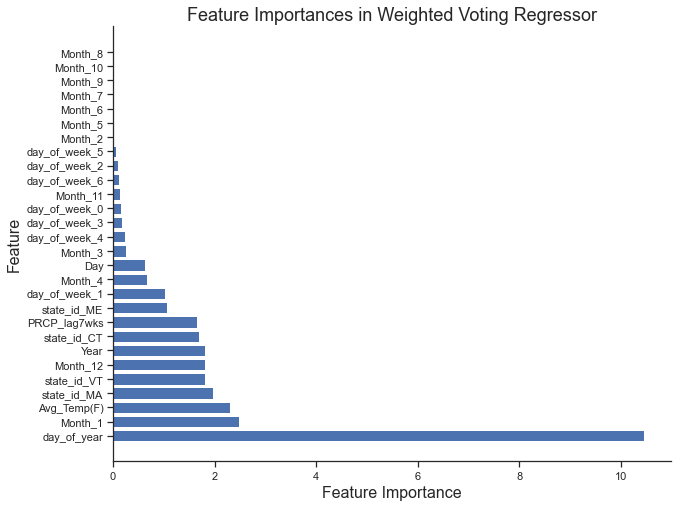

In [181]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("ticks")
fig, ax = plt.subplots()
plt.barh(feat_df['Feature'],
         feat_df['Feature Importance'])
plt.xlabel('Feature Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
#ax.set_ylabel('Feature')
plt.title('Feature Importances in Weighted Voting Regressor', fontsize=18)
sns.despine()
plt.show()

In [31]:
#load dataframe OHE
#parse datetime column
df_test = pd.read_csv('prcp_lag_TEST.csv', parse_dates=['date'])
df_test.drop(columns='Unnamed: 0', inplace=True)
df_test.set_index('date', inplace=True)

In [34]:
len(df_test.columns)

20

In [56]:
df_test

,Avg_Temp(F),Conf_Cases,day_of_year,Year,Day,new_case_percent_pop*,PRCP_lag7wks,state_id_CT,state_id_MA,state_id_ME,state_id_VT,Month_9,Month_10,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,
2021-09-12,44.8556,1695.0,255,2021,12,24.111238,15.690086,0,1,0,0,1,0,0,0,0,0,0,0,1
2021-09-13,44.9528,1695.0,256,2021,13,24.111238,15.690086,0,1,0,0,1,0,1,0,0,0,0,0,0
2021-09-14,43.7864,548.0,257,2021,14,7.795256,5.988691,0,1,0,0,1,0,0,1,0,0,0,0,0
2021-09-15,45.4712,2877.0,258,2021,15,40.925092,20.839506,0,1,0,0,1,0,0,0,1,0,0,0,0
2021-09-16,44.4020,2148.0,259,2021,16,30.555126,24.950508,0,1,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-09,42.8468,491.0,282,2021,9,13.616407,21.381364,1,0,0,0,0,1,0,0,0,0,0,1,0
2021-10-10,42.5228,491.0,283,2021,10,13.616407,21.381364,1,0,0,0,0,1,0,0,0,0,0,0,1
2021-10-11,43.2356,491.0,284,2021,11,13.616407,21.381364,1,0,0,0,0,1,1,0,0,0,0,0,0


In [35]:
# Create features
X_abc, y_abc = df_test.drop(columns=['Conf_Cases', 'new_case_percent_pop*']), df_test['new_case_percent_pop*']

In [26]:
y_binned_abc = np.digitize(y_abc, bins)

In [28]:
X_train_abc, X_test_abc, y_train_abc, y_test_abc = train_test_split(X_abc, y_abc, test_size=0.2, random_state=42)

In [36]:
pred_voting = reg_voting.predict(X_abc)

ValueError: Number of features of the model must match the input. Model n_features is 28 and input n_features is 18 

In [51]:
df_ohe2 = df_ohe.copy()

In [52]:
df_ohe2

,Avg_Temp(F),Conf_Cases,day_of_year,Year,Day,new_case_percent_pop*,PRCP_lag7wks,state_id_CT,state_id_MA,state_id_ME,...,Month_10,Month_11,Month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,26.42,1.0,61,2020,1,0.014225,15.547836,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2020-03-02,36.50,1.0,62,2020,2,0.014225,38.293482,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2020-03-03,55.94,1.0,63,2020,3,0.014225,31.223697,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2020-03-04,46.94,2.0,64,2020,4,0.028450,38.563755,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2020-03-05,42.98,8.0,65,2020,5,0.113799,34.239380,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,75.02,73.0,201,2021,20,2.024435,25.929410,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2021-07-21,75.02,228.0,202,2021,21,6.322894,17.360225,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2021-07-22,71.42,295.0,203,2021,22,8.180937,17.332493,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [59]:
df_ohe2 = df_ohe2.loc['2021-01-02':]

In [60]:
df_ohe2

,Avg_Temp(F),Conf_Cases,day_of_year,Year,Day,new_case_percent_pop*,PRCP_lag7wks,state_id_CT,state_id_MA,state_id_ME,...,Month_10,Month_11,Month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,39.02,9003.0,2,2021,2,128.066946,28.023090,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2021-01-03,34.34,3481.0,3,2021,3,49.516943,21.621877,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2021-01-04,35.42,4906.0,4,2021,4,69.787453,17.951848,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2021-01-05,32.90,4634.0,5,2021,5,65.918275,17.596225,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2021-01-06,35.42,6851.0,6,2021,6,97.454920,29.900780,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,75.02,73.0,201,2021,20,2.024435,25.929410,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2021-07-21,75.02,228.0,202,2021,21,6.322894,17.360225,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2021-07-22,71.42,295.0,203,2021,22,8.180937,17.332493,1,0,0,...,0,0,0,0,0,0,1,0,0,0
